In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.dummy import DummyRegressor, DummyClassifier
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc
from sklearn.metrics import f1_score, classification_report, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews_final.csv")

In [3]:
amenities = listings['amenities'].str.split(',', expand=True)
amenities = amenities.loc[amenities[77].notnull()]
amenities_list = amenities.iloc[0]
amenities_list = amenities_list.to_list()


listings.loc[listings['amenities'].str.contains('Hot Water|Shower gel|Hair dryer|Bathtub|Shampoo|Essentials|Bidet|Conditioner|Body soap|Baby bath'),
             'bath-products'] = 1
listings.loc[listings['amenities'].str.contains('Bluetooth sound system|Ethernet connection|Heating|Pocket wifi|Cable TV|Wifi'),
             'electric-system'] = 1
listings.loc[listings['amenities'].str.contains('Breakfast'),
             'food-services'] = 1
listings.loc[listings['amenities'].str.contains('Outdoor furniture|Dining table|Hangers|High chair|Crib|Clothing storage: wardrobe|Dedicated workspace|Drying rack for clothing|Bed linens|Extra pillows and blankets'),
             'house-furniture'] = 1
listings.loc[listings['amenities'].str.contains('Cleaning before checkout|Luggage dropoff allowed|Long term stays allowed'),
             'house-rules'] = 1
listings.loc[listings['amenities'].str.contains('Oven|Hot water kettle|Kitchen|Cooking basics|Microwave|Fire pit|Dishes and silverware|Barbecue utensils|Cleaning products|Baking sheet|Free washer|Free dryer|Iron|Dishwasher|Freezer|Coffee maker|Refrigerator|Toaster|dinnerware|BBQ grill|Stove|Wine glasses'),
                          'kitchen-appliances'] = 1
listings.loc[listings['amenities'].str.contains('Free parking on premises|Free street parking'),
             'parking'] = 1
listings.loc[listings['amenities'].str.contains('Board games|Indoor fireplace|Bikes|Shared patio or balcony|Private fenced garden or backyard|crib|books and toys|Outdoor dining area|Private gym in building|Piano|HDTV with Netflix|premium cable|standard cable'),
             'recreation'] = 1
listings.loc[listings['amenities'].str.contains('Fire extinguisher|Carbon monoxide alarm|Window guards|Fireplace guards|First aid kit|Baby monitor|Private entrance|Lockbox|Smoke alarm|Room-darkening shades|Baby safety gates'),
             'safety'] = 1

In [4]:
host_verification = listings['host_verifications'].str.split(',', expand=True)

listings.loc[listings['host_verifications'].str.contains('email'),
             'host_email'] = 1
listings.loc[listings['host_verifications'].str.contains('phone'),
             'host_phone'] = 1
listings.loc[listings['host_verifications'].str.contains('work_email'),
             'host_work_email'] = 1

In [5]:
new_feature_cols = listings.iloc[:,75:].columns
listings[new_feature_cols] = listings[new_feature_cols].fillna(0)


In [6]:
listings = listings.merge(reviews, how='inner', left_on='id', right_on='listing_id')

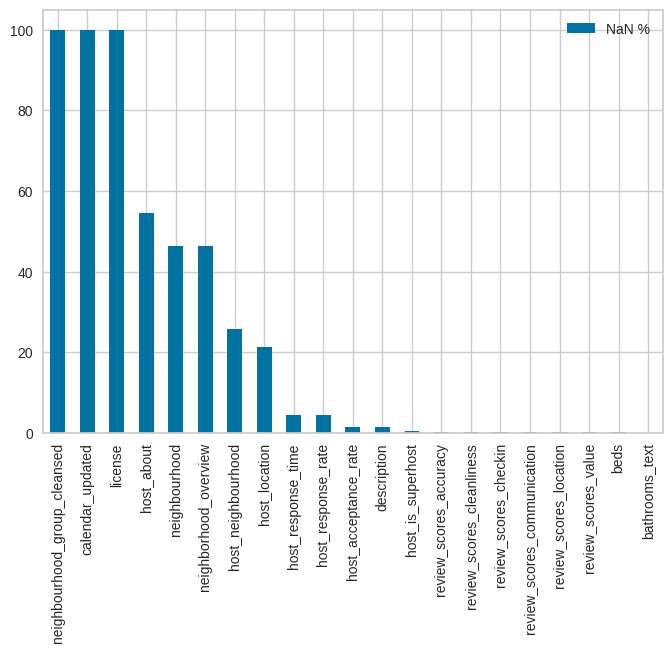

In [7]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'NaN %' :na_df})
        missing_data.plot(kind = "bar")
        plt.show()
    else:
        print('No NAs found')
plot_nas(listings)

In [8]:
not_needed_columns = [
    'id','listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
    'picture_url', 'host_id', 'host_url', 'host_name', 'host_location',
    'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'neighbourhood', 'neighbourhood_group_cleansed',
    'calendar_updated', 'first_review', 'last_review', 'license',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'description', 'neighborhood_overview', 'host_verifications','host_since',
    'bathrooms', 'bathrooms_text', 'amenities', 'availability_30',
    'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'host_has_profile_pic', 'property_type',
    'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm'
    ]

listings.drop(not_needed_columns, axis = 1, inplace = True)
listings = listings.dropna()

In [9]:
imputation_cols = ['bedrooms', 'beds']
for i in imputation_cols:
    listings.loc[listings.loc[:,i].isnull(),i] = listings.loc[:,i].median()

(0.0, 1750.0)

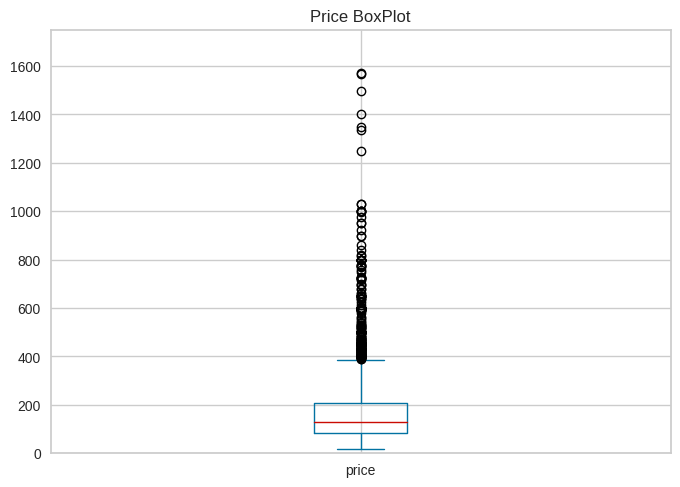

In [10]:
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = pd.to_numeric(listings['price'])
listings['host_response_rate'] = listings["host_response_rate"].str.replace("%","")
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'])
listings['host_acceptance_rate'] = listings["host_acceptance_rate"].str.replace("%","")
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'])

listings[['price']].plot(kind='box', title='Price BoxPlot')
plt.ylim(0,1750)

<Axes: title={'center': 'Price BoxPlot'}>

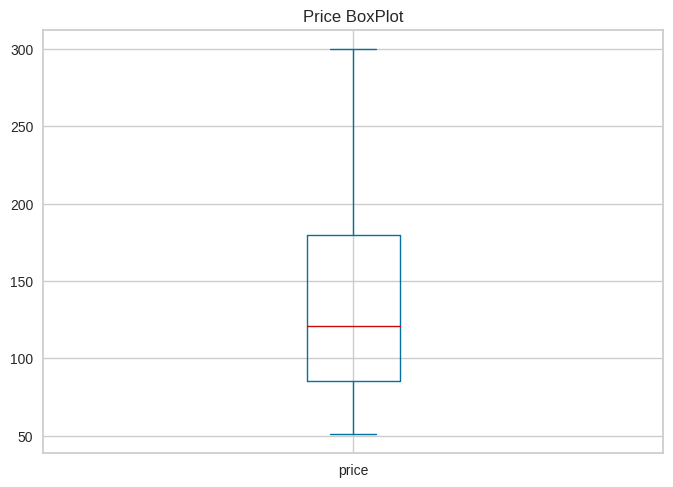

In [11]:
listings = listings[listings.price > 50]
listings = listings[listings.price <= 300]
listings[['price']].plot(kind='box', title='Price BoxPlot')

<Axes: title={'center': 'Dublin Neighborhood Frequency'}, xlabel='neighbourhood_cleansed'>

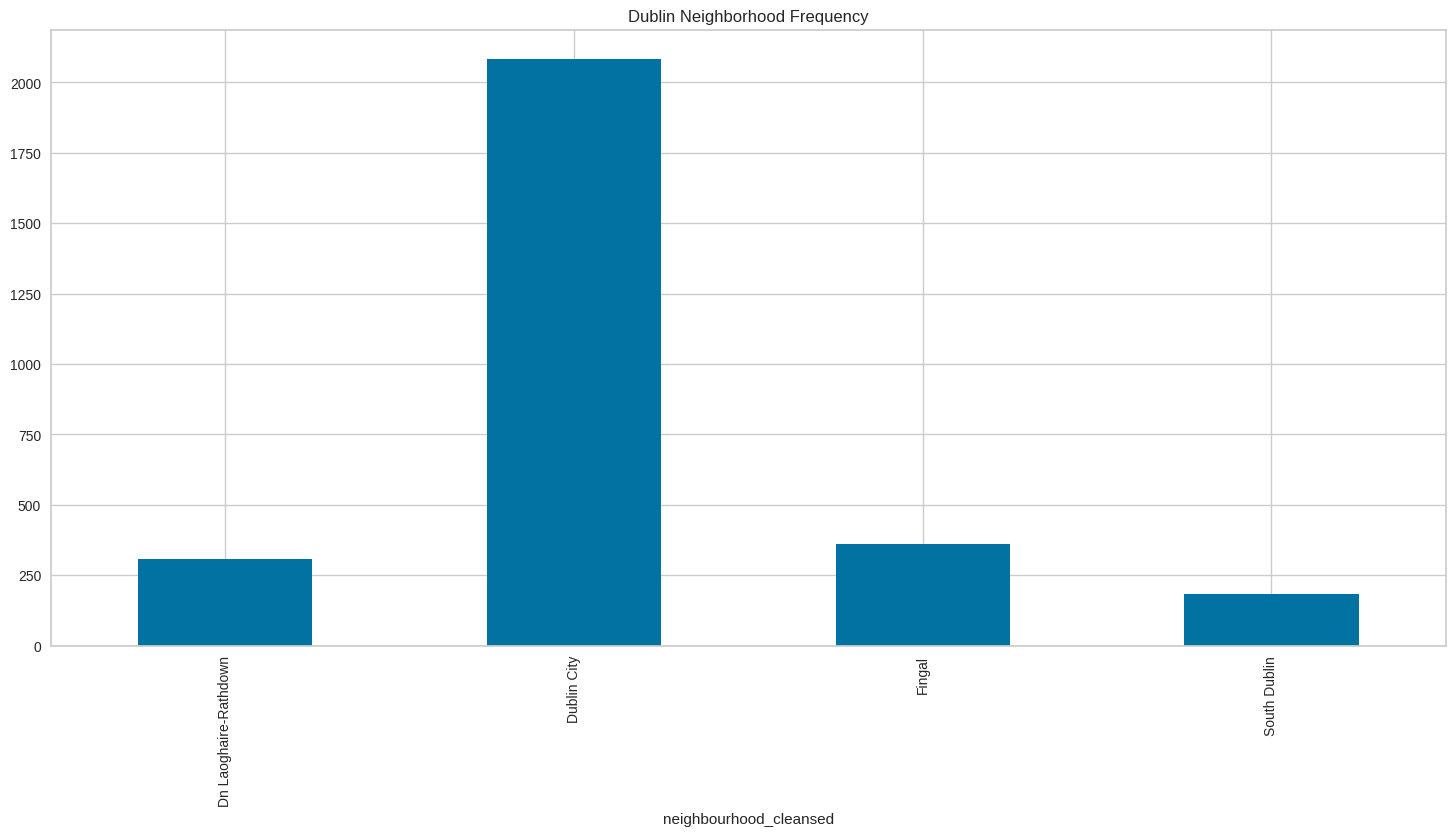

In [12]:
listings.neighbourhood_cleansed.unique()
listings.groupby('neighbourhood_cleansed').host_response_time.count()
neighbourhood_DF=listings.groupby('neighbourhood_cleansed').host_response_time.count()
neighbourhood_DF=neighbourhood_DF.reset_index()
neighbourhood_DF=neighbourhood_DF.rename(columns={'host_response_time':'Number_Of_Listings'})
neighbourhood_DF.plot(kind='bar',
           x='neighbourhood_cleansed',
           y='Number_Of_Listings',
           figsize =(18,8),
           title = 'Dublin Neighborhood Frequency',
           legend = False)

In [13]:
print(listings.review_scores_accuracy.mean())
print(listings.review_scores_checkin.mean())
print(listings.review_scores_cleanliness.mean())
print(listings.review_scores_communication.mean())
print(listings.review_scores_location.mean())
print(listings.review_scores_rating.mean())
print(listings.review_scores_value.mean())

print(listings.review_scores_accuracy.median())
print(listings.review_scores_checkin.median())
print(listings.review_scores_cleanliness.median())
print(listings.review_scores_communication.median())
print(listings.review_scores_location.median())
print(listings.review_scores_rating.median())
print(listings.review_scores_value.median())

print(listings.review_scores_accuracy.mode())
print(listings.review_scores_checkin.mode())
print(listings.review_scores_cleanliness.mode())
print(listings.review_scores_communication.mode())
print(listings.review_scores_location.mode())
print(listings.review_scores_rating.mode())
print(listings.review_scores_value.mode())

print(listings.review_scores_accuracy.min())
print(listings.review_scores_checkin.min())
print(listings.review_scores_cleanliness.min())
print(listings.review_scores_communication.min())
print(listings.review_scores_location.min())
print(listings.review_scores_rating.min())
print(listings.review_scores_value.min())

print(listings.review_scores_accuracy.max())
print(listings.review_scores_checkin.max())
print(listings.review_scores_cleanliness.max())
print(listings.review_scores_communication.max())
print(listings.review_scores_location.max())
print(listings.review_scores_rating.max())
print(listings.review_scores_value.max())


4.7883100511073255
4.825652470187394
4.721294718909711
4.854020442930153
4.752616695059626
4.749025553662691
4.601764906303237
4.88
4.92
4.83
4.94
4.82
4.84
4.69
0    5.0
Name: review_scores_accuracy, dtype: float64
0    5.0
Name: review_scores_checkin, dtype: float64
0    5.0
Name: review_scores_cleanliness, dtype: float64
0    5.0
Name: review_scores_communication, dtype: float64
0    5.0
Name: review_scores_location, dtype: float64
0    5.0
Name: review_scores_rating, dtype: float64
0    5.0
Name: review_scores_value, dtype: float64
1.0
1.0
1.0
1.0
1.0
1.0
1.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


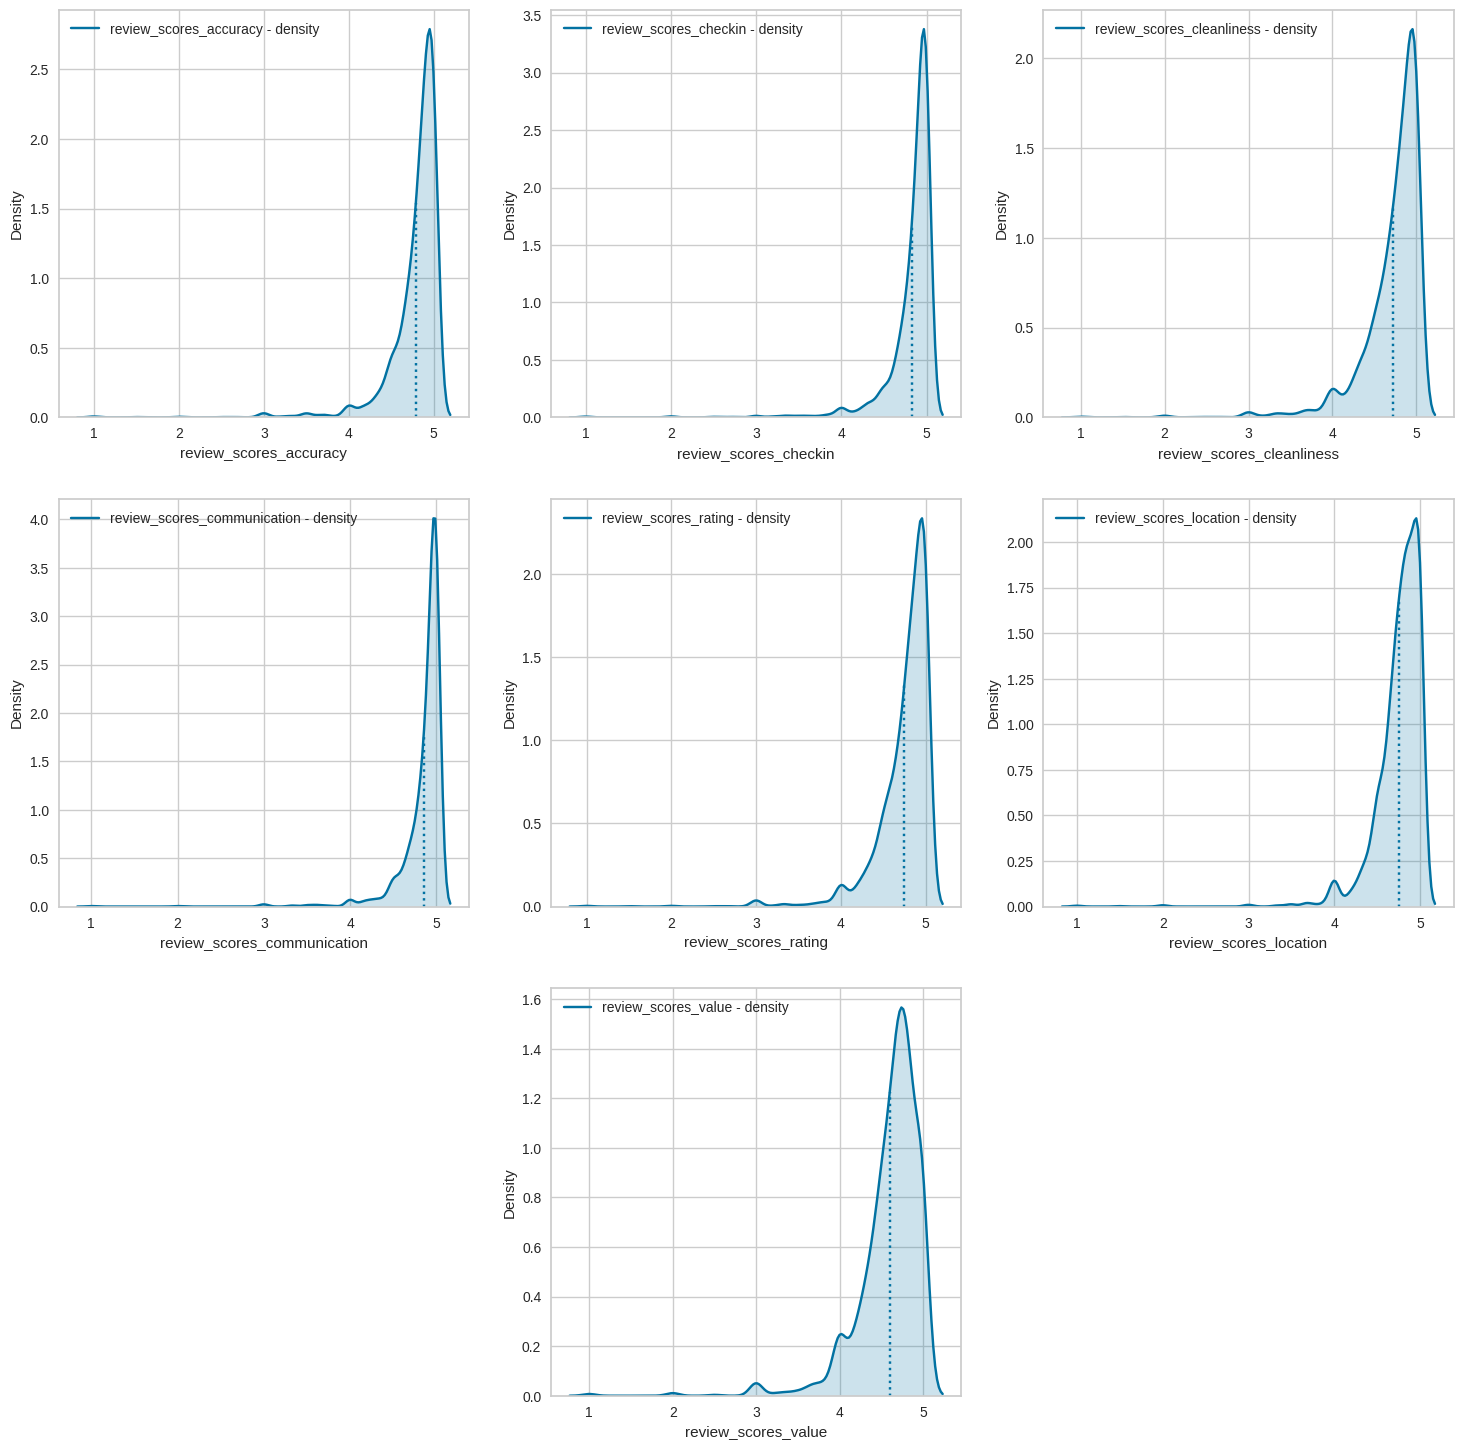

In [14]:
plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
review_scores_accuracy_density = sns.kdeplot(listings.review_scores_accuracy, color="b",
                                             label='review_scores_accuracy - density')
x_review_scores_accuracy = review_scores_accuracy_density.lines[0].get_xdata()
y_review_scores_accuracy = review_scores_accuracy_density.lines[0].get_ydata()
mean_review_scores_accuracy_density = listings.review_scores_accuracy.mean()
height_review_scores_accuracy = np.interp(mean_review_scores_accuracy_density, x_review_scores_accuracy,
                                                   y_review_scores_accuracy)
review_scores_accuracy_density.vlines(mean_review_scores_accuracy_density, 0, height_review_scores_accuracy,
                                      color='b', ls=':')
review_scores_accuracy_density.fill_between(x_review_scores_accuracy, 0, y_review_scores_accuracy,
                                            facecolor='b', alpha=0.2)
plt.legend()


plt.subplot(3, 3, 2)
review_scores_checkin_density = sns.kdeplot(listings.review_scores_checkin, color="b",
                                             label='review_scores_checkin - density')
x_review_scores_checkin = review_scores_checkin_density.lines[0].get_xdata()
y_review_scores_checkin = review_scores_checkin_density.lines[0].get_ydata()
mean_review_scores_checkin_density = listings.review_scores_checkin.mean()
height_review_scores_checkin = np.interp(mean_review_scores_checkin_density, x_review_scores_checkin,
                                                   y_review_scores_checkin)
review_scores_checkin_density.vlines(mean_review_scores_checkin_density, 0, height_review_scores_checkin,
                                      color='b', ls=':')
review_scores_checkin_density.fill_between(x_review_scores_checkin, 0, y_review_scores_checkin,
                                            facecolor='b', alpha=0.2)
plt.legend()



plt.subplot(3, 3, 3)
review_scores_cleanliness_density = sns.kdeplot(listings.review_scores_cleanliness, color="b",
                                             label='review_scores_cleanliness - density')
x_review_scores_cleanliness = review_scores_cleanliness_density.lines[0].get_xdata()
y_review_scores_cleanliness = review_scores_cleanliness_density.lines[0].get_ydata()
mean_review_scores_cleanliness_density = listings.review_scores_cleanliness.mean()
height_review_scores_cleanliness = np.interp(mean_review_scores_cleanliness_density, x_review_scores_cleanliness,
                                                   y_review_scores_cleanliness)
review_scores_cleanliness_density.vlines(mean_review_scores_cleanliness_density, 0, height_review_scores_cleanliness,
                                      color='b', ls=':')
review_scores_cleanliness_density.fill_between(x_review_scores_cleanliness, 0, y_review_scores_cleanliness,
                                            facecolor='b', alpha=0.2)
plt.legend()


plt.subplot(3, 3, 4)
review_scores_communication_density = sns.kdeplot(listings.review_scores_communication, color="b",
                                             label='review_scores_communication - density')
x_review_scores_communication = review_scores_communication_density.lines[0].get_xdata()
y_review_scores_communication = review_scores_communication_density.lines[0].get_ydata()
mean_review_scores_communication_density = listings.review_scores_communication.mean()
height_review_scores_communication = np.interp(mean_review_scores_communication_density, x_review_scores_communication,
                                                   y_review_scores_communication)
review_scores_communication_density.vlines(mean_review_scores_communication_density, 0, height_review_scores_communication,
                                      color='b', ls=':')
review_scores_communication_density.fill_between(x_review_scores_communication, 0, y_review_scores_communication,
                                            facecolor='b', alpha=0.2)
plt.legend()

plt.subplot(3, 3, 5)
review_scores_rating_density = sns.kdeplot(listings.review_scores_rating, color="b",
                                             label='review_scores_rating - density')
x_review_scores_rating = review_scores_rating_density.lines[0].get_xdata()
y_review_scores_rating = review_scores_rating_density.lines[0].get_ydata()
mean_review_scores_rating_density = listings.review_scores_rating.mean()
height_review_scores_rating = np.interp(mean_review_scores_rating_density, x_review_scores_rating,
                                                   y_review_scores_rating)
review_scores_rating_density.vlines(mean_review_scores_rating_density, 0, height_review_scores_rating,
                                      color='b', ls=':')
review_scores_rating_density.fill_between(x_review_scores_rating, 0, y_review_scores_rating,
                                            facecolor='b', alpha=0.2)
plt.legend()


plt.subplot(3, 3, 6)
review_scores_location_density = sns.kdeplot(listings.review_scores_location, color="b",
                                             label='review_scores_location - density')
x_review_scores_location = review_scores_location_density.lines[0].get_xdata()
y_review_scores_location = review_scores_location_density.lines[0].get_ydata()
mean_review_scores_location_density = listings.review_scores_location.mean()
height_review_scores_location = np.interp(mean_review_scores_location_density, x_review_scores_location,
                                                   y_review_scores_location)
review_scores_location_density.vlines(mean_review_scores_location_density, 0, height_review_scores_location,
                                      color='b', ls=':')
review_scores_location_density.fill_between(x_review_scores_location, 0, y_review_scores_location,
                                            facecolor='b', alpha=0.2)
plt.legend()

plt.subplot(3, 3, 8)
review_scores_value_density = sns.kdeplot(listings.review_scores_value, color="b",
                                             label='review_scores_value - density')
x_review_scores_value = review_scores_value_density.lines[0].get_xdata()
y_review_scores_value = review_scores_value_density.lines[0].get_ydata()
mean_review_scores_value_density = listings.review_scores_value.mean()
height_review_scores_value = np.interp(mean_review_scores_value_density, x_review_scores_value,
                                                   y_review_scores_value)
review_scores_value_density.vlines(mean_review_scores_value_density, 0, height_review_scores_value,
                                      color='b', ls=':')
review_scores_value_density.fill_between(x_review_scores_value, 0, y_review_scores_value,
                                            facecolor='b', alpha=0.2)
plt.legend()

plt.show()

In [15]:
def minmax(X):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (X.max() - X.min()) + X.min()
    return X_scaled

In [16]:
scaling_data = ['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds',
                'host_listings_count', 'host_total_listings_count',
                'latitude', 'longitude', 'accommodates', 'price',
                'minimum_nights', 'maximum_nights', 'number_of_reviews', 'num_cmt', #'avg_senti',
                'review_scores_rating', 'review_scores_accuracy',
                'review_scores_cleanliness', 'review_scores_checkin',
                'review_scores_communication', 'review_scores_location',
                'review_scores_value', 'reviews_per_month','bath-products','electric-system',
                'food-services','house-furniture','house-rules',
                'kitchen-appliances','parking','recreation','safety',
                'host_email','host_work_email']

for i in scaling_data:
  listings[i] = minmax(listings[i])

In [17]:
listings.dropna(axis = 1, inplace = True)
label_encoder = preprocessing.LabelEncoder()
listings.host_response_time     = label_encoder.fit_transform(listings.host_response_time)
listings.host_is_superhost      = label_encoder.fit_transform(listings.host_is_superhost)
listings.host_identity_verified = label_encoder.fit_transform(listings.host_identity_verified)
listings.instant_bookable       = label_encoder.fit_transform(listings.instant_bookable)
listings.room_type              = label_encoder.fit_transform(listings.room_type)
listings.neighbourhood_cleansed = label_encoder.fit_transform(listings.neighbourhood_cleansed)
listings.has_availability       = label_encoder.fit_transform(listings.has_availability)

In [18]:
test_corr = listings.corr()
test_corr.to_csv("corr.csv")

In [19]:
def print_metrics(y_test, y_pred):
    print("-"*10+"CONFUSION-MATRIX"+"-"*10)
    print(confusion_matrix(y_test, y_pred))

    print("-"*10+"CLASSIFICATION-REPORT"+"-"*10)
    print(classification_report(y_test, y_pred))

In [20]:
X = listings[
                ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'bedrooms', 'beds','neighbourhood_cleansed',
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                 'host_identity_verified', 'room_type',
                 'accommodates','price', 'minimum_nights', 'maximum_nights',
                 'bath-products','electric-system',
                 'food-services','house-furniture','house-rules',
                 'kitchen-appliances','parking','recreation','safety',
                 'host_email','host_work_email'] + list(reviews.columns[2:])
]

In [21]:
y = listings[['review_scores_accuracy']]
y = (y/y.max())*100

y = y.assign(
    rating_bin_ep = pd.qcut(
        y['review_scores_accuracy'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)

In [22]:
y.groupby('rating_bin_ep').min()
y.groupby('rating_bin_ep').max()
y = y['rating_bin_ep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

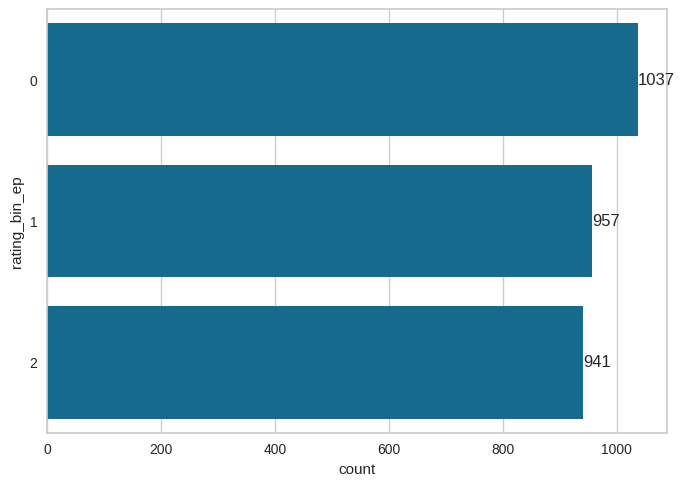

In [23]:
cnt_plt = sns.countplot(y)
cnt_plt.bar_label(cnt_plt.containers[0])
plt.show()

C =  0.001
Train accuracy score: 0.5393003180372558
Test accuracy score: 0.5040871934604905
Mean Squared Error:  1.055858310626703
C =  0.1
Train accuracy score: 0.5797364834166288
Test accuracy score: 0.55858310626703
Mean Squared Error:  0.8950953678474114
C =  1
Train accuracy score: 0.5970013630168105
Test accuracy score: 0.5803814713896458
Mean Squared Error:  0.7915531335149864
C =  10
Train accuracy score: 0.5970013630168105
Test accuracy score: 0.5831062670299727
Mean Squared Error:  0.7806539509536785
C =  100
Train accuracy score: 0.5974557019536574
Test accuracy score: 0.5831062670299727
Mean Squared Error:  0.7724795640326976
C =  1000
Train accuracy score: 0.5974557019536574
Test accuracy score: 0.5844686648501363
Mean Squared Error:  0.771117166212534


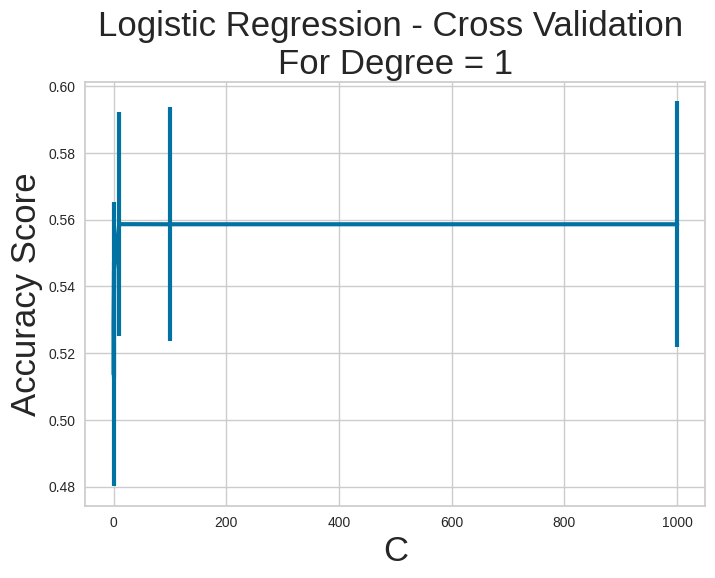

In [24]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
mean_error = []
std_error = []
for c in sorted(c_range):
    logit = LogisticRegression(C=c, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    print("C = ",c)
    print('Train accuracy score:',logit.score(X_train, y_train))
    print('Test accuracy score:',logit.score(X_test, y_test))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    scores = cross_val_score(logit, X_test, y_test, cv=5, scoring='accuracy')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
plt.xlabel('C', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = "Logistic Regression - Cross Validation \nFor Degree = 1"
plt.title(title_cv, fontsize=25)
plt.show()

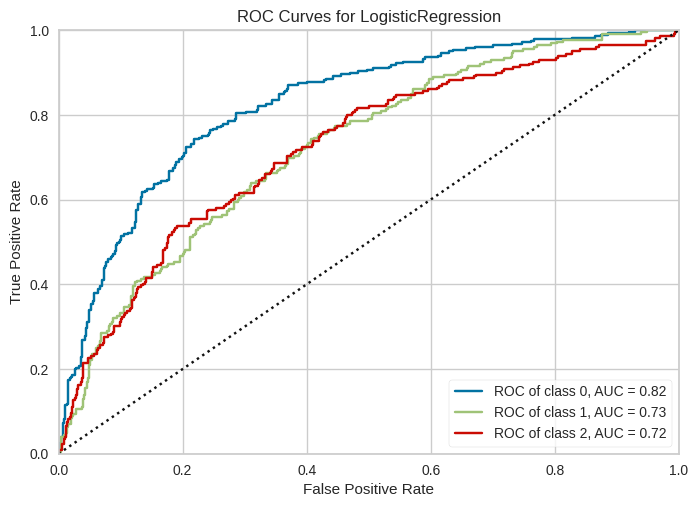

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [25]:
visualizer = ROCAUC(logit, classes=["0", "1", "2"], macro=False, micro=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

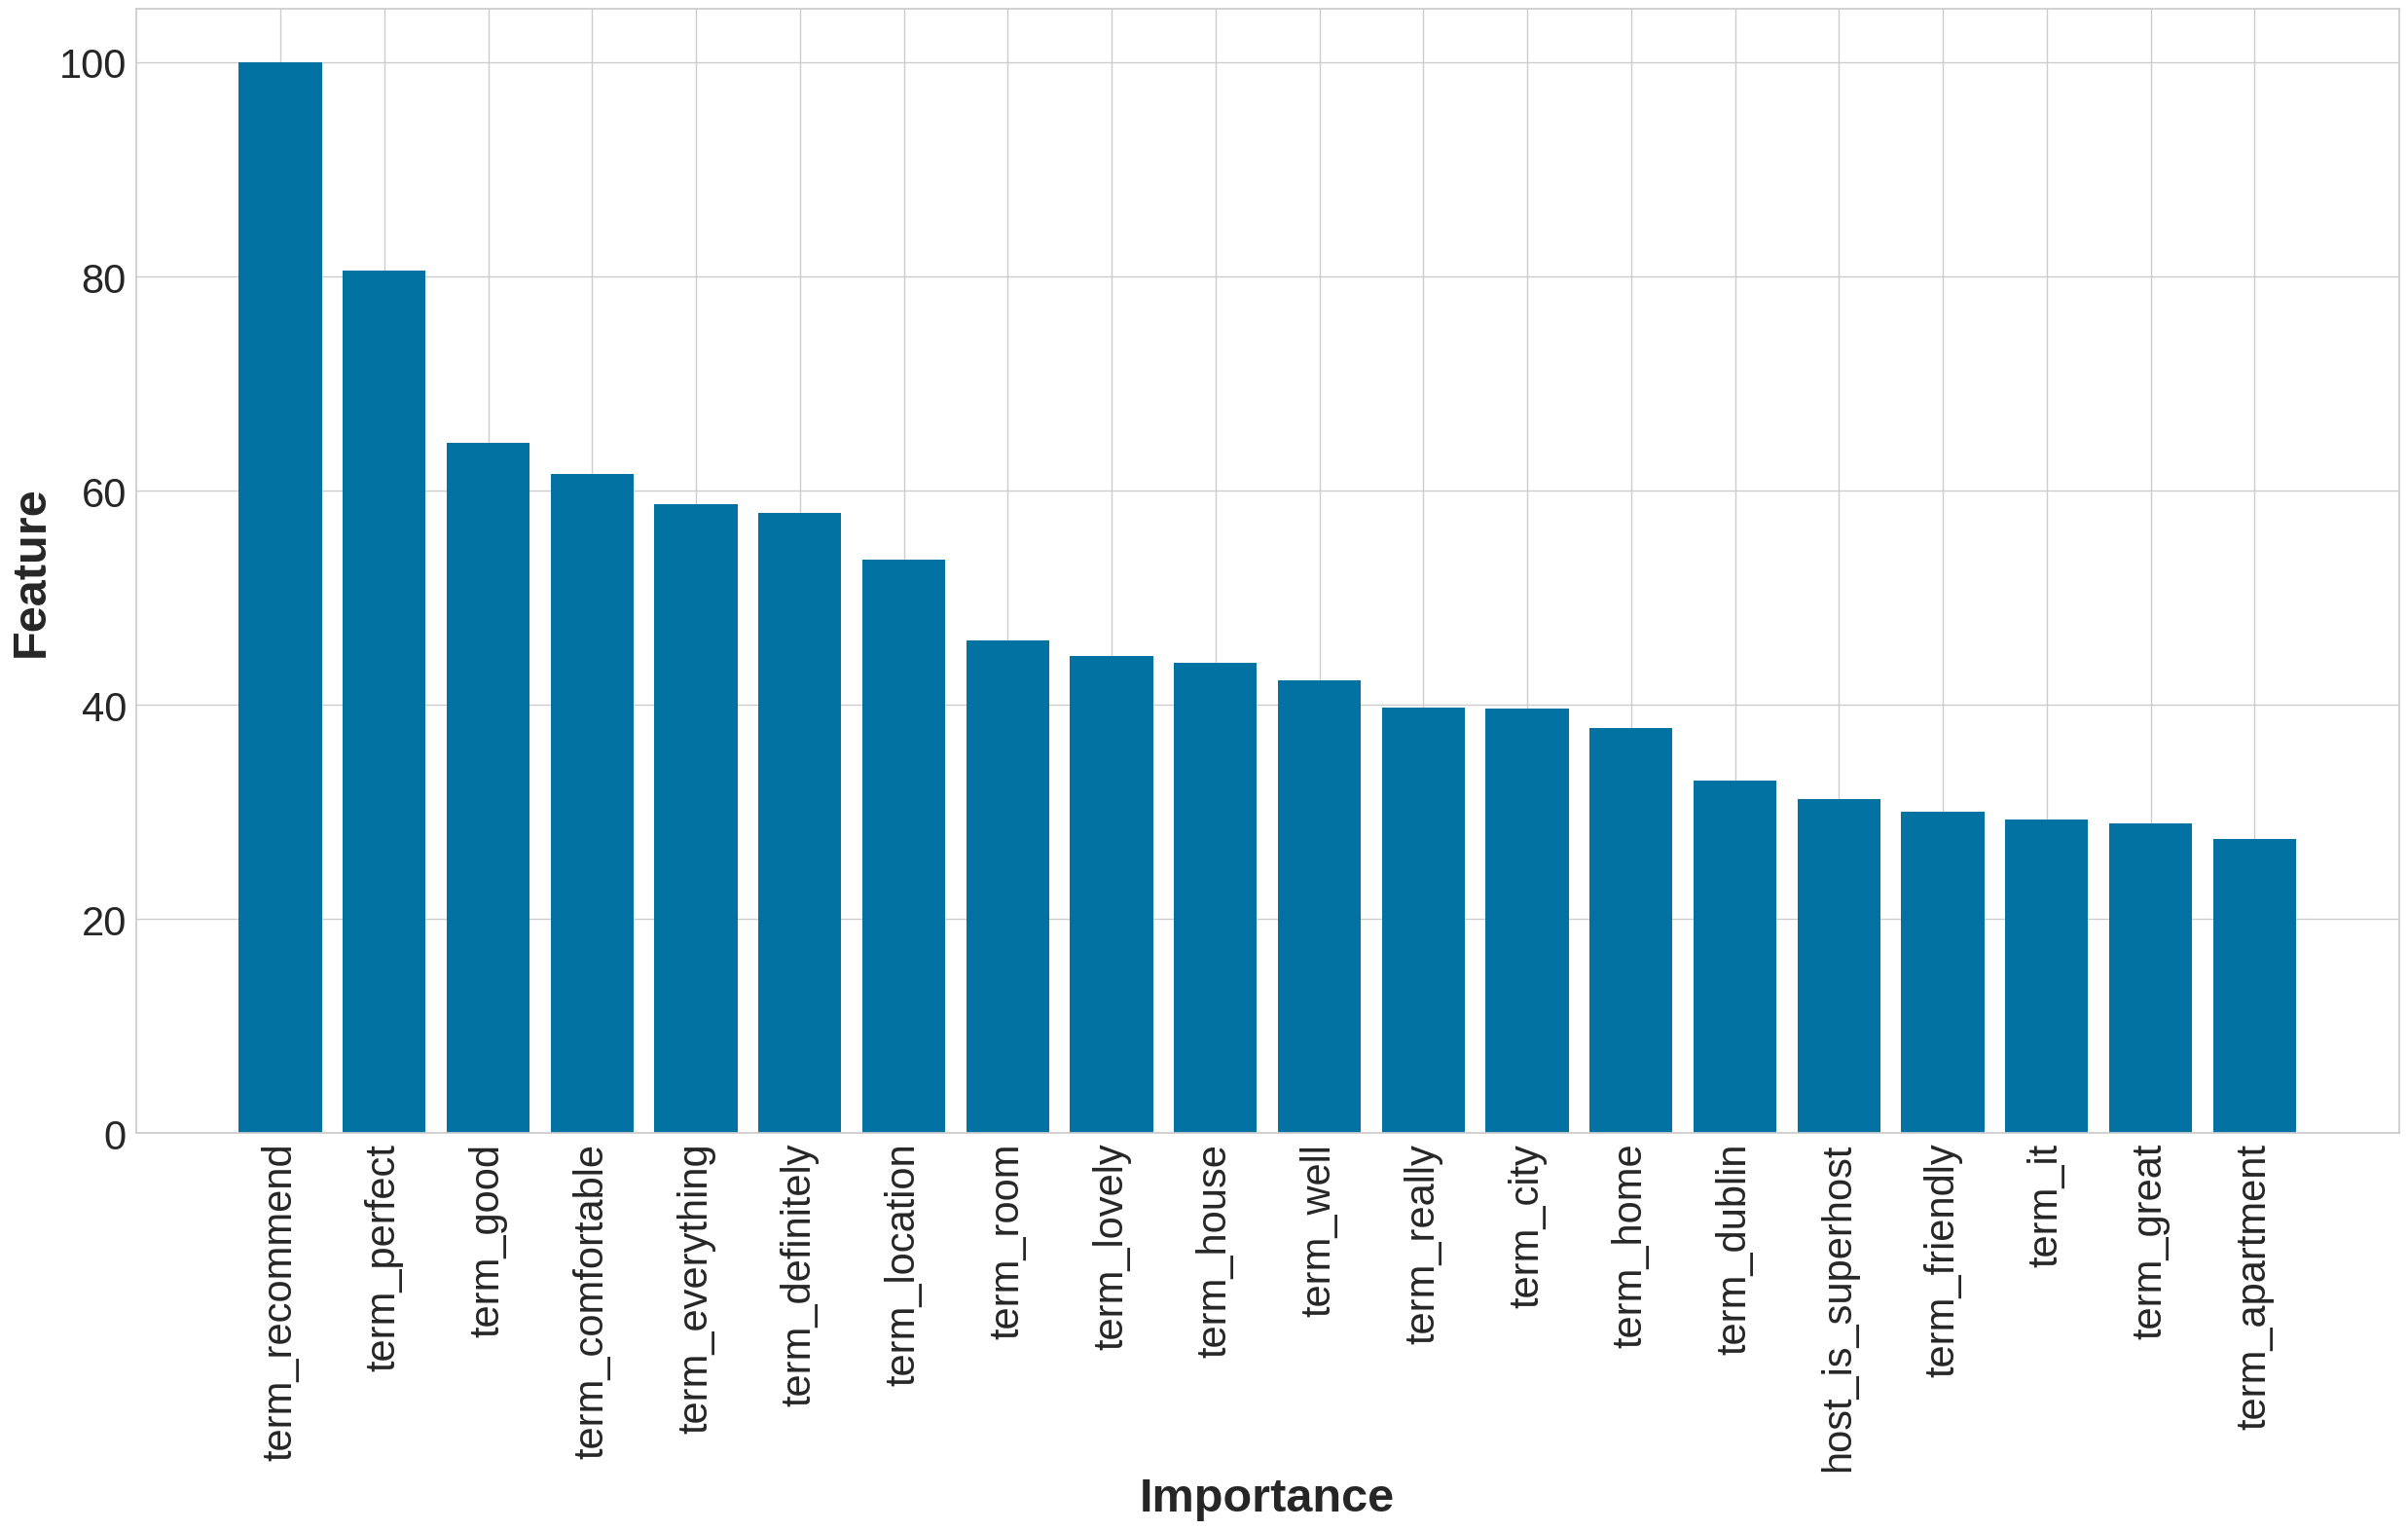

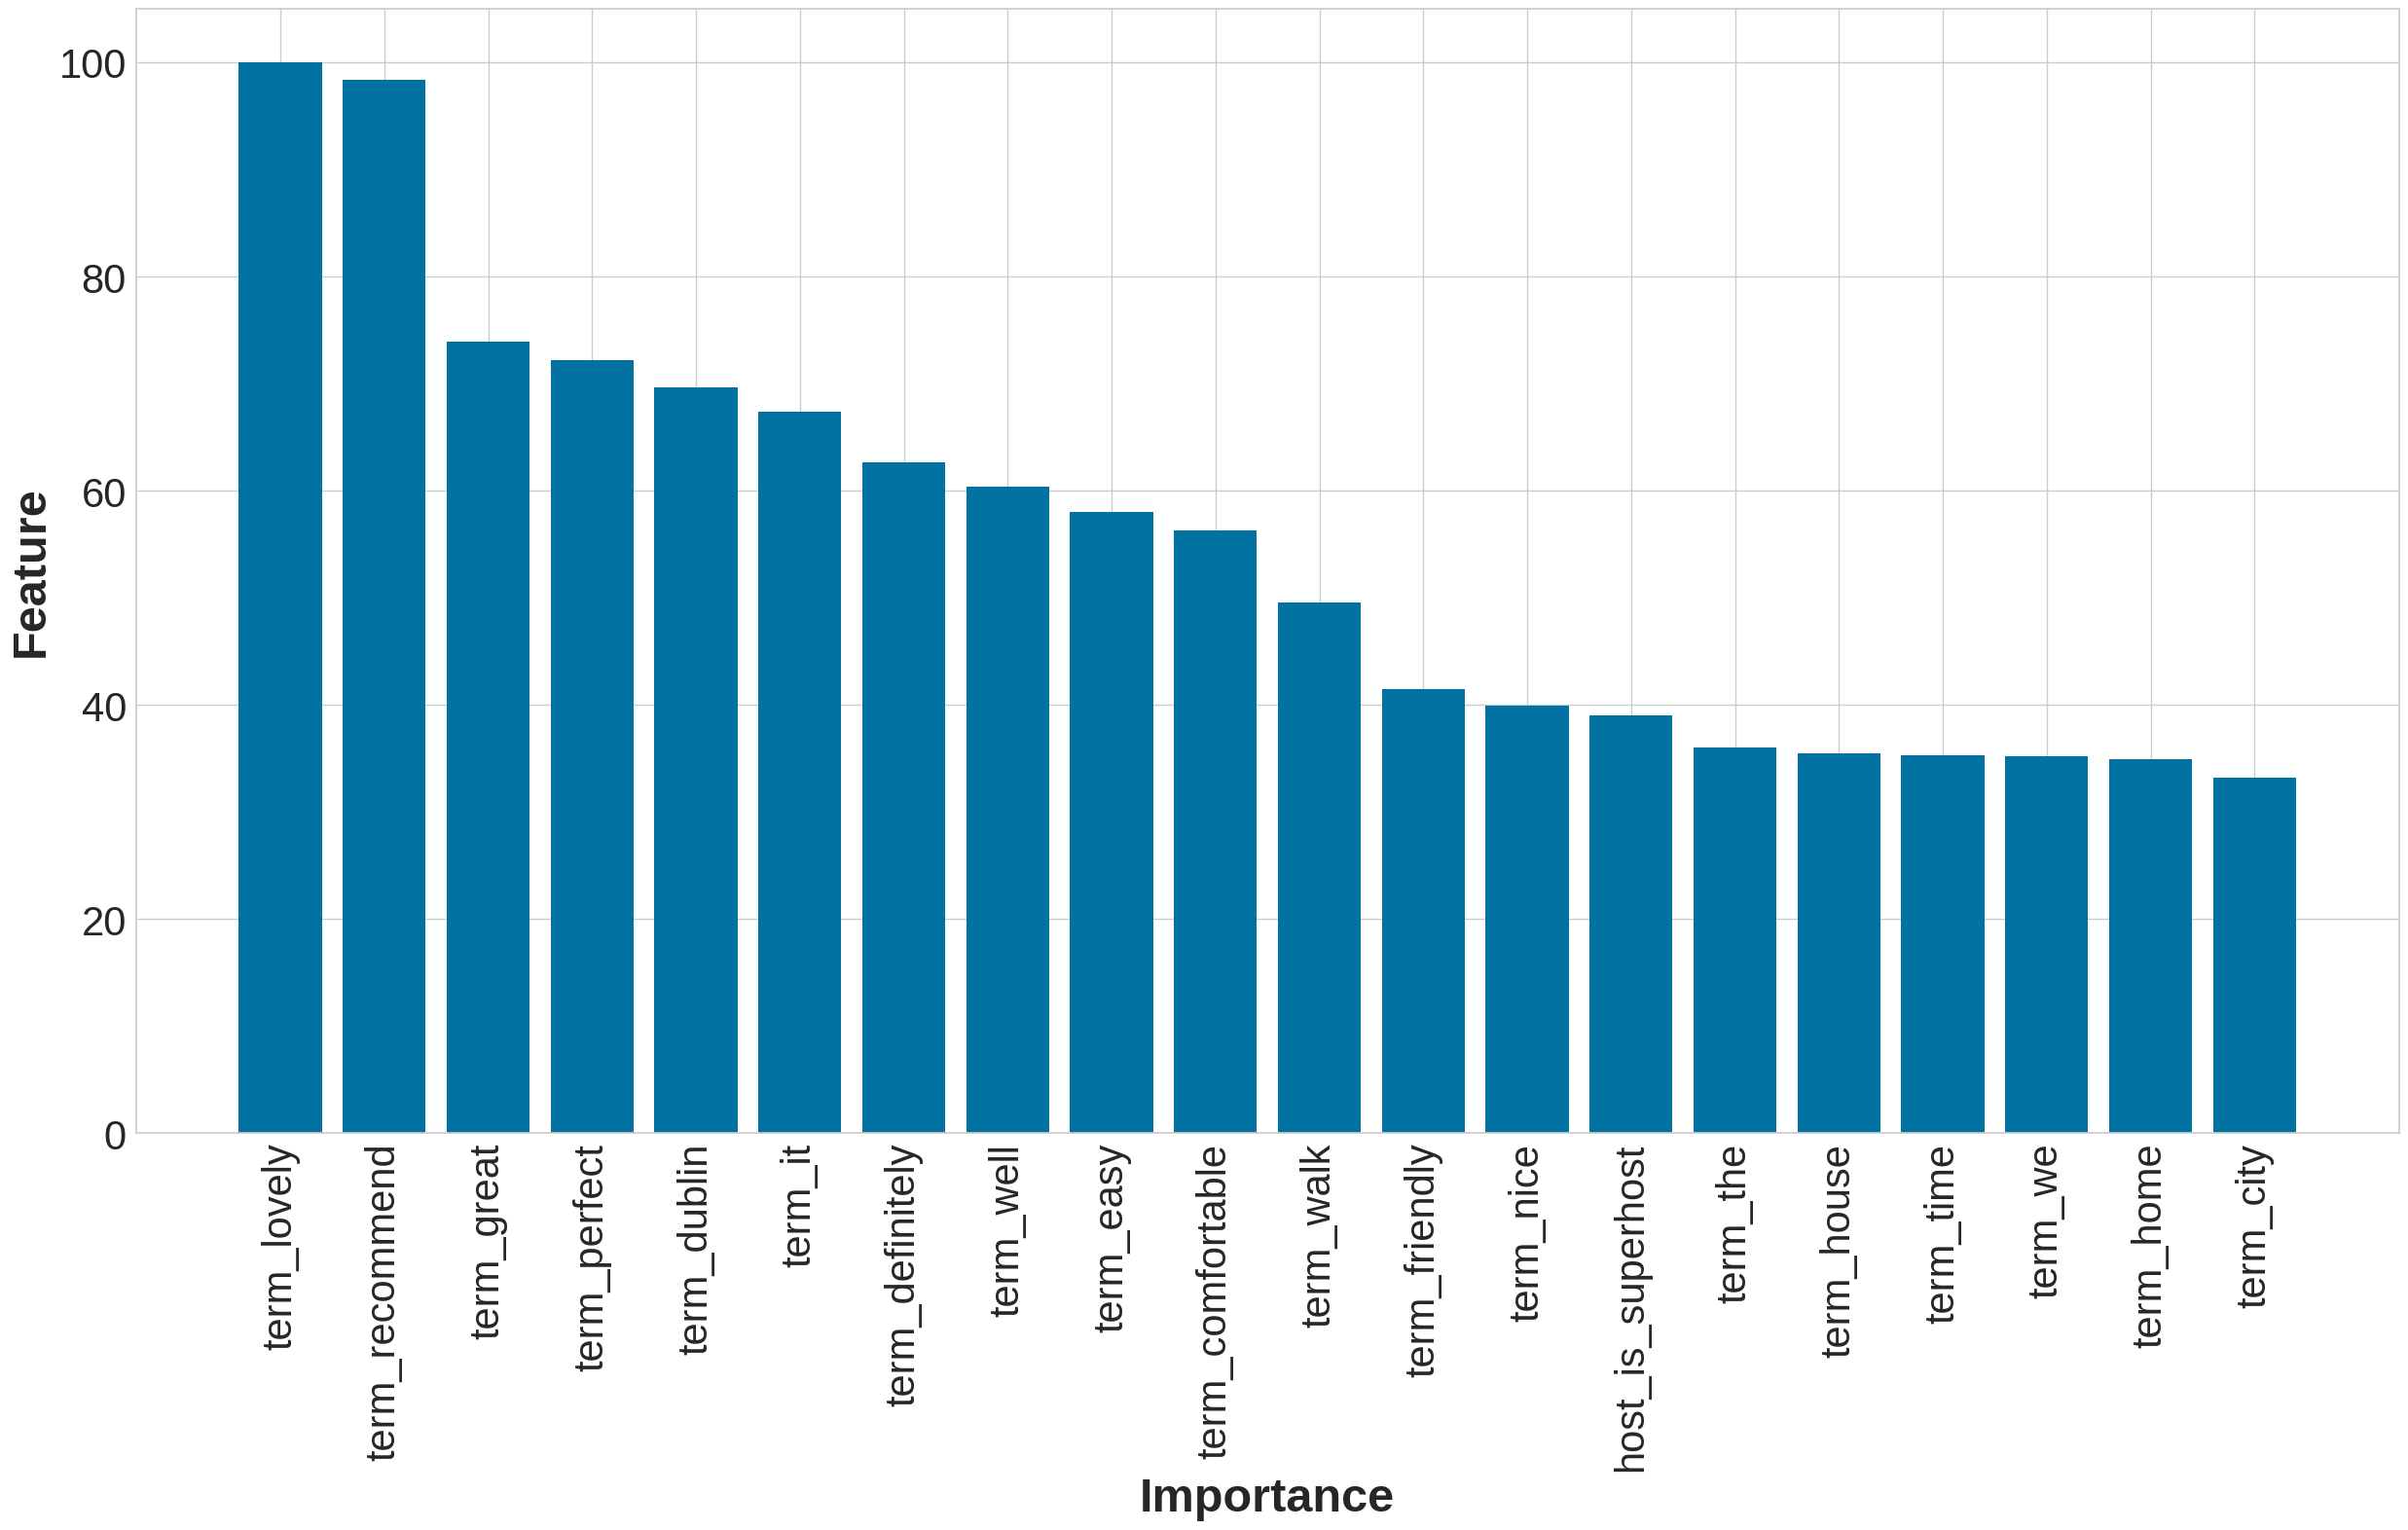

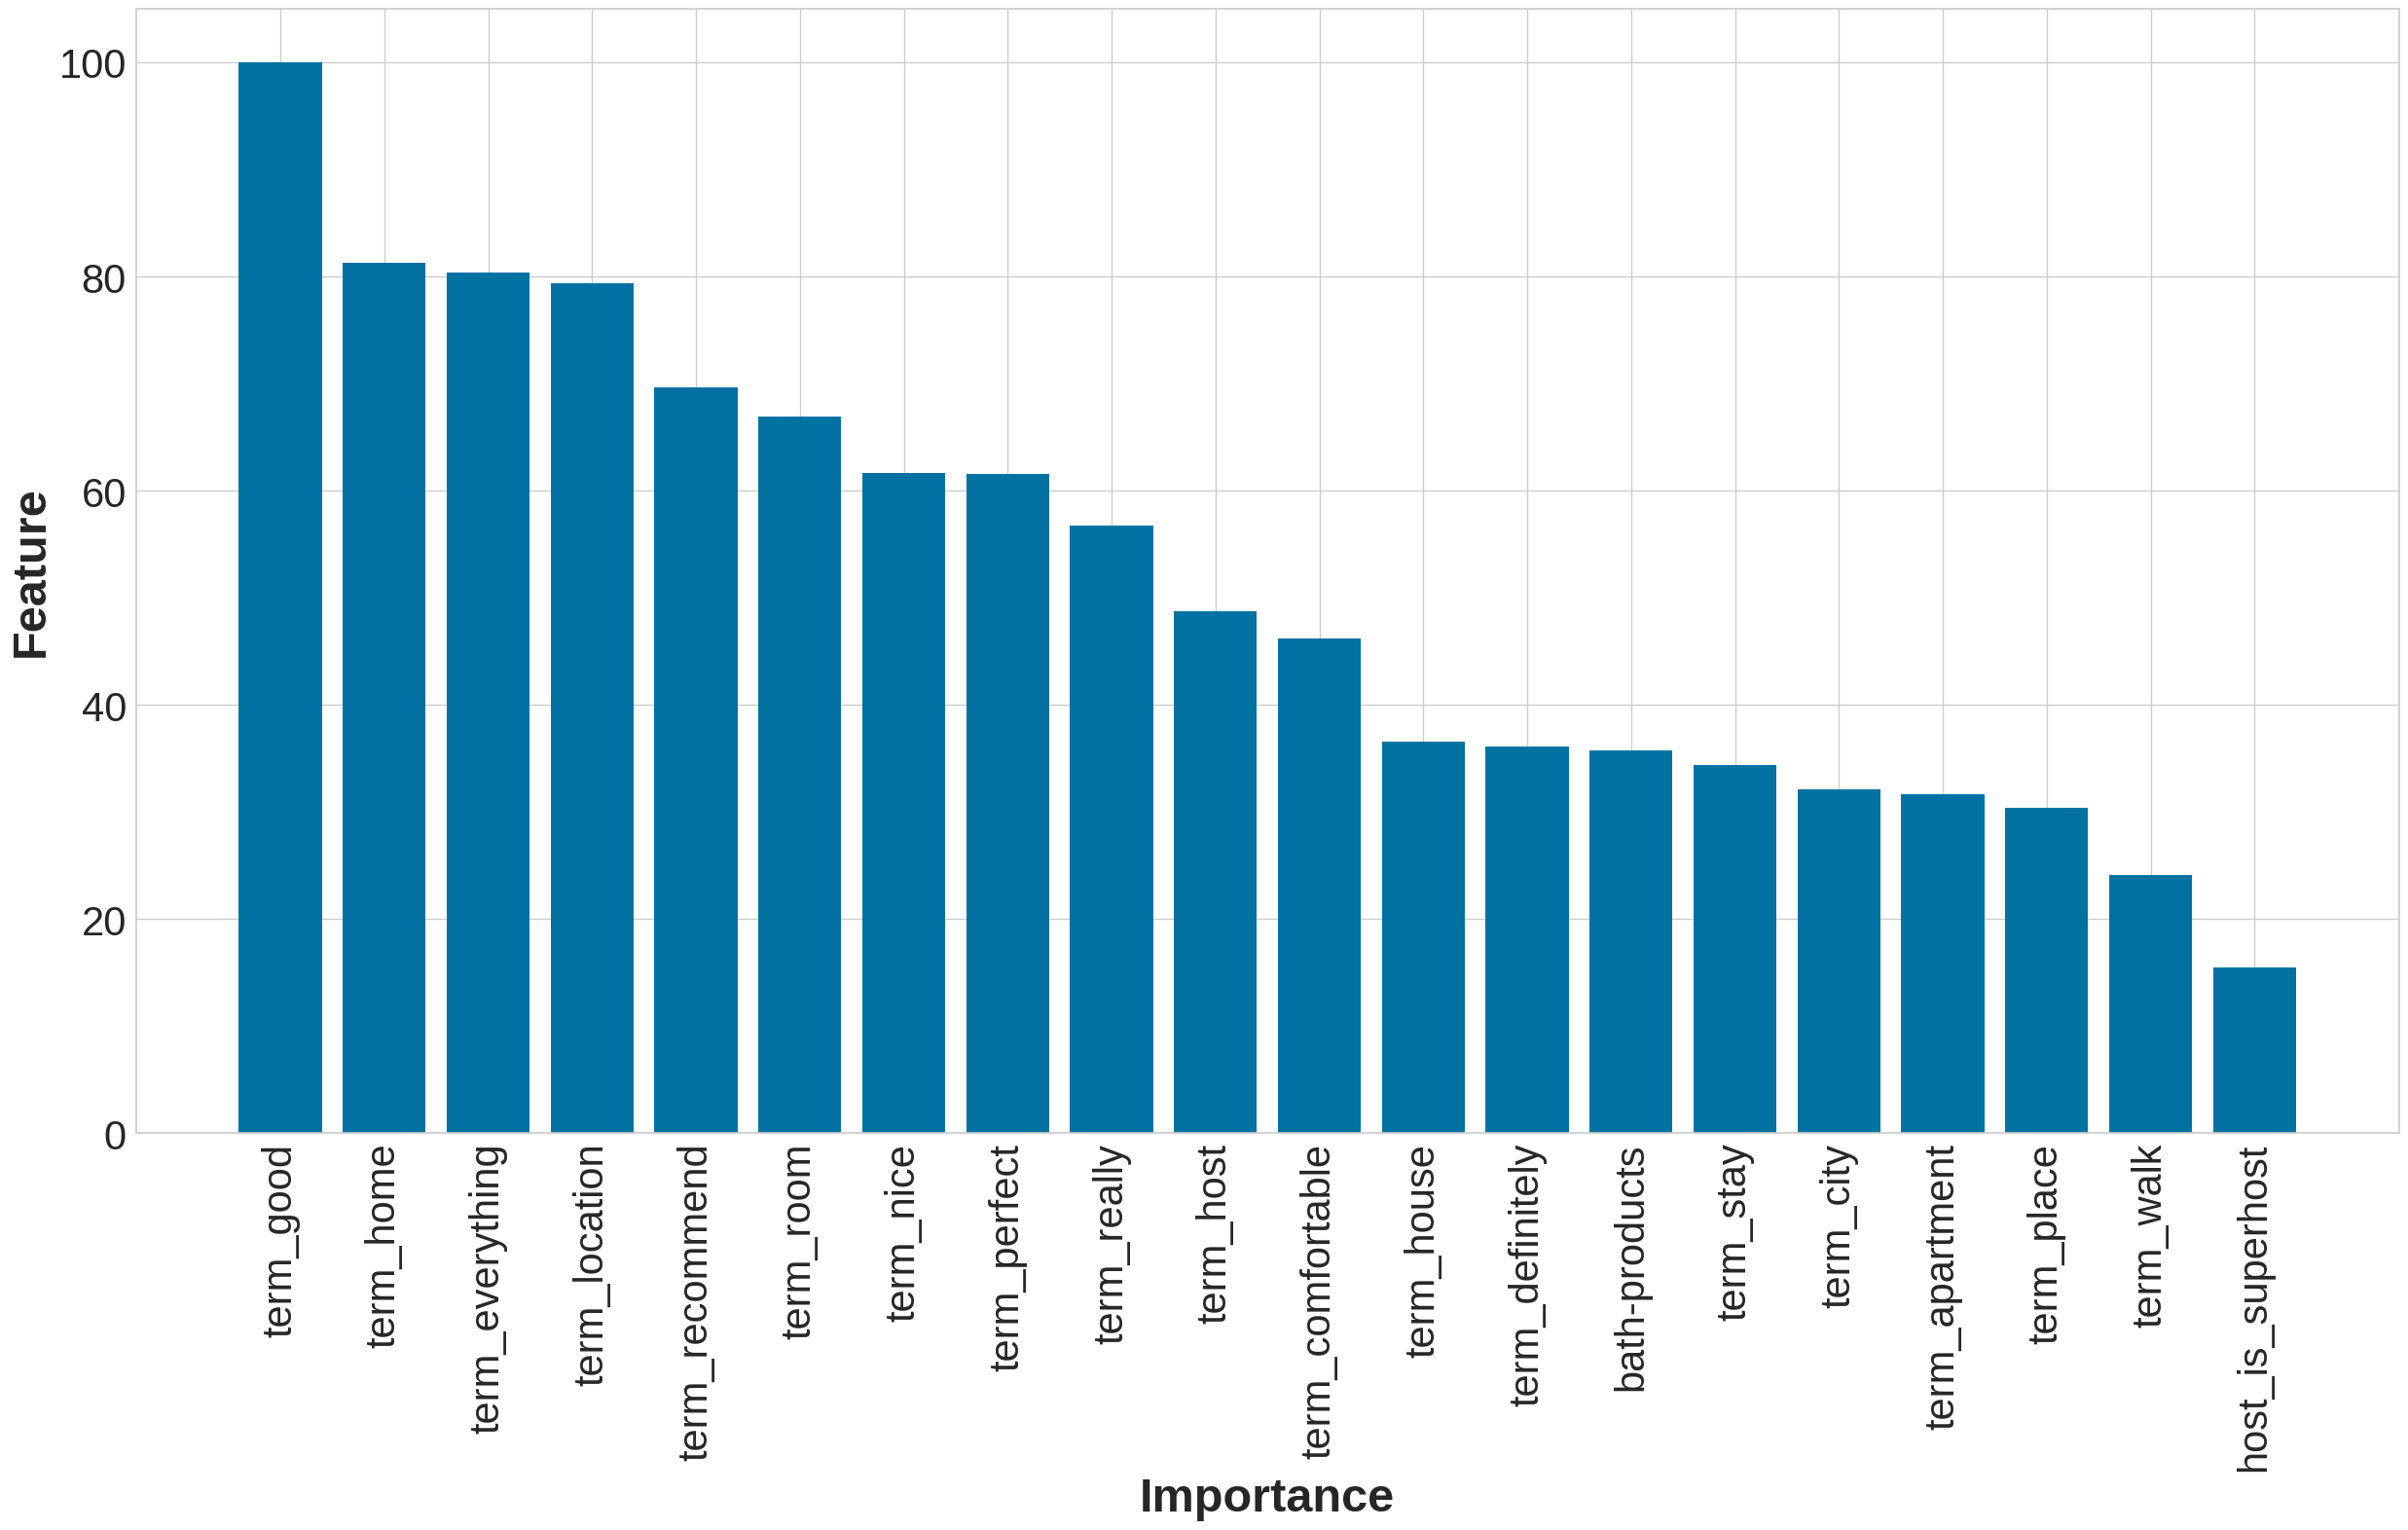

In [26]:
from matplotlib import pyplot
cols = X.columns
cols = np.asarray(cols)

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[1])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[2])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

In [27]:
dmfr = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dmun = DummyClassifier(strategy='uniform').fit(X_train, y_train)

print("\n\nDUMMY CLASSIFIER - frequent")
print(dmfr.score(X_test, y_test))
y_pred = dmfr.predict(X_test)
print_metrics(y_test, y_pred)

print("\n\nDUMMY CLASSIFIER - Uniform")
print(dmun.score(X_test, y_test))
y_pred = dmun.predict(X_test)
print_metrics(y_test, y_pred)



DUMMY CLASSIFIER - frequent
0.3814713896457766
----------CONFUSION-MATRIX----------
[[280   0   0]
 [225   0   0]
 [229   0   0]]
----------CLASSIFICATION-REPORT----------
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       280
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00       229

    accuracy                           0.38       734
   macro avg       0.13      0.33      0.18       734
weighted avg       0.15      0.38      0.21       734



DUMMY CLASSIFIER - Uniform
0.3133514986376022
----------CONFUSION-MATRIX----------
[[ 91 100  89]
 [ 64  82  79]
 [ 63  76  90]]
----------CLASSIFICATION-REPORT----------
              precision    recall  f1-score   support

           0       0.42      0.33      0.37       280
           1       0.32      0.36      0.34       225
           2       0.35      0.39      0.37       229

    accuracy                           0.36       734


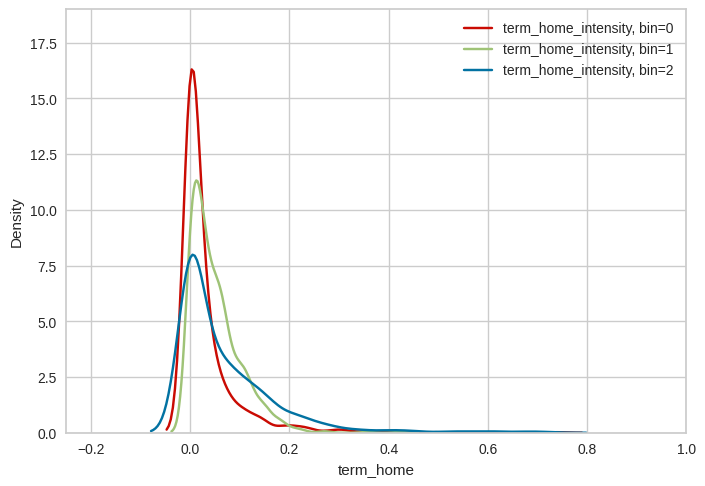

In [28]:
test = pd.concat([X, y], axis=1)
g = sns.kdeplot(test.loc[test['rating_bin_ep'] == 0, 'term_home'], color="r", label='term_home_intensity, bin=0')
g.set(ylim=(0, 19))
g.set(xlim=(-0.25, 1))
plt.legend()

h = sns.kdeplot(test.loc[test['rating_bin_ep'] == 1,'term_home'], color="g", label='term_home_intensity, bin=1')
h.set(ylim=(0, 19))
h.set(xlim=(-0.25, 1))
plt.legend()

i = sns.kdeplot(test.loc[test['rating_bin_ep'] == 2, 'term_home'], color="b", label='term_home_intensity, bin=2')
i.set(ylim=(0, 19))
i.set(xlim=(-0.25, 1))
plt.legend()

plt.show()

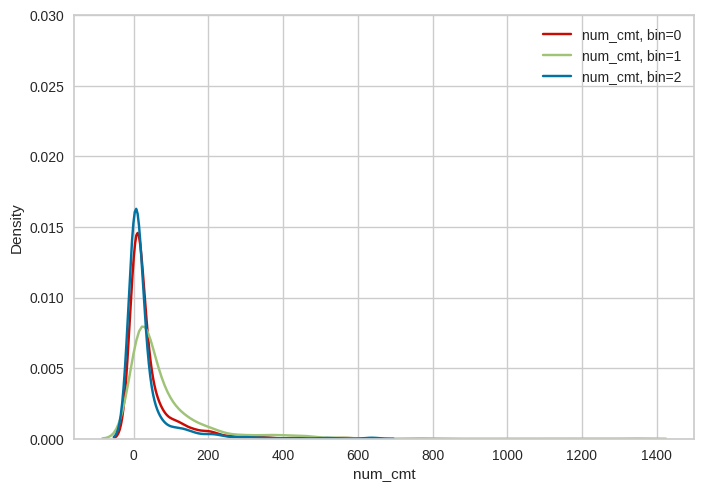

In [29]:
test = pd.concat([X, y], axis=1)

g = sns.kdeplot(test.loc[test['rating_bin_ep'] == 0, 'num_cmt'], color="r", label='num_cmt, bin=0')
g.set(ylim=(0, 0.03))
plt.legend()

h = sns.kdeplot(test.loc[test['rating_bin_ep'] == 1,'num_cmt'], color="g", label='num_cmt, bin=1')
h.set(ylim=(0, 0.03))
plt.legend()

i = sns.kdeplot(test.loc[test['rating_bin_ep'] == 2, 'num_cmt'], color="b", label='num_cmt, bin=2')
i.set(ylim=(0, 0.03))
plt.legend()

plt.show()

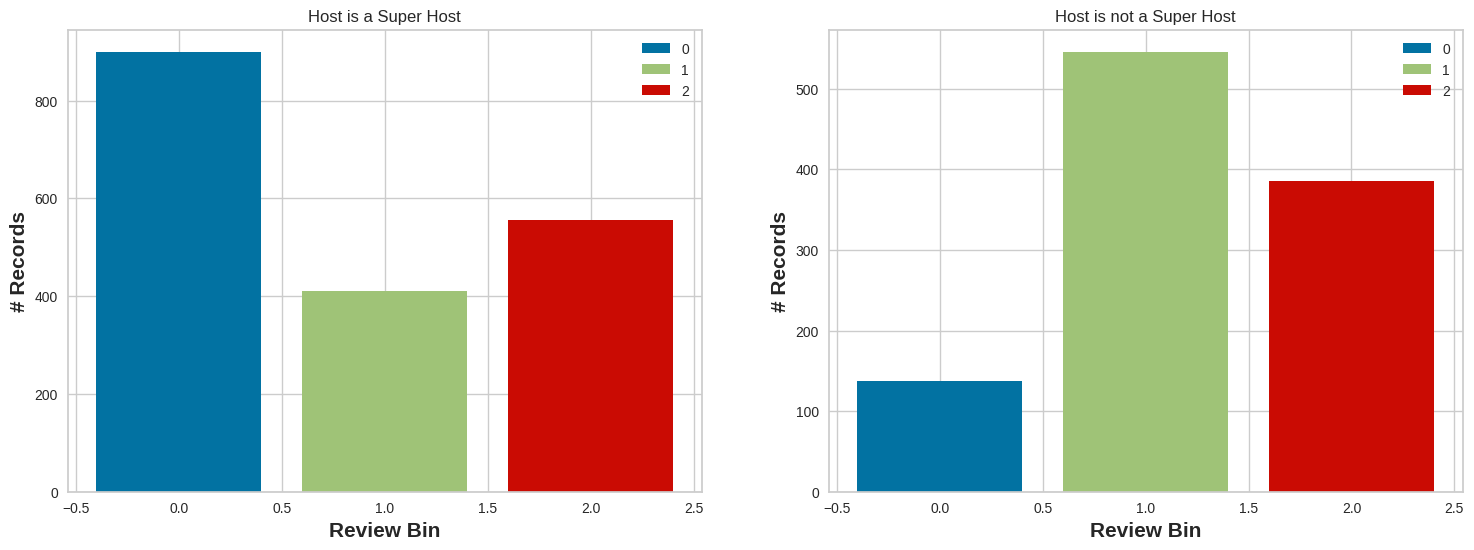

In [30]:
test.host_is_superhost.value_counts()
test1 = test.groupby(['host_is_superhost', 'rating_bin_ep']).size()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
for j in (0,1,2):
    plt.bar(j, test1[0][j], label = str(j))
plt.title("Host is a Super Host")
plt.legend()
plt.xlabel('Review Bin', fontweight ='bold', fontsize = 15)
plt.ylabel('# Records', fontweight ='bold', fontsize = 15)
plt.subplot(1, 2, 2)
for j in (0,1,2):
    plt.bar(j, test1[1][j], label = str(j))
plt.title("Host is not a Super Host")
plt.legend()
plt.xlabel('Review Bin', fontweight ='bold', fontsize = 15)
plt.ylabel('# Records', fontweight ='bold', fontsize = 15)
plt.show()



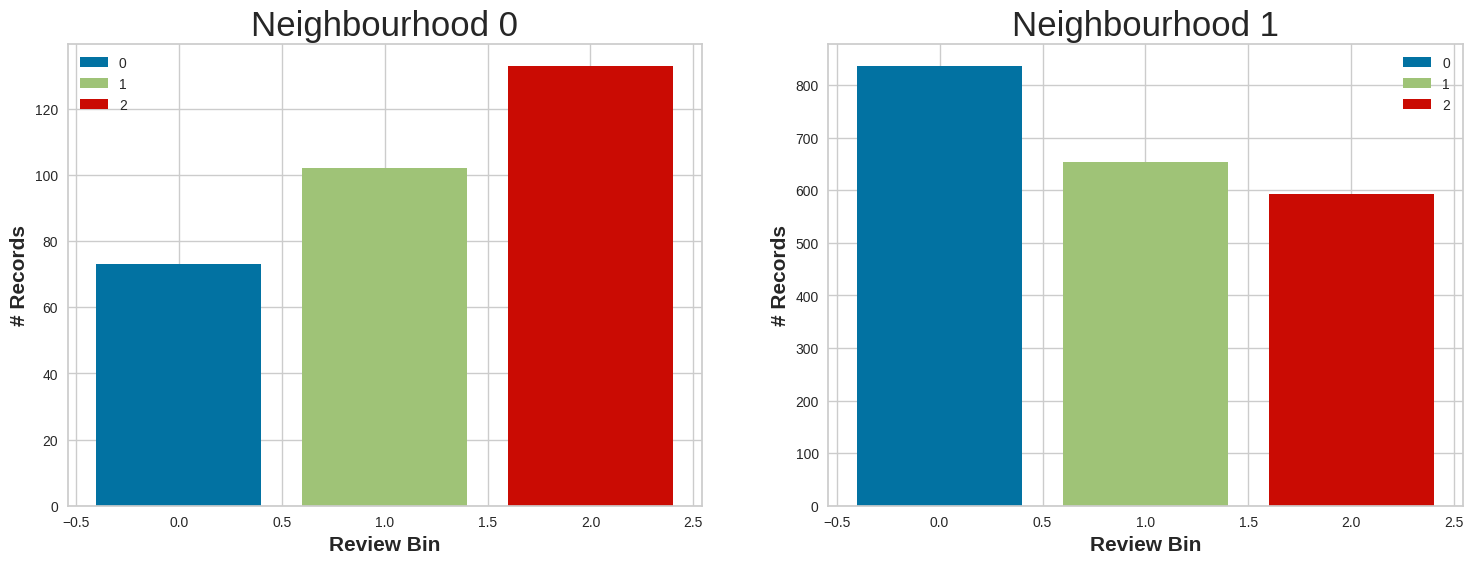

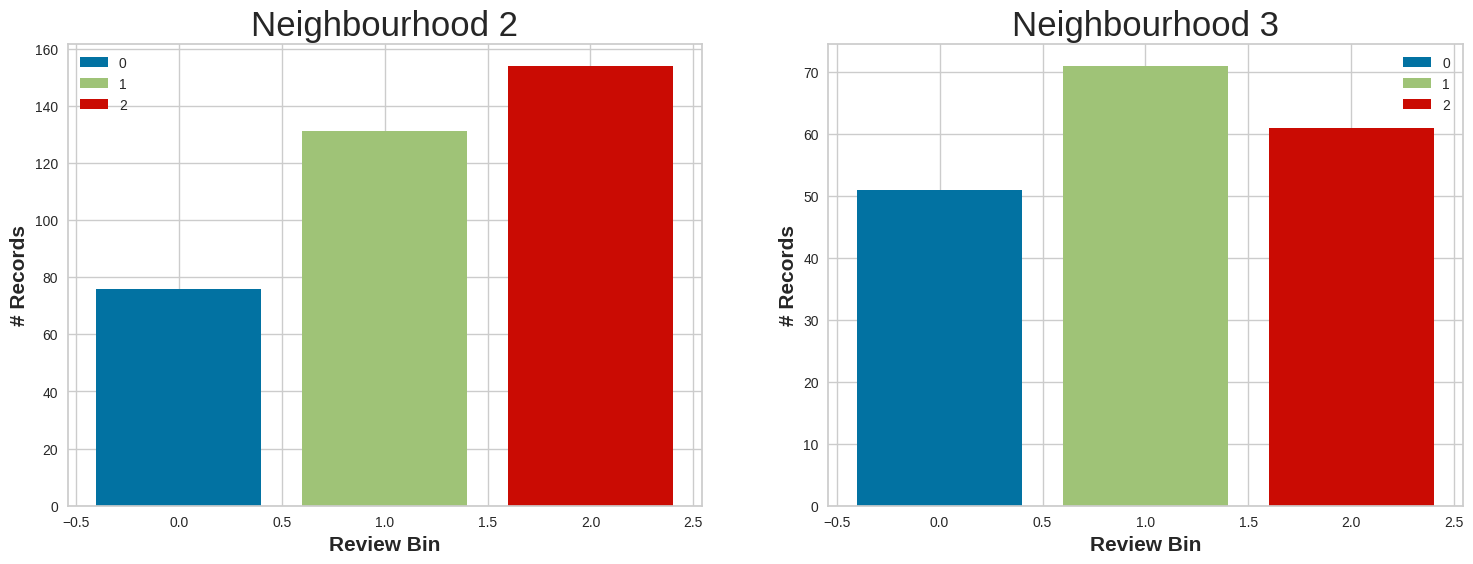

In [31]:
test.neighbourhood_cleansed.value_counts()
test2 = test.groupby(['neighbourhood_cleansed', 'rating_bin_ep']).size()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
for j in (0,1,2):
    plt.bar(j, test2[0][j], label = str(j))
plt.title("Neighbourhood 0",fontsize=25)
plt.legend()
plt.xlabel('Review Bin', fontweight ='bold', fontsize = 15)
plt.ylabel('# Records', fontweight ='bold', fontsize = 15)
plt.subplot(1, 2, 2)
for j in (0,1,2):
    plt.bar(j, test2[1][j], label = str(j))
plt.title("Neighbourhood 1",fontsize=25)
plt.legend()
plt.xlabel('Review Bin', fontweight ='bold', fontsize = 15)
plt.ylabel('# Records', fontweight ='bold', fontsize = 15)
plt.show()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
for j in (0,1,2):
    plt.bar(j, test2[2][j], label = str(j))
plt.title("Neighbourhood 2",fontsize=25)
plt.legend()
plt.xlabel('Review Bin', fontweight ='bold', fontsize = 15)
plt.ylabel('# Records', fontweight ='bold', fontsize = 15)
plt.subplot(1, 2, 2)
for j in (0,1,2):
    plt.bar(j, test2[3][j], label = str(j))
plt.title("Neighbourhood 3",fontsize=25)
plt.legend()
plt.xlabel('Review Bin', fontweight ='bold', fontsize = 15)
plt.ylabel('# Records', fontweight ='bold', fontsize = 15)
plt.show()


 Logistic Regression
 For Degree =  2
 For C =  0.001
 Confusion Matrix - 
 [[143  32  38]
 [ 33  96  36]
 [ 44  64 101]]
 Train accuracy score:  0.6912265758091993
 Test accuracy score:  0.5792163543441227
 F1 Score =  0.7470817120622568
 Classification Report
               precision    recall  f1-score   support

           0       0.65      0.67      0.66       213
           1       0.50      0.58      0.54       165
           2       0.58      0.48      0.53       209

    accuracy                           0.58       587
   macro avg       0.58      0.58      0.57       587
weighted avg       0.58      0.58      0.58       587



 Logistic Regression
 For Degree =  2
 For C =  0.1
 Confusion Matrix - 
 [[147  30  36]
 [ 33  96  36]
 [ 43  64 102]]
 Train accuracy score:  0.6920783645655877
 Test accuracy score:  0.5877342419080068
 F1 Score =  0.7529411764705882
 Classification Report
               precision    recall  f1-score   support

           0       0.66      0.69     

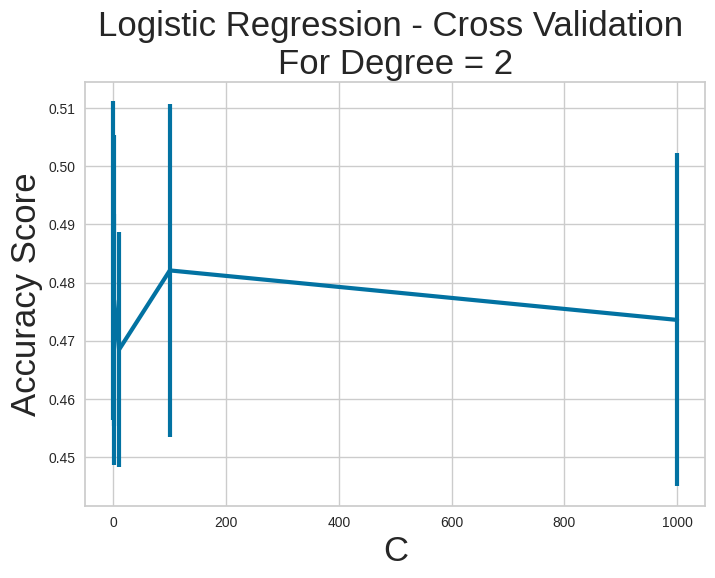

In [32]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
degree_range = [2]

for i in degree_range:
    trans = PolynomialFeatures(degree = i)
    x_poly = trans.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size = 0.2, random_state=(1))
    mean_error = []
    std_error = []
    for c in c_range:
        log_reg = LogisticRegression(C = c, random_state=0, solver='newton-cg',multi_class='multinomial')
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)

        cnf_mtx = metrics.confusion_matrix(y_test, y_pred)
        f1_score = (2*cnf_mtx[1][1])/((2*cnf_mtx[1][1]) + cnf_mtx[0][1] + cnf_mtx[1][0])

        scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')
        mean_error.append(np.array(scores).mean())
        std_error.append(np.array(scores).std())


        print(" Logistic Regression")
        print(" For Degree = ", i)
        print(" For C = ", c)
        print(" Confusion Matrix - \n", cnf_mtx)
        print(' Train accuracy score: ', log_reg.score(x_train, y_train))
        print(' Test accuracy score: ', log_reg.score(x_test, y_test))
        print(" F1 Score = ", f1_score)
        print(" Classification Report\n", classification_report(y_test, y_pred))
        print("\n")

    plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
    plt.xlabel('C', fontsize=25)
    plt.ylabel('Accuracy Score', fontsize=25)
    title_cv = f"Logistic Regression - Cross Validation \nFor Degree = {i}"
    plt.title(title_cv, fontsize=25)
    plt.show()


NN =  1
Train accuracy score: 1.0
Test accuracy score: 0.47189097103918226
NN =  3
Train accuracy score: 0.7040034071550255
Test accuracy score: 0.48722316865417375
NN =  5
Train accuracy score: 0.6418228279386712
Test accuracy score: 0.49744463373083475
NN =  7
Train accuracy score: 0.6162691652470187
Test accuracy score: 0.5229982964224872
NN =  9
Train accuracy score: 0.6013628620102215
Test accuracy score: 0.5059625212947189
NN =  11
Train accuracy score: 0.5971039182282794
Test accuracy score: 0.5110732538330494
NN =  13
Train accuracy score: 0.5907155025553663
Test accuracy score: 0.5178875638841567
NN =  15
Train accuracy score: 0.5826235093696763
Test accuracy score: 0.5076660988074957
NN =  17
Train accuracy score: 0.5724020442930153
Test accuracy score: 0.5212947189097104
NN =  19
Train accuracy score: 0.5681431005110733
Test accuracy score: 0.545144804088586


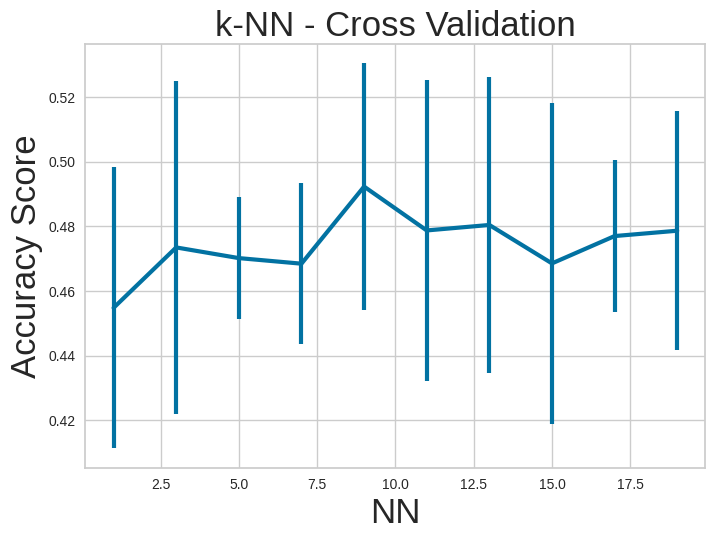

In [33]:
nn_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size = 0.2, random_state=(1))
merr = []
serr = []

for nn in nn_range:
    knn_model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    knn_model.fit(x_train_nn, y_train_nn)
    y_pred_nn = knn_model.predict(x_test_nn)
    print("NN = ", nn)
    print('Train accuracy score:',knn_model.score(x_train_nn, y_train_nn))
    print('Test accuracy score:',knn_model.score(x_test_nn, y_test_nn))

    scores_knn = cross_val_score(knn_model, x_test_nn, y_test_nn, cv=5, scoring='accuracy')
    merr.append(np.array(scores_knn).mean())
    serr.append(np.array(scores_knn).std())

plt.errorbar(nn_range, merr, yerr = serr, linewidth=3)
plt.xlabel('NN', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = f"k-NN - Cross Validation"
plt.title(title_cv, fontsize=25)
plt.show()

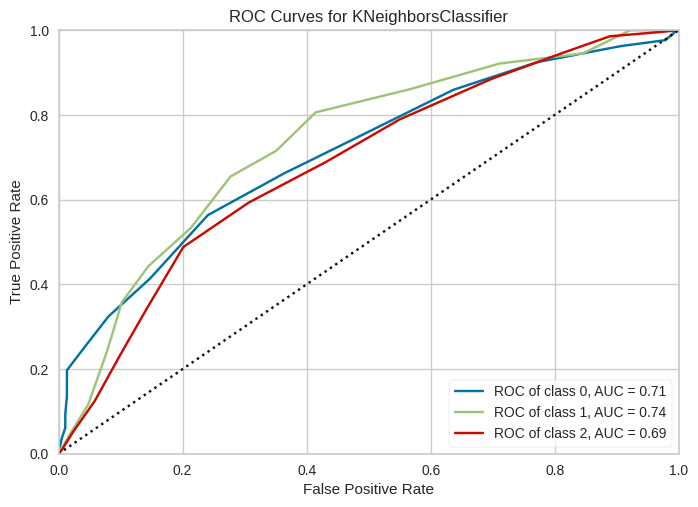

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [34]:
visualizer = ROCAUC(knn_model, classes=["0", "1", "2"], macro=False, micro=False)

visualizer.fit(x_train_nn, y_train_nn)
visualizer.score(x_test_nn, y_test_nn)
visualizer.show()

In [35]:
X = listings[
                ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'bedrooms', 'beds','neighbourhood_cleansed',
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                 'host_identity_verified', 'room_type',
                 'accommodates','price', 'minimum_nights', 'maximum_nights',
                 'bath-products','electric-system',
                 'food-services','house-furniture','house-rules',
                 'kitchen-appliances','parking','recreation','safety',
                 'host_email','host_work_email'] + list(reviews.columns[2:])
]

y = listings[['review_scores_checkin']]
y = (y/y.max())*100

y = y.assign(
    rating_bin_ep = pd.qcut(
        y['review_scores_checkin'],
        q=2,
        duplicates='drop',
        labels=[0,1]
    )
)

In [36]:
y.groupby('rating_bin_ep').min()
y.groupby('rating_bin_ep').max()

review_scores_checkin
rating_bin_ep                       
0                               98.4
1                              100.0

In [37]:
y = y['rating_bin_ep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

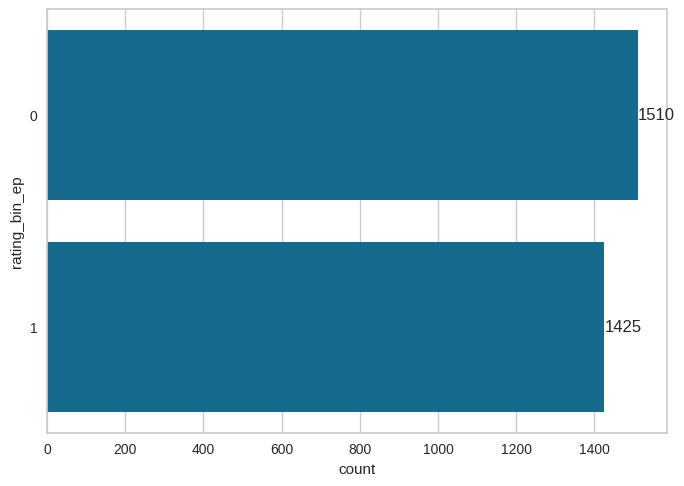

In [38]:
cnt_plt = sns.countplot(y)
cnt_plt.bar_label(cnt_plt.containers[0])
plt.show()

C =  0.001
Train accuracy score: 0.6247160381644707
Test accuracy score: 0.6239782016348774
Mean Squared Error:  0.3760217983651226
C =  0.1
Train accuracy score: 0.671967287596547
Test accuracy score: 0.6539509536784741
Mean Squared Error:  0.3460490463215259
C =  1
Train accuracy score: 0.692412539754657
Test accuracy score: 0.6730245231607629
Mean Squared Error:  0.32697547683923706
C =  10
Train accuracy score: 0.7019536574284416
Test accuracy score: 0.6771117166212534
Mean Squared Error:  0.3228882833787466
C =  100
Train accuracy score: 0.7010449795547479
Test accuracy score: 0.6784741144414169
Mean Squared Error:  0.3215258855585831
C =  1000
Train accuracy score: 0.7010449795547479
Test accuracy score: 0.6784741144414169
Mean Squared Error:  0.3215258855585831


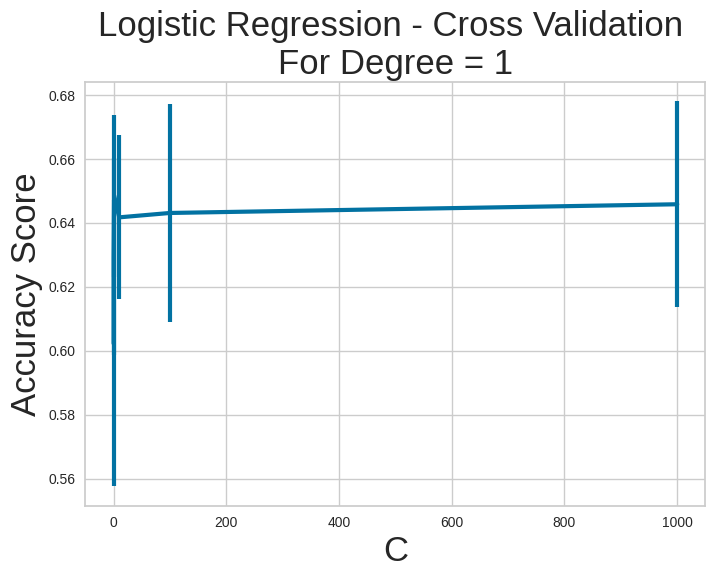

In [39]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
mean_error = []
std_error = []
for c in sorted(c_range):
    logit = LogisticRegression(C=c, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    print("C = ",c)
    print('Train accuracy score:',logit.score(X_train, y_train))
    print('Test accuracy score:',logit.score(X_test, y_test))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    scores = cross_val_score(logit, X_test, y_test, cv=5, scoring='accuracy')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
plt.xlabel('C', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = "Logistic Regression - Cross Validation \nFor Degree = 1"
plt.title(title_cv, fontsize=25)
plt.show()

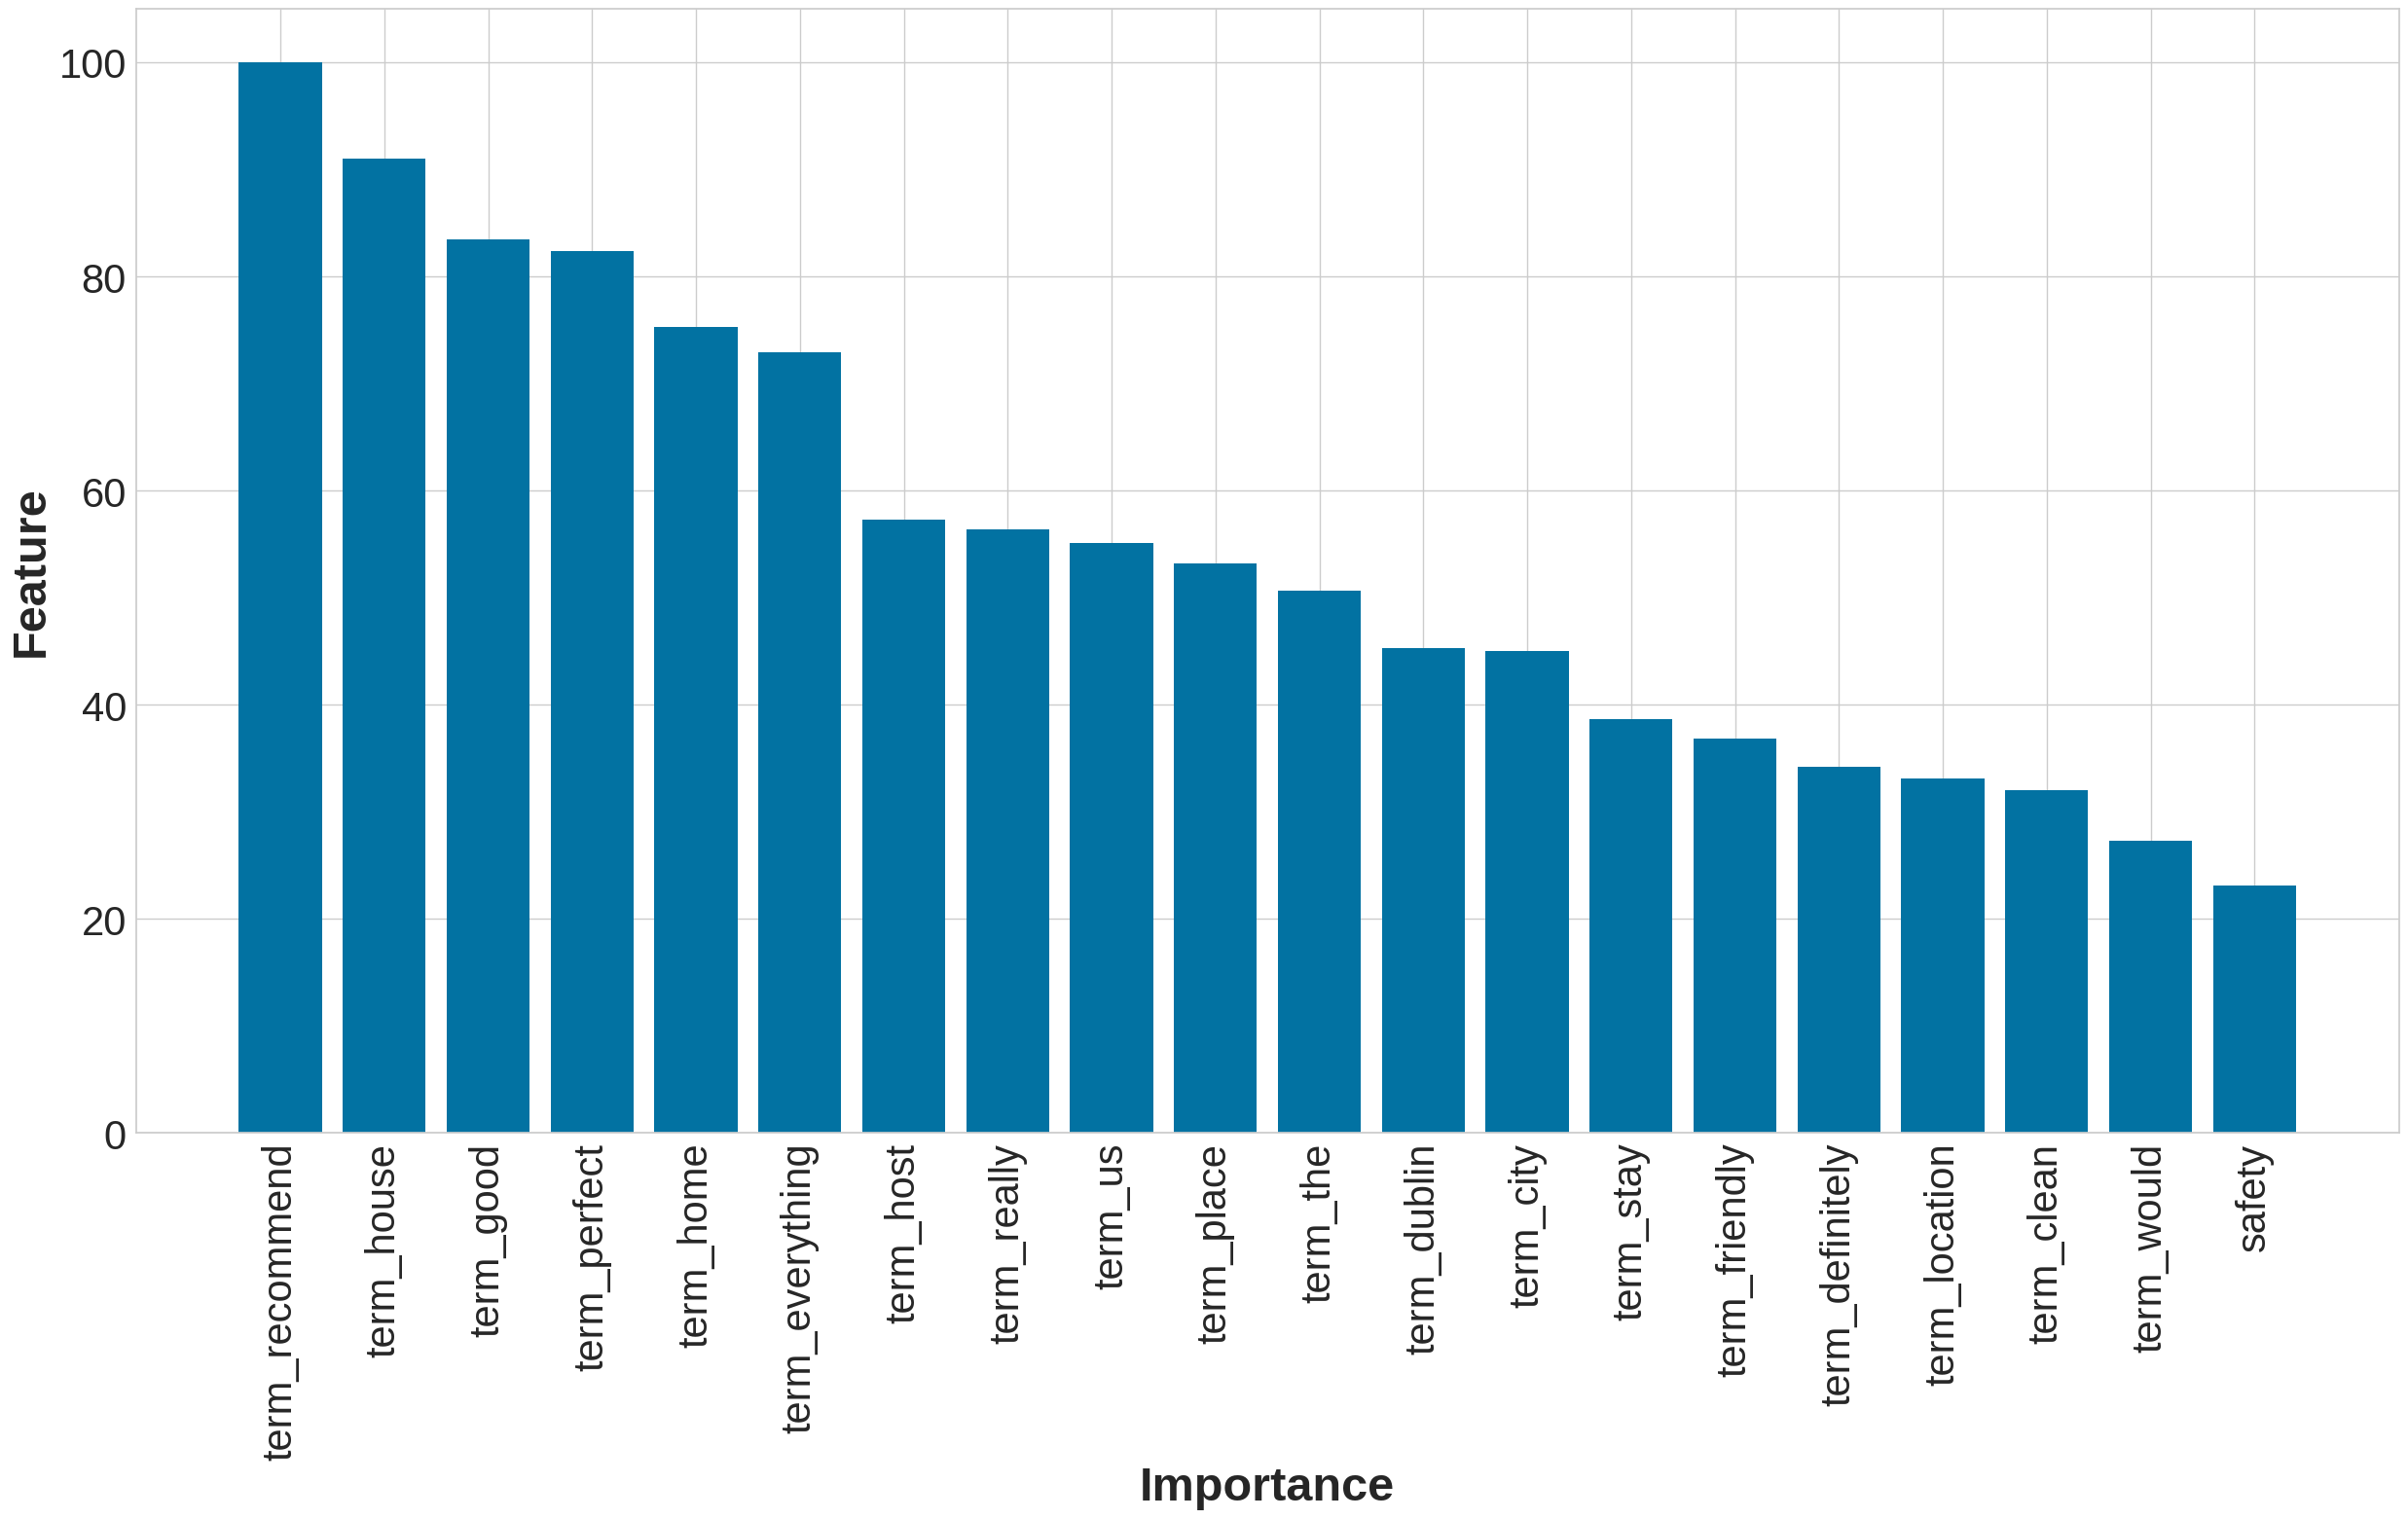

In [40]:
cols = X.columns
cols = np.asarray(cols)

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

 Logistic Regression
 For Degree =  2
 For C =  0.001
 Confusion Matrix - 
 [[216  85]
 [ 97 189]]
 Train accuracy score:  0.772572402044293
 Test accuracy score:  0.6899488926746167
 F1 Score =  0.675
 Classification Report
               precision    recall  f1-score   support

           0       0.69      0.72      0.70       301
           1       0.69      0.66      0.68       286

    accuracy                           0.69       587
   macro avg       0.69      0.69      0.69       587
weighted avg       0.69      0.69      0.69       587



 Logistic Regression
 For Degree =  2
 For C =  0.1
 Confusion Matrix - 
 [[216  85]
 [ 98 188]]
 Train accuracy score:  0.7738500851788757
 Test accuracy score:  0.6882453151618398
 F1 Score =  0.6726296958855098
 Classification Report
               precision    recall  f1-score   support

           0       0.69      0.72      0.70       301
           1       0.69      0.66      0.67       286

    accuracy                           0.69

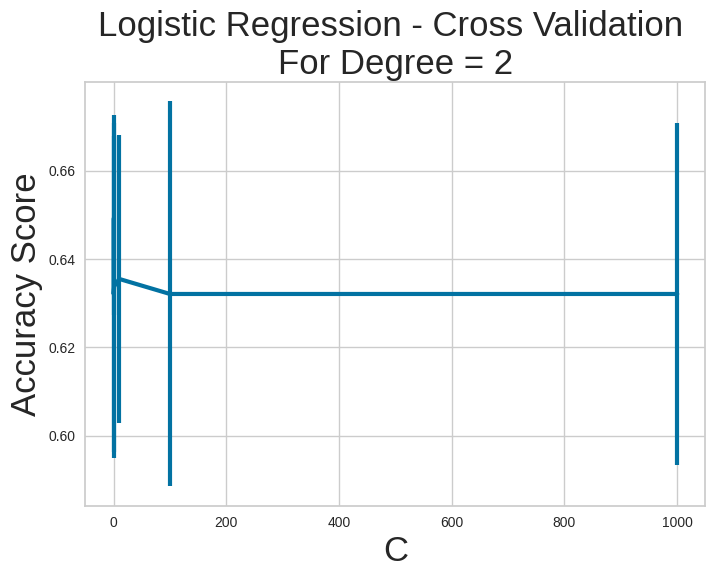

In [41]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
degree_range = [2]

for i in degree_range:
    trans = PolynomialFeatures(degree = i)
    x_poly = trans.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size = 0.2, random_state=(1))
    mean_error = []
    std_error = []
    for c in c_range:
        log_reg = LogisticRegression(C = c, random_state=0, solver='newton-cg',multi_class='multinomial')
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)

        cnf_mtx = metrics.confusion_matrix(y_test, y_pred)
        f1_score = (2*cnf_mtx[1][1])/((2*cnf_mtx[1][1]) + cnf_mtx[0][1] + cnf_mtx[1][0])

        scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')
        mean_error.append(np.array(scores).mean())
        std_error.append(np.array(scores).std())


        print(" Logistic Regression")
        print(" For Degree = ", i)
        print(" For C = ", c)
        print(" Confusion Matrix - \n", cnf_mtx)
        print(' Train accuracy score: ', log_reg.score(x_train, y_train))
        print(' Test accuracy score: ', log_reg.score(x_test, y_test))
        print(" F1 Score = ", f1_score)
        print(" Classification Report\n", classification_report(y_test, y_pred))
        print("\n")

    plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
    plt.xlabel('C', fontsize=25)
    plt.ylabel('Accuracy Score', fontsize=25)
    title_cv = f"Logistic Regression - Cross Validation \nFor Degree = {i}"
    plt.title(title_cv, fontsize=25)
    plt.show()

NN =  1
Train accuracy score: 1.0
Test accuracy score: 0.5604770017035775
NN =  3
Train accuracy score: 0.784923339011925
Test accuracy score: 0.5587734241908007
NN =  5
Train accuracy score: 0.7304088586030665
Test accuracy score: 0.5604770017035775
NN =  7
Train accuracy score: 0.7061328790459966
Test accuracy score: 0.565587734241908
NN =  9
Train accuracy score: 0.6933560477001703
Test accuracy score: 0.5979557069846678
NN =  11
Train accuracy score: 0.6793015332197615
Test accuracy score: 0.616695059625213
NN =  13
Train accuracy score: 0.6622657580919932
Test accuracy score: 0.6201022146507666
NN =  15
Train accuracy score: 0.6609880749574105
Test accuracy score: 0.5928449744463373
NN =  17
Train accuracy score: 0.659710391822828
Test accuracy score: 0.596252129471891
NN =  19
Train accuracy score: 0.6712095400340715
Test accuracy score: 0.5979557069846678


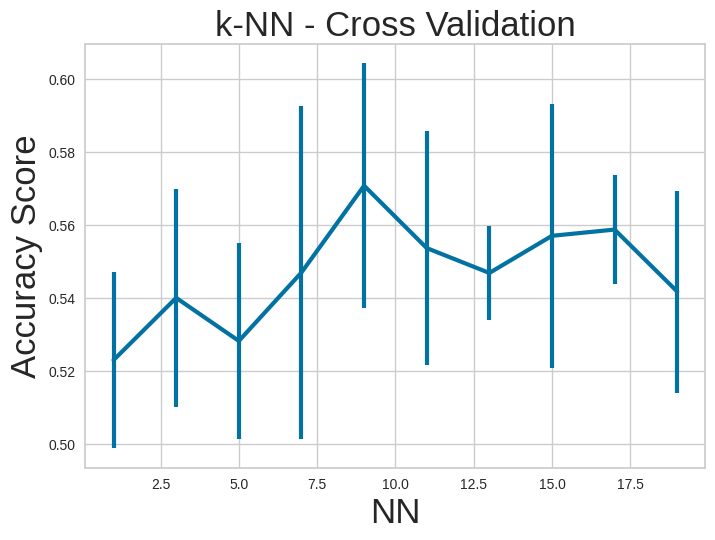

In [42]:
nn_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size = 0.2, random_state=(1))
merr = []
serr = []

for nn in nn_range:
    knn_model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    knn_model.fit(x_train_nn, y_train_nn)
    y_pred_nn = knn_model.predict(x_test_nn)
    print("NN = ", nn)
    print('Train accuracy score:',knn_model.score(x_train_nn, y_train_nn))
    print('Test accuracy score:',knn_model.score(x_test_nn, y_test_nn))

    scores_knn = cross_val_score(knn_model, x_test_nn, y_test_nn, cv=5, scoring='accuracy')
    merr.append(np.array(scores_knn).mean())
    serr.append(np.array(scores_knn).std())

plt.errorbar(nn_range, merr, yerr = serr, linewidth=3)
plt.xlabel('NN', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = f"k-NN - Cross Validation"
plt.title(title_cv, fontsize=25)
plt.show()

In [43]:
X = listings[
                ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'bedrooms', 'beds','neighbourhood_cleansed',
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                 'host_identity_verified', 'room_type',
                 'accommodates','price', 'minimum_nights', 'maximum_nights',
                 'bath-products','electric-system',
                 'food-services','house-furniture','house-rules',
                 'kitchen-appliances','parking','recreation','safety',
                 'host_email','host_work_email'] + list(reviews.columns[2:])
]

y = listings[['review_scores_cleanliness']]
y = (y/y.max())*100

y = y.assign(
    rating_bin_ep = pd.qcut(
        y['review_scores_cleanliness'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)

In [44]:
y.groupby('rating_bin_ep').min()
y.groupby('rating_bin_ep').max()

review_scores_cleanliness
rating_bin_ep                           
0                                   94.2
1                                   98.4
2                                  100.0

In [45]:
y = y['rating_bin_ep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

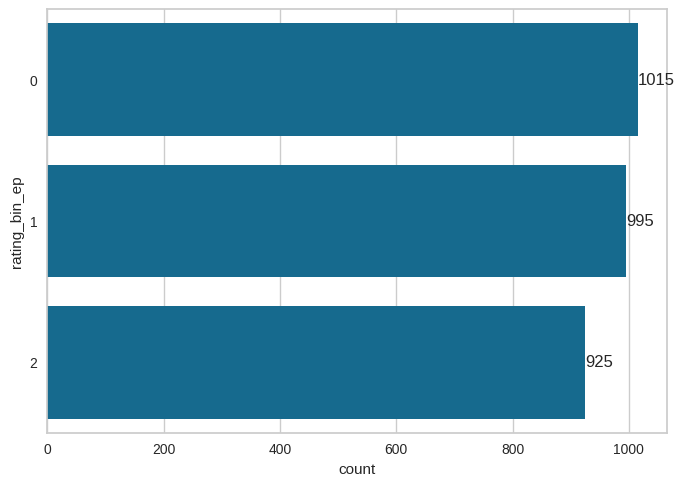

In [46]:
cnt_plt = sns.countplot(y)
cnt_plt.bar_label(cnt_plt.containers[0])
plt.show()

C =  0.001
Train accuracy score: 0.4911403907314857
Test accuracy score: 0.5
Mean Squared Error:  1.0190735694822888
C =  0.1
Train accuracy score: 0.5442980463425715
Test accuracy score: 0.5381471389645777
Mean Squared Error:  0.9359673024523161
C =  1
Train accuracy score: 0.562925942753294
Test accuracy score: 0.5544959128065395
Mean Squared Error:  0.8256130790190735
C =  10
Train accuracy score: 0.5661063153112221
Test accuracy score: 0.5735694822888283
Mean Squared Error:  0.7656675749318801
C =  100
Train accuracy score: 0.5661063153112221
Test accuracy score: 0.5708446866485014
Mean Squared Error:  0.7683923705722071
C =  1000
Train accuracy score: 0.5656519763743753
Test accuracy score: 0.5708446866485014
Mean Squared Error:  0.7683923705722071


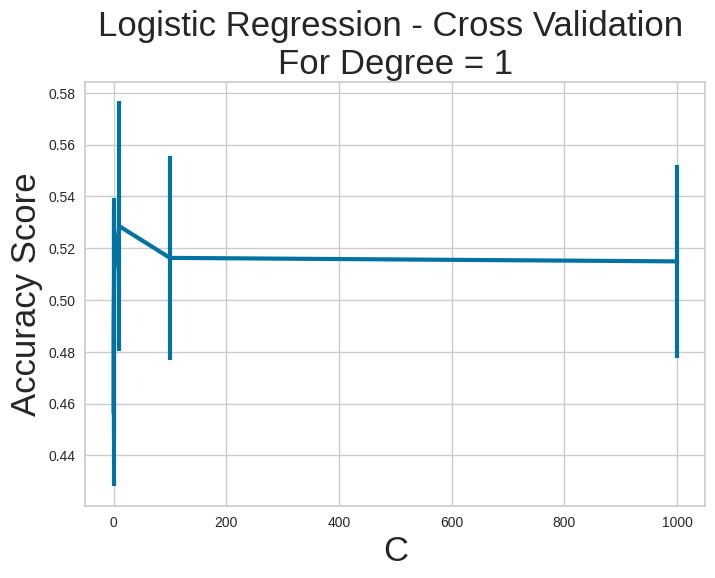

In [47]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
mean_error = []
std_error = []
for c in sorted(c_range):
    logit = LogisticRegression(C=c, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    print("C = ",c)
    print('Train accuracy score:',logit.score(X_train, y_train))
    print('Test accuracy score:',logit.score(X_test, y_test))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    scores = cross_val_score(logit, X_test, y_test, cv=5, scoring='accuracy')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
plt.xlabel('C', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = "Logistic Regression - Cross Validation \nFor Degree = 1"
plt.title(title_cv, fontsize=25)
plt.show()

In [48]:
cols = X.columns
cols = np.asarray(cols)

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[1])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[2])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

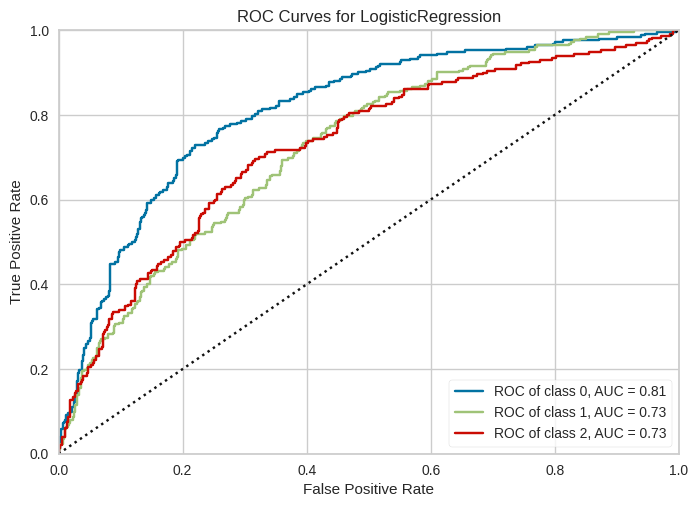

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [49]:
visualizer = ROCAUC(logit, classes=["0", "1", "2"], macro=False, micro=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [51]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
degree_range = [2]

for i in degree_range:
    trans = PolynomialFeatures(degree = i)
    x_poly = trans.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size = 0.2, random_state=(1))
    mean_error = []
    std_error = []
    for c in c_range:
        log_reg = LogisticRegression(C = c, random_state=0, solver='newton-cg',multi_class='multinomial')
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)

        cnf_mtx = metrics.confusion_matrix(y_test, y_pred)
        f1_score = (2*cnf_mtx[1][1])/((2*cnf_mtx[1][1]) + cnf_mtx[0][1] + cnf_mtx[1][0])

        scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')
        mean_error.append(np.array(scores).mean())
        std_error.append(np.array(scores).std())


        print(" Logistic Regression")
        print(" For Degree = ", i)
        print(" For C = ", c)
        print(" Confusion Matrix - \n", cnf_mtx)
        print(' Train accuracy score: ', log_reg.score(x_train, y_train))
        print(' Test accuracy score: ', log_reg.score(x_test, y_test))
        print(" F1 Score = ", f1_score)
        print(" Classification Report\n", classification_report(y_test, y_pred))
        print("\n")

    plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
    plt.xlabel('C', fontsize=25)
    plt.ylabel('Accuracy Score', fontsize=25)
    title_cv = f"Logistic Regression - Cross Validation \nFor Degree = {i}"
    plt.title(title_cv, fontsize=25)
    plt.show()

 Logistic Regression
 For Degree =  2
 For C =  0.001
 Confusion Matrix - 
 [[125  40  36]
 [ 66  77  53]
 [ 43  53  94]]
 Train accuracy score:  0.6656729131175468
 Test accuracy score:  0.504258943781942
 F1 Score =  0.5923076923076923
 Classification Report
               precision    recall  f1-score   support

           0       0.53      0.62      0.57       201
           1       0.45      0.39      0.42       196
           2       0.51      0.49      0.50       190

    accuracy                           0.50       587
   macro avg       0.50      0.50      0.50       587
weighted avg       0.50      0.50      0.50       587



 Logistic Regression
 For Degree =  2
 For C =  0.1
 Confusion Matrix - 
 [[127  42  32]
 [ 63  79  54]
 [ 44  53  93]]
 Train accuracy score:  0.669931856899489
 Test accuracy score:  0.5093696763202725
 F1 Score =  0.6007604562737643
 Classification Report
               precision    recall  f1-score   support

           0       0.54      0.63      0

In [52]:
nn_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size = 0.2, random_state=(1))
merr = []
serr = []

for nn in nn_range:
    knn_model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    knn_model.fit(x_train_nn, y_train_nn)
    y_pred_nn = knn_model.predict(x_test_nn)
    print("NN = ", nn)
    print('Train accuracy score:',knn_model.score(x_train_nn, y_train_nn))
    print('Test accuracy score:',knn_model.score(x_test_nn, y_test_nn))

    scores_knn = cross_val_score(knn_model, x_test_nn, y_test_nn, cv=5, scoring='accuracy')
    merr.append(np.array(scores_knn).mean())
    serr.append(np.array(scores_knn).std())

plt.errorbar(nn_range, merr, yerr = serr, linewidth=3)
plt.xlabel('NN', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = f"k-NN - Cross Validation"
plt.title(title_cv, fontsize=25)
plt.show()

NN =  1
Train accuracy score: 1.0
Test accuracy score: 0.42759795570698467
NN =  3
Train accuracy score: 0.684412265758092
Test accuracy score: 0.42078364565587734
NN =  5
Train accuracy score: 0.6226575809199318
Test accuracy score: 0.424190800681431
NN =  7
Train accuracy score: 0.5958262350936968
Test accuracy score: 0.42759795570698467
NN =  9
Train accuracy score: 0.5745315161839863
Test accuracy score: 0.424190800681431
NN =  11
Train accuracy score: 0.5668654173764907
Test accuracy score: 0.4071550255536627
NN =  13
Train accuracy score: 0.553236797274276
Test accuracy score: 0.41737649063032367
NN =  15
Train accuracy score: 0.5485519591141397
Test accuracy score: 0.4122657580919932
NN =  17
Train accuracy score: 0.5421635434412265
Test accuracy score: 0.4122657580919932
NN =  19
Train accuracy score: 0.5362010221465077
Test accuracy score: 0.42248722316865417


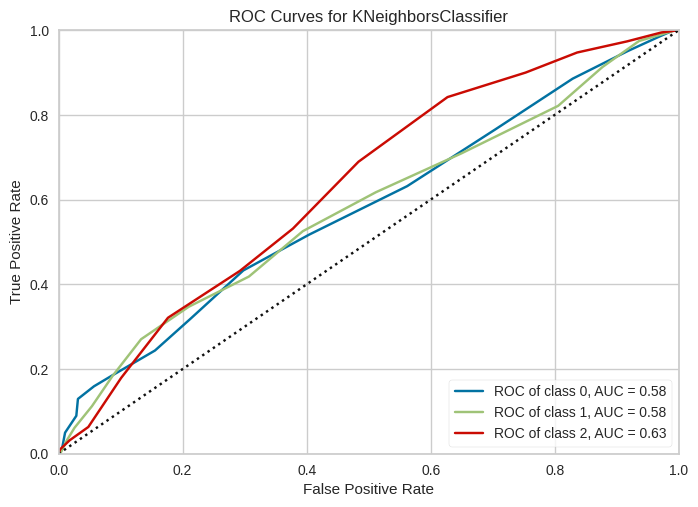

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [53]:
visualizer = ROCAUC(knn_model, classes=["0", "1", "2"], macro=False, micro=False)

visualizer.fit(x_train_nn, y_train_nn)
visualizer.score(x_test_nn, y_test_nn)
visualizer.show()

In [54]:
X = listings[
                ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'bedrooms', 'beds','neighbourhood_cleansed',
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                 'host_identity_verified', 'room_type',
                 'accommodates','price', 'minimum_nights', 'maximum_nights',
                 'bath-products','electric-system',
                 'food-services','house-furniture','house-rules',
                 'kitchen-appliances','parking','recreation','safety',
                 'host_email','host_work_email'] + list(reviews.columns[2:])
]

y = listings[['review_scores_communication']]
y = (y/y.max())*100

y = y.assign(
    rating_bin_ep = pd.qcut(
        y['review_scores_communication'],
        q=2,
        duplicates='drop',
        labels=[0,1]
    )
)

In [55]:
y.groupby('rating_bin_ep').min()
y.groupby('rating_bin_ep').max()

review_scores_communication
rating_bin_ep                             
0                                     98.8
1                                    100.0

In [56]:
y = y['rating_bin_ep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [57]:
cnt_plt = sns.countplot(y)
cnt_plt.bar_label(cnt_plt.containers[0])
plt.show()

C =  0.001
Train accuracy score: 0.6506133575647433
Test accuracy score: 0.6512261580381471
Mean Squared Error:  0.34877384196185285
C =  0.1
Train accuracy score: 0.7092230804179919
Test accuracy score: 0.6662125340599455
Mean Squared Error:  0.3337874659400545
C =  1
Train accuracy score: 0.7210358927760109
Test accuracy score: 0.6648501362397821
Mean Squared Error:  0.335149863760218
C =  10
Train accuracy score: 0.7174011812812358
Test accuracy score: 0.6634877384196185
Mean Squared Error:  0.33651226158038144
C =  100
Train accuracy score: 0.716492503407542
Test accuracy score: 0.6662125340599455
Mean Squared Error:  0.3337874659400545
C =  1000
Train accuracy score: 0.7169468423443889
Test accuracy score: 0.6648501362397821
Mean Squared Error:  0.335149863760218


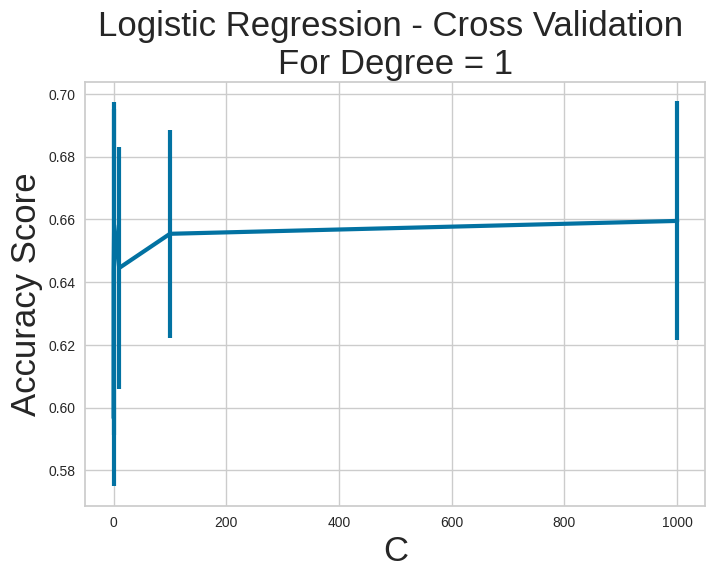

In [58]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
mean_error = []
std_error = []
for c in sorted(c_range):
    logit = LogisticRegression(C=c, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    print("C = ",c)
    print('Train accuracy score:',logit.score(X_train, y_train))
    print('Test accuracy score:',logit.score(X_test, y_test))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    scores = cross_val_score(logit, X_test, y_test, cv=5, scoring='accuracy')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
plt.xlabel('C', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = "Logistic Regression - Cross Validation \nFor Degree = 1"
plt.title(title_cv, fontsize=25)
plt.show()

In [59]:
cols = X.columns
cols = np.asarray(cols)

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

 Logistic Regression
 For Degree =  2
 For C =  0.001
 Confusion Matrix - 
 [[216  84]
 [ 91 196]]
 Train accuracy score:  0.7913117546848382
 Test accuracy score:  0.7018739352640545
 F1 Score =  0.691358024691358
 Classification Report
               precision    recall  f1-score   support

           0       0.70      0.72      0.71       300
           1       0.70      0.68      0.69       287

    accuracy                           0.70       587
   macro avg       0.70      0.70      0.70       587
weighted avg       0.70      0.70      0.70       587



 Logistic Regression
 For Degree =  2
 For C =  0.1
 Confusion Matrix - 
 [[216  84]
 [ 92 195]]
 Train accuracy score:  0.7964224872231687
 Test accuracy score:  0.7001703577512777
 F1 Score =  0.6890459363957597
 Classification Report
               precision    recall  f1-score   support

           0       0.70      0.72      0.71       300
           1       0.70      0.68      0.69       287

    accuracy                  

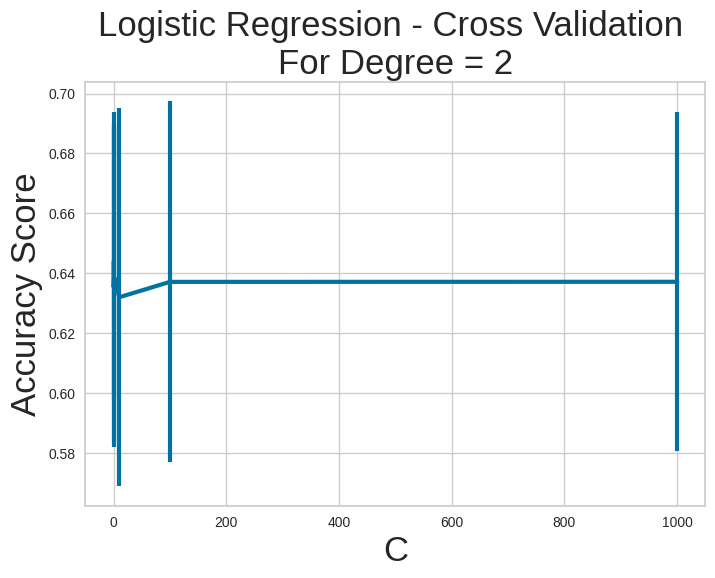

In [60]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
degree_range = [2]

for i in degree_range:
    trans = PolynomialFeatures(degree = i)
    x_poly = trans.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size = 0.2, random_state=(1))
    mean_error = []
    std_error = []
    for c in c_range:
        log_reg = LogisticRegression(C = c, random_state=0, solver='newton-cg',multi_class='multinomial')
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)

        cnf_mtx = metrics.confusion_matrix(y_test, y_pred)
        f1_score = (2*cnf_mtx[1][1])/((2*cnf_mtx[1][1]) + cnf_mtx[0][1] + cnf_mtx[1][0])

        scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')
        mean_error.append(np.array(scores).mean())
        std_error.append(np.array(scores).std())


        print(" Logistic Regression")
        print(" For Degree = ", i)
        print(" For C = ", c)
        print(" Confusion Matrix - \n", cnf_mtx)
        print(' Train accuracy score: ', log_reg.score(x_train, y_train))
        print(' Test accuracy score: ', log_reg.score(x_test, y_test))
        print(" F1 Score = ", f1_score)
        print(" Classification Report\n", classification_report(y_test, y_pred))
        print("\n")

    plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
    plt.xlabel('C', fontsize=25)
    plt.ylabel('Accuracy Score', fontsize=25)
    title_cv = f"Logistic Regression - Cross Validation \nFor Degree = {i}"
    plt.title(title_cv, fontsize=25)
    plt.show()

In [61]:
nn_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size = 0.2, random_state=(1))
merr = []
serr = []

for nn in nn_range:
    knn_model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    knn_model.fit(x_train_nn, y_train_nn)
    y_pred_nn = knn_model.predict(x_test_nn)
    print("NN = ", nn)
    print('Train accuracy score:',knn_model.score(x_train_nn, y_train_nn))
    print('Test accuracy score:',knn_model.score(x_test_nn, y_test_nn))

    scores_knn = cross_val_score(knn_model, x_test_nn, y_test_nn, cv=5, scoring='accuracy')
    merr.append(np.array(scores_knn).mean())
    serr.append(np.array(scores_knn).std())

plt.errorbar(nn_range, merr, yerr = serr, linewidth=3)
plt.xlabel('NN', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = f"k-NN - Cross Validation"
plt.title(title_cv, fontsize=25)
plt.show()

NN =  1
Train accuracy score: 1.0
Test accuracy score: 0.5979557069846678
NN =  3
Train accuracy score: 0.7998296422487223
Test accuracy score: 0.6422487223168655
NN =  5
Train accuracy score: 0.7482964224872232
Test accuracy score: 0.6320272572402045
NN =  7
Train accuracy score: 0.7338160136286201
Test accuracy score: 0.6337308347529813
NN =  9
Train accuracy score: 0.7074105621805792
Test accuracy score: 0.6218057921635435
NN =  11
Train accuracy score: 0.688671209540034
Test accuracy score: 0.6286201022146508
NN =  13
Train accuracy score: 0.682282793867121
Test accuracy score: 0.6473594548551959
NN =  15
Train accuracy score: 0.6780238500851788
Test accuracy score: 0.6354344122657581
NN =  17
Train accuracy score: 0.6733390119250426
Test accuracy score: 0.6405451448040886
NN =  19
Train accuracy score: 0.6716354344122658
Test accuracy score: 0.637137989778535


In [62]:
X = listings[
                ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'bedrooms', 'beds','neighbourhood_cleansed',
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                 'host_identity_verified', 'room_type',
                 'accommodates','price', 'minimum_nights', 'maximum_nights',
                 'bath-products','electric-system',
                 'food-services','house-furniture','house-rules',
                 'kitchen-appliances','parking','recreation','safety',
                 'host_email','host_work_email'] + list(reviews.columns[2:])
]

y = listings[['review_scores_location']]
y = (y/y.max())*100

y = y.assign(
    rating_bin_ep = pd.qcut(
        y['review_scores_location'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)

In [63]:
y.groupby('rating_bin_ep').min()
y.groupby('rating_bin_ep').max()

review_scores_location
rating_bin_ep                        
0                                94.4
1                                97.8
2                               100.0

In [64]:
y = y['rating_bin_ep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

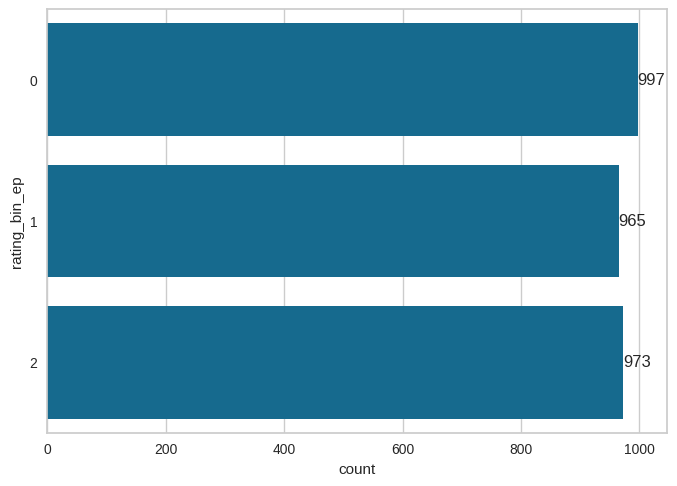

In [65]:
cnt_plt = sns.countplot(y)
cnt_plt.bar_label(cnt_plt.containers[0])
plt.show()

C =  0.001
Train accuracy score: 0.46251703771013175
Test accuracy score: 0.4209809264305177
Mean Squared Error:  1.159400544959128
C =  0.1
Train accuracy score: 0.5056792367105861
Test accuracy score: 0.4659400544959128
Mean Squared Error:  1.053133514986376
C =  1
Train accuracy score: 0.5365742844161745
Test accuracy score: 0.4768392370572207
Mean Squared Error:  0.9727520435967303
C =  10
Train accuracy score: 0.5474784189004998
Test accuracy score: 0.48637602179836514
Mean Squared Error:  0.9550408719346049
C =  100
Train accuracy score: 0.5488414357110404
Test accuracy score: 0.48637602179836514
Mean Squared Error:  0.946866485013624
C =  1000
Train accuracy score: 0.5488414357110404
Test accuracy score: 0.48637602179836514
Mean Squared Error:  0.946866485013624


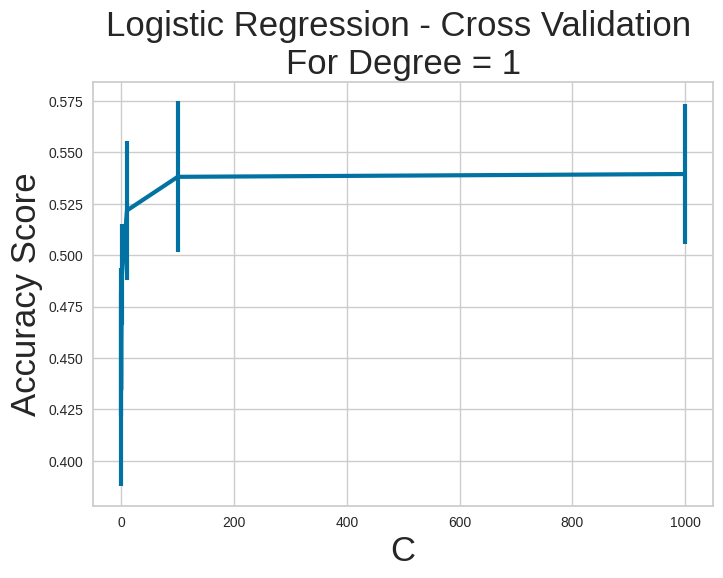

In [66]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
mean_error = []
std_error = []
for c in sorted(c_range):
    logit = LogisticRegression(C=c, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    print("C = ",c)
    print('Train accuracy score:',logit.score(X_train, y_train))
    print('Test accuracy score:',logit.score(X_test, y_test))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    scores = cross_val_score(logit, X_test, y_test, cv=5, scoring='accuracy')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
plt.xlabel('C', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = "Logistic Regression - Cross Validation \nFor Degree = 1"
plt.title(title_cv, fontsize=25)
plt.show()

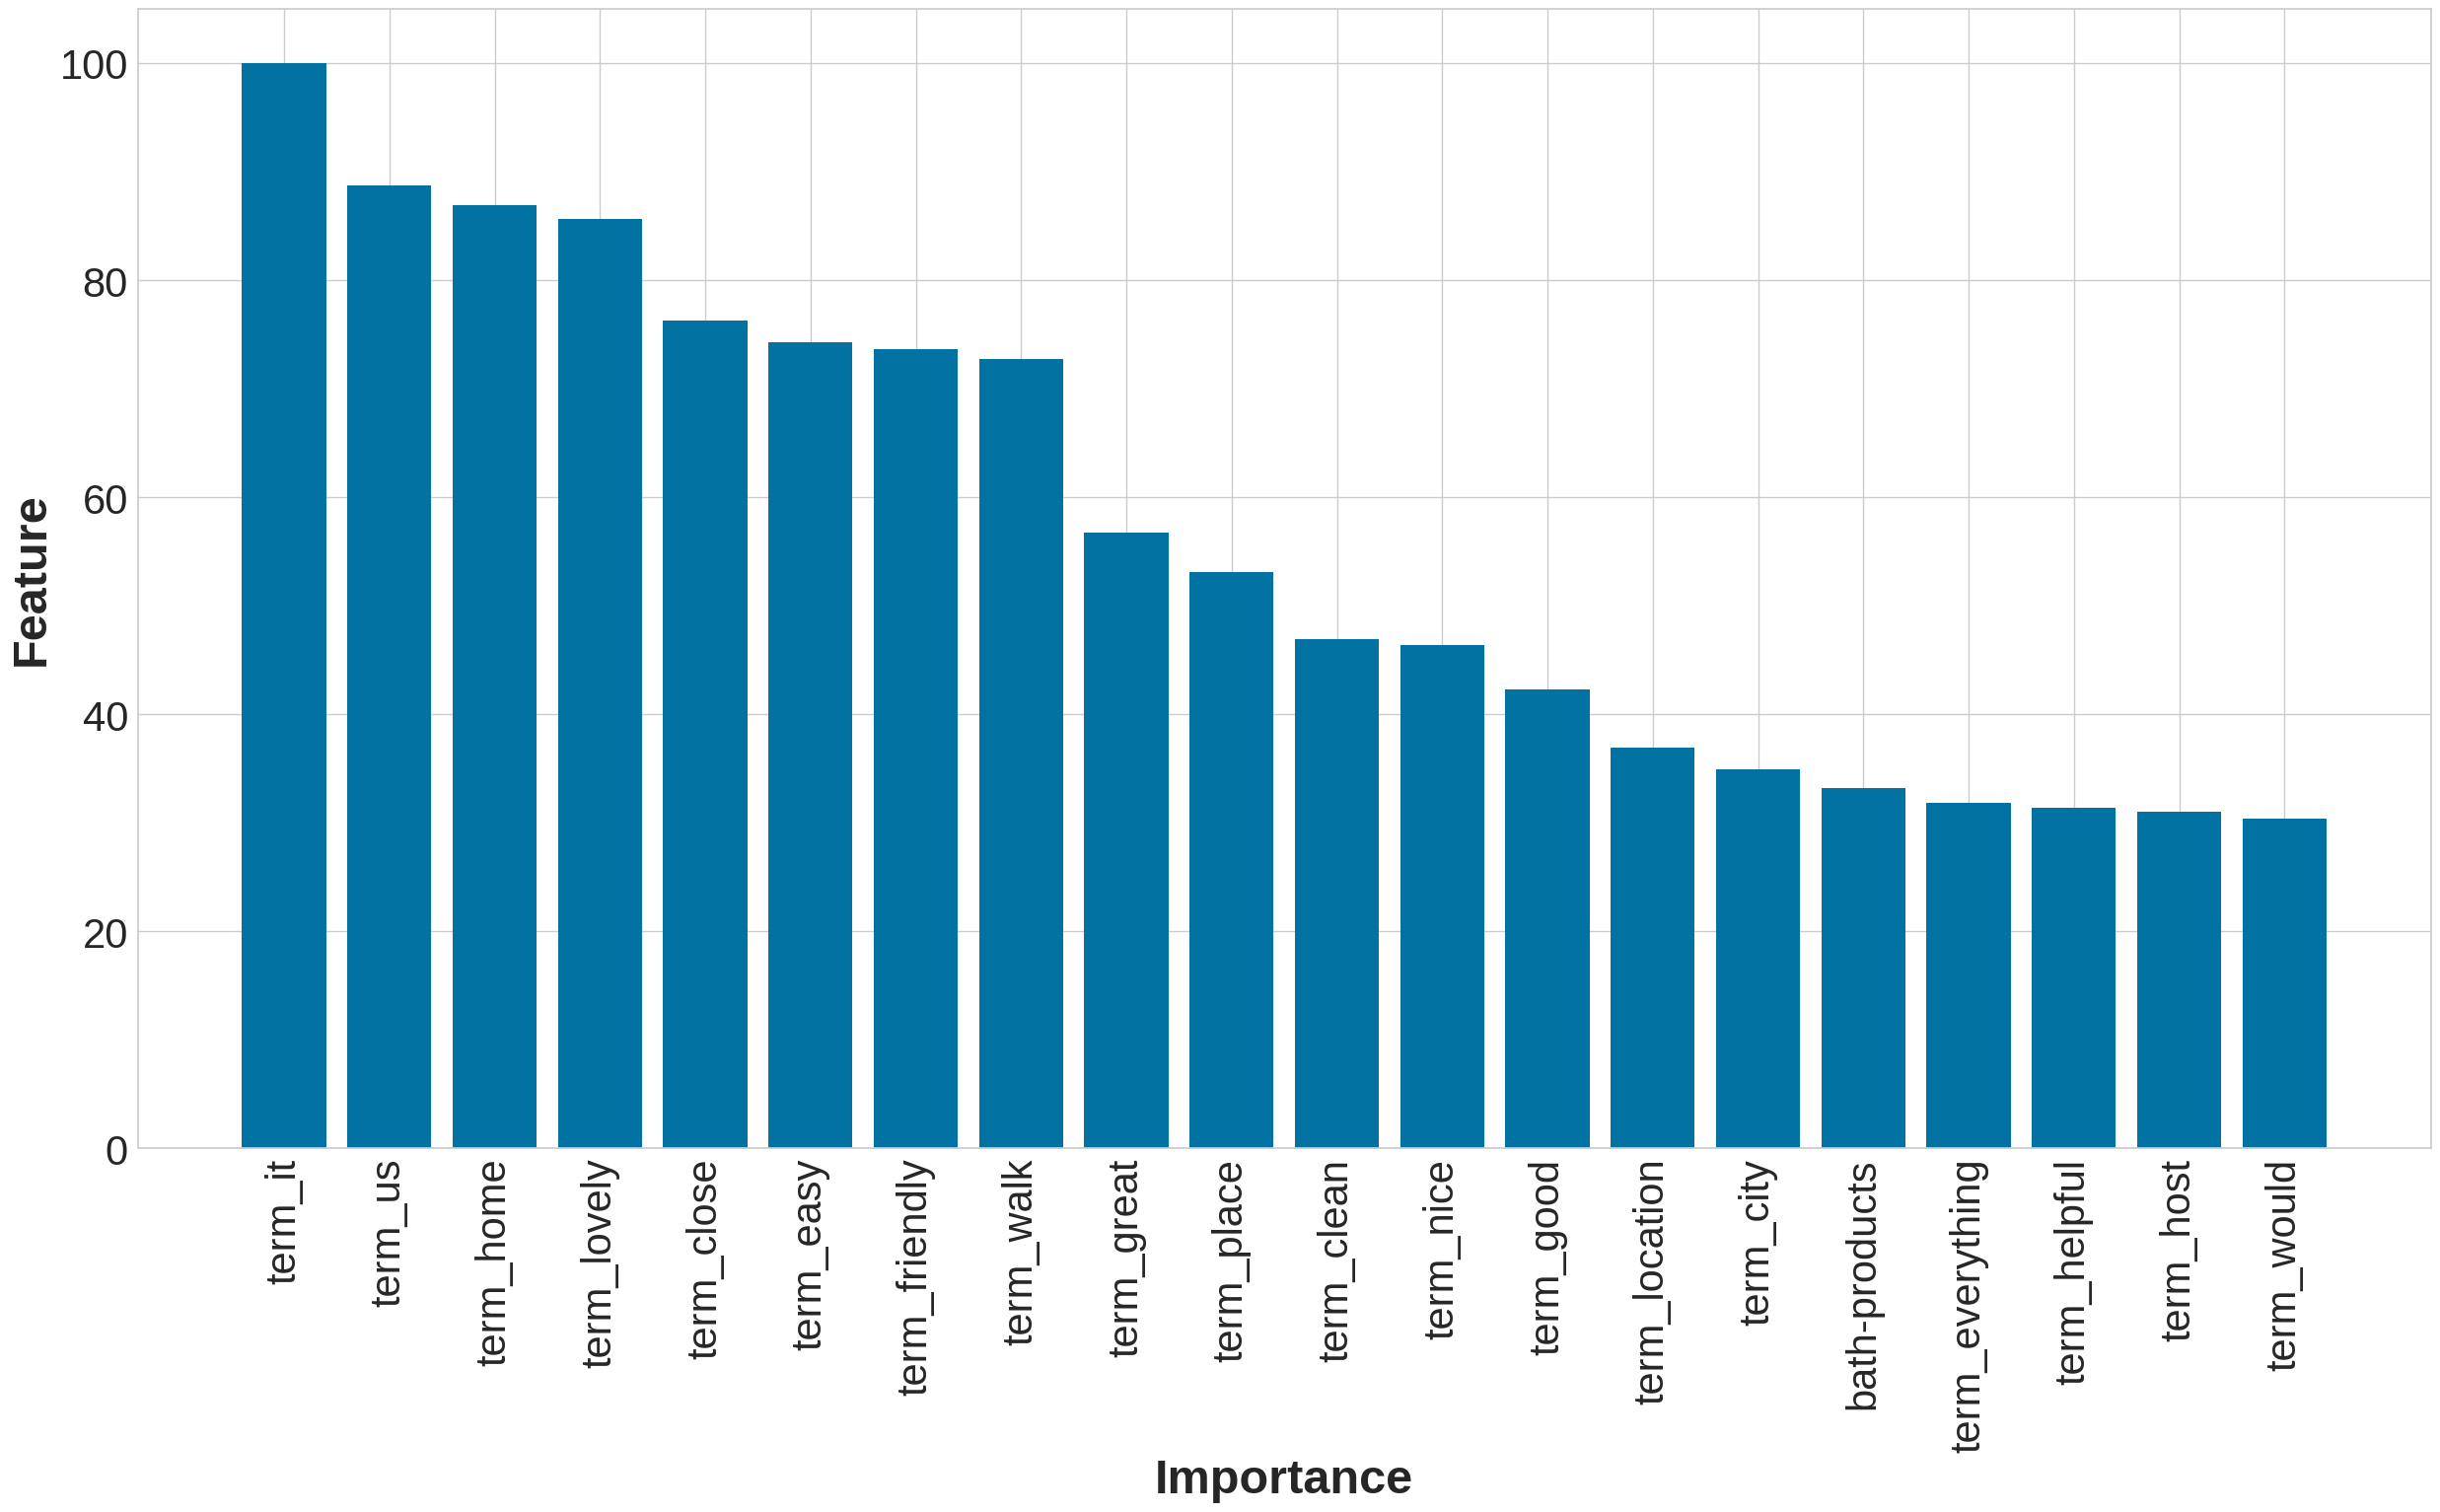

In [67]:
cols = X.columns
cols = np.asarray(cols)

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[1])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[2])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

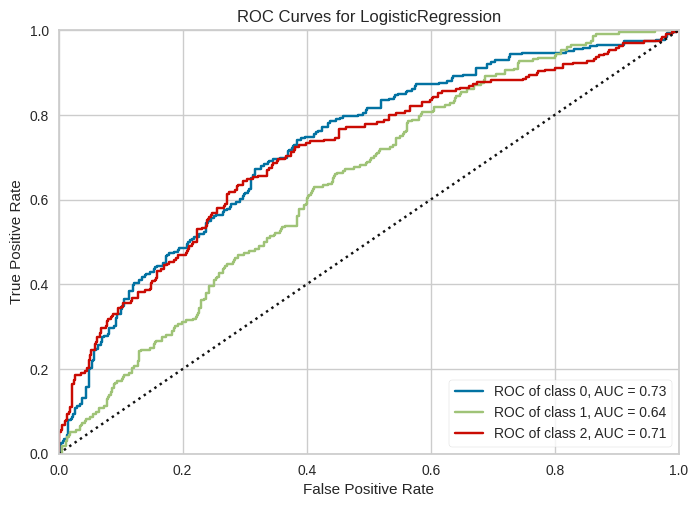

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [68]:
visualizer = ROCAUC(logit, classes=["0", "1", "2"], macro=False, micro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

 Logistic Regression
 For Degree =  2
 For C =  0.001
 Confusion Matrix - 
 [[118  42  48]
 [ 45  90  58]
 [ 26  53 107]]
 Train accuracy score:  0.6409710391822828
 Test accuracy score:  0.5366269165247018
 F1 Score =  0.6741573033707865
 Classification Report
               precision    recall  f1-score   support

           0       0.62      0.57      0.59       208
           1       0.49      0.47      0.48       193
           2       0.50      0.58      0.54       186

    accuracy                           0.54       587
   macro avg       0.54      0.54      0.54       587
weighted avg       0.54      0.54      0.54       587



 Logistic Regression
 For Degree =  2
 For C =  0.1
 Confusion Matrix - 
 [[119  41  48]
 [ 46  96  51]
 [ 26  60 100]]
 Train accuracy score:  0.6486371379897785
 Test accuracy score:  0.5366269165247018
 F1 Score =  0.6881720430107527
 Classification Report
               precision    recall  f1-score   support

           0       0.62      0.57     

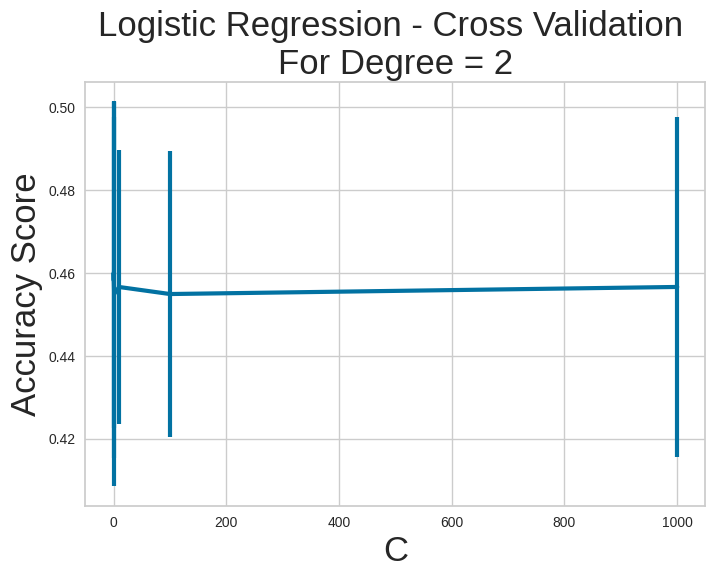

In [69]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
degree_range = [2]

for i in degree_range:
    trans = PolynomialFeatures(degree = i)
    x_poly = trans.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size = 0.2, random_state=(1))
    mean_error = []
    std_error = []
    for c in c_range:
        log_reg = LogisticRegression(C = c, random_state=0, solver='newton-cg',multi_class='multinomial')
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)

        cnf_mtx = metrics.confusion_matrix(y_test, y_pred)
        f1_score = (2*cnf_mtx[1][1])/((2*cnf_mtx[1][1]) + cnf_mtx[0][1] + cnf_mtx[1][0])

        scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')
        mean_error.append(np.array(scores).mean())
        std_error.append(np.array(scores).std())


        print(" Logistic Regression")
        print(" For Degree = ", i)
        print(" For C = ", c)
        print(" Confusion Matrix - \n", cnf_mtx)
        print(' Train accuracy score: ', log_reg.score(x_train, y_train))
        print(' Test accuracy score: ', log_reg.score(x_test, y_test))
        print(" F1 Score = ", f1_score)
        print(" Classification Report\n", classification_report(y_test, y_pred))
        print("\n")

    plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
    plt.xlabel('C', fontsize=25)
    plt.ylabel('Accuracy Score', fontsize=25)
    title_cv = f"Logistic Regression - Cross Validation \nFor Degree = {i}"
    plt.title(title_cv, fontsize=25)
    plt.show()


NN =  1
Train accuracy score: 1.0
Test accuracy score: 0.43781942078364566
NN =  3
Train accuracy score: 0.6793015332197615
Test accuracy score: 0.4190800681431005
NN =  5
Train accuracy score: 0.6026405451448041
Test accuracy score: 0.40545144804088584
NN =  7
Train accuracy score: 0.5856047700170358
Test accuracy score: 0.434412265758092
NN =  9
Train accuracy score: 0.5604770017035775
Test accuracy score: 0.4122657580919932
NN =  11
Train accuracy score: 0.5379045996592845
Test accuracy score: 0.4088586030664395
NN =  13
Train accuracy score: 0.5276831345826235
Test accuracy score: 0.41396933560477
NN =  15
Train accuracy score: 0.510221465076661
Test accuracy score: 0.4122657580919932
NN =  17
Train accuracy score: 0.5059625212947189
Test accuracy score: 0.44122657580919933
NN =  19
Train accuracy score: 0.512350936967632
Test accuracy score: 0.4395229982964225


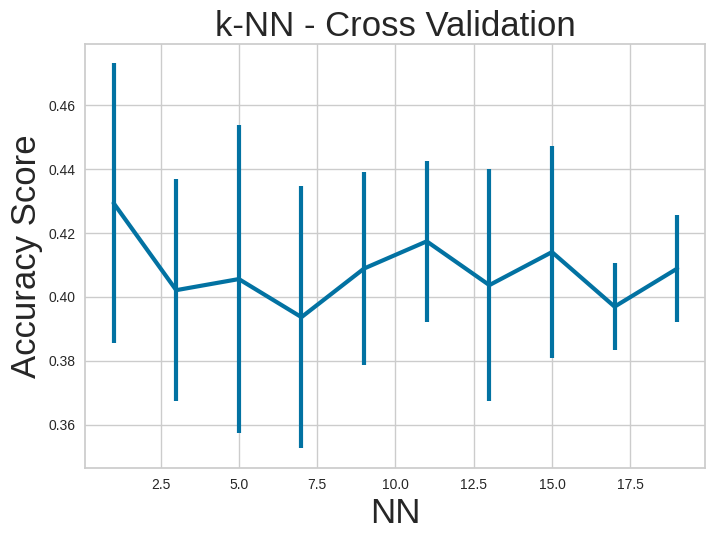

In [70]:
nn_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size = 0.2, random_state=(1))
merr = []
serr = []

for nn in nn_range:
    knn_model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    knn_model.fit(x_train_nn, y_train_nn)
    y_pred_nn = knn_model.predict(x_test_nn)
    print("NN = ", nn)
    print('Train accuracy score:',knn_model.score(x_train_nn, y_train_nn))
    print('Test accuracy score:',knn_model.score(x_test_nn, y_test_nn))

    scores_knn = cross_val_score(knn_model, x_test_nn, y_test_nn, cv=5, scoring='accuracy')
    merr.append(np.array(scores_knn).mean())
    serr.append(np.array(scores_knn).std())

plt.errorbar(nn_range, merr, yerr = serr, linewidth=3)
plt.xlabel('NN', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = f"k-NN - Cross Validation"
plt.title(title_cv, fontsize=25)
plt.show()

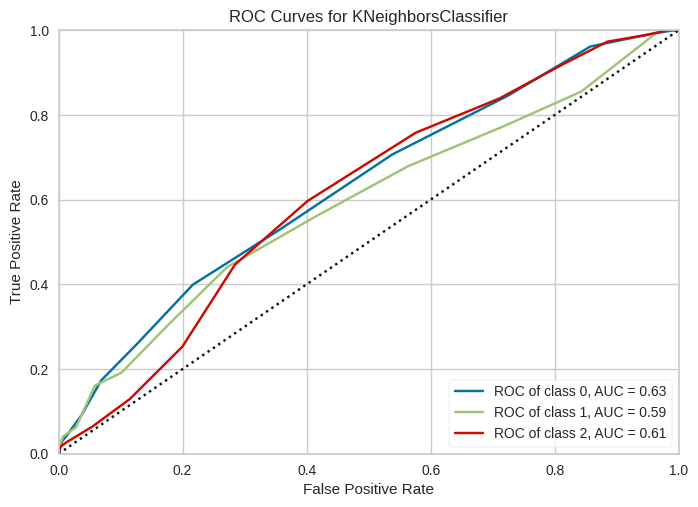

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [71]:
visualizer = ROCAUC(knn_model, classes=["0", "1", "2"], macro=False, micro=False)

visualizer.fit(x_train_nn, y_train_nn)
visualizer.score(x_test_nn, y_test_nn)
visualizer.show()

In [72]:
X = listings[
                ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'bedrooms', 'beds','neighbourhood_cleansed',
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                 'host_identity_verified', 'room_type',
                 'accommodates','price', 'minimum_nights', 'maximum_nights',
                 'bath-products','electric-system',
                 'food-services','house-furniture','house-rules',
                 'kitchen-appliances','parking','recreation','safety',
                 'host_email','host_work_email'] + list(reviews.columns[2:])
]

y = listings[['review_scores_rating']]
y = (y/y.max())*100

y = y.assign(
    rating_bin_ep = pd.qcut(
        y['review_scores_rating'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)

In [73]:
y.groupby('rating_bin_ep').min()
y.groupby('rating_bin_ep').max()

review_scores_rating
rating_bin_ep                      
0                              94.8
1                              98.4
2                             100.0

In [74]:
y = y['rating_bin_ep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [75]:
cnt_plt = sns.countplot(y)
cnt_plt.bar_label(cnt_plt.containers[0])
plt.show()

C =  0.001
Train accuracy score: 0.5438437074057246
Test accuracy score: 0.49727520435967304
Mean Squared Error:  0.9809264305177112
C =  0.1
Train accuracy score: 0.6165379373012267
Test accuracy score: 0.5517711171662125
Mean Squared Error:  0.8569482288828338
C =  1
Train accuracy score: 0.6383462062698774
Test accuracy score: 0.5653950953678474
Mean Squared Error:  0.7942779291553134
C =  10
Train accuracy score: 0.6419809177646524
Test accuracy score: 0.5640326975476839
Mean Squared Error:  0.7997275204359673
C =  100
Train accuracy score: 0.6419809177646524
Test accuracy score: 0.5653950953678474
Mean Squared Error:  0.8024523160762943
C =  1000
Train accuracy score: 0.6428895956383462
Test accuracy score: 0.5640326975476839
Mean Squared Error:  0.8038147138964578


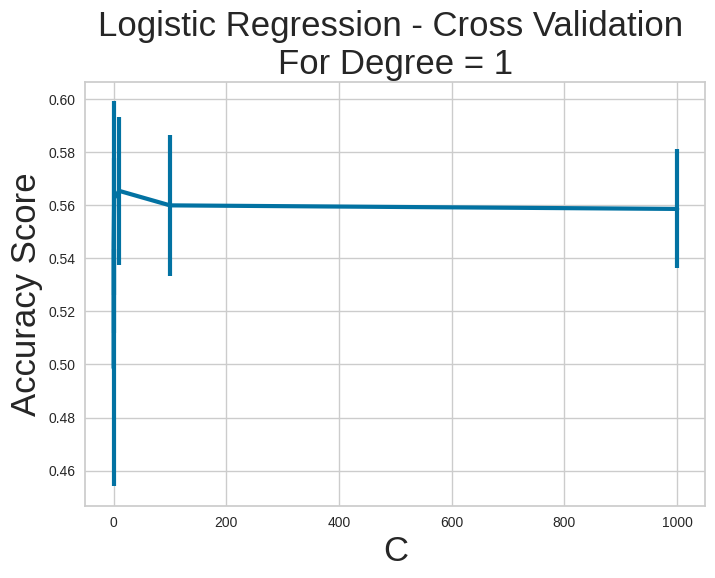

In [76]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
mean_error = []
std_error = []
for c in sorted(c_range):
    logit = LogisticRegression(C=c, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    print("C = ",c)
    print('Train accuracy score:',logit.score(X_train, y_train))
    print('Test accuracy score:',logit.score(X_test, y_test))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    scores = cross_val_score(logit, X_test, y_test, cv=5, scoring='accuracy')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
plt.xlabel('C', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = "Logistic Regression - Cross Validation \nFor Degree = 1"
plt.title(title_cv, fontsize=25)
plt.show()

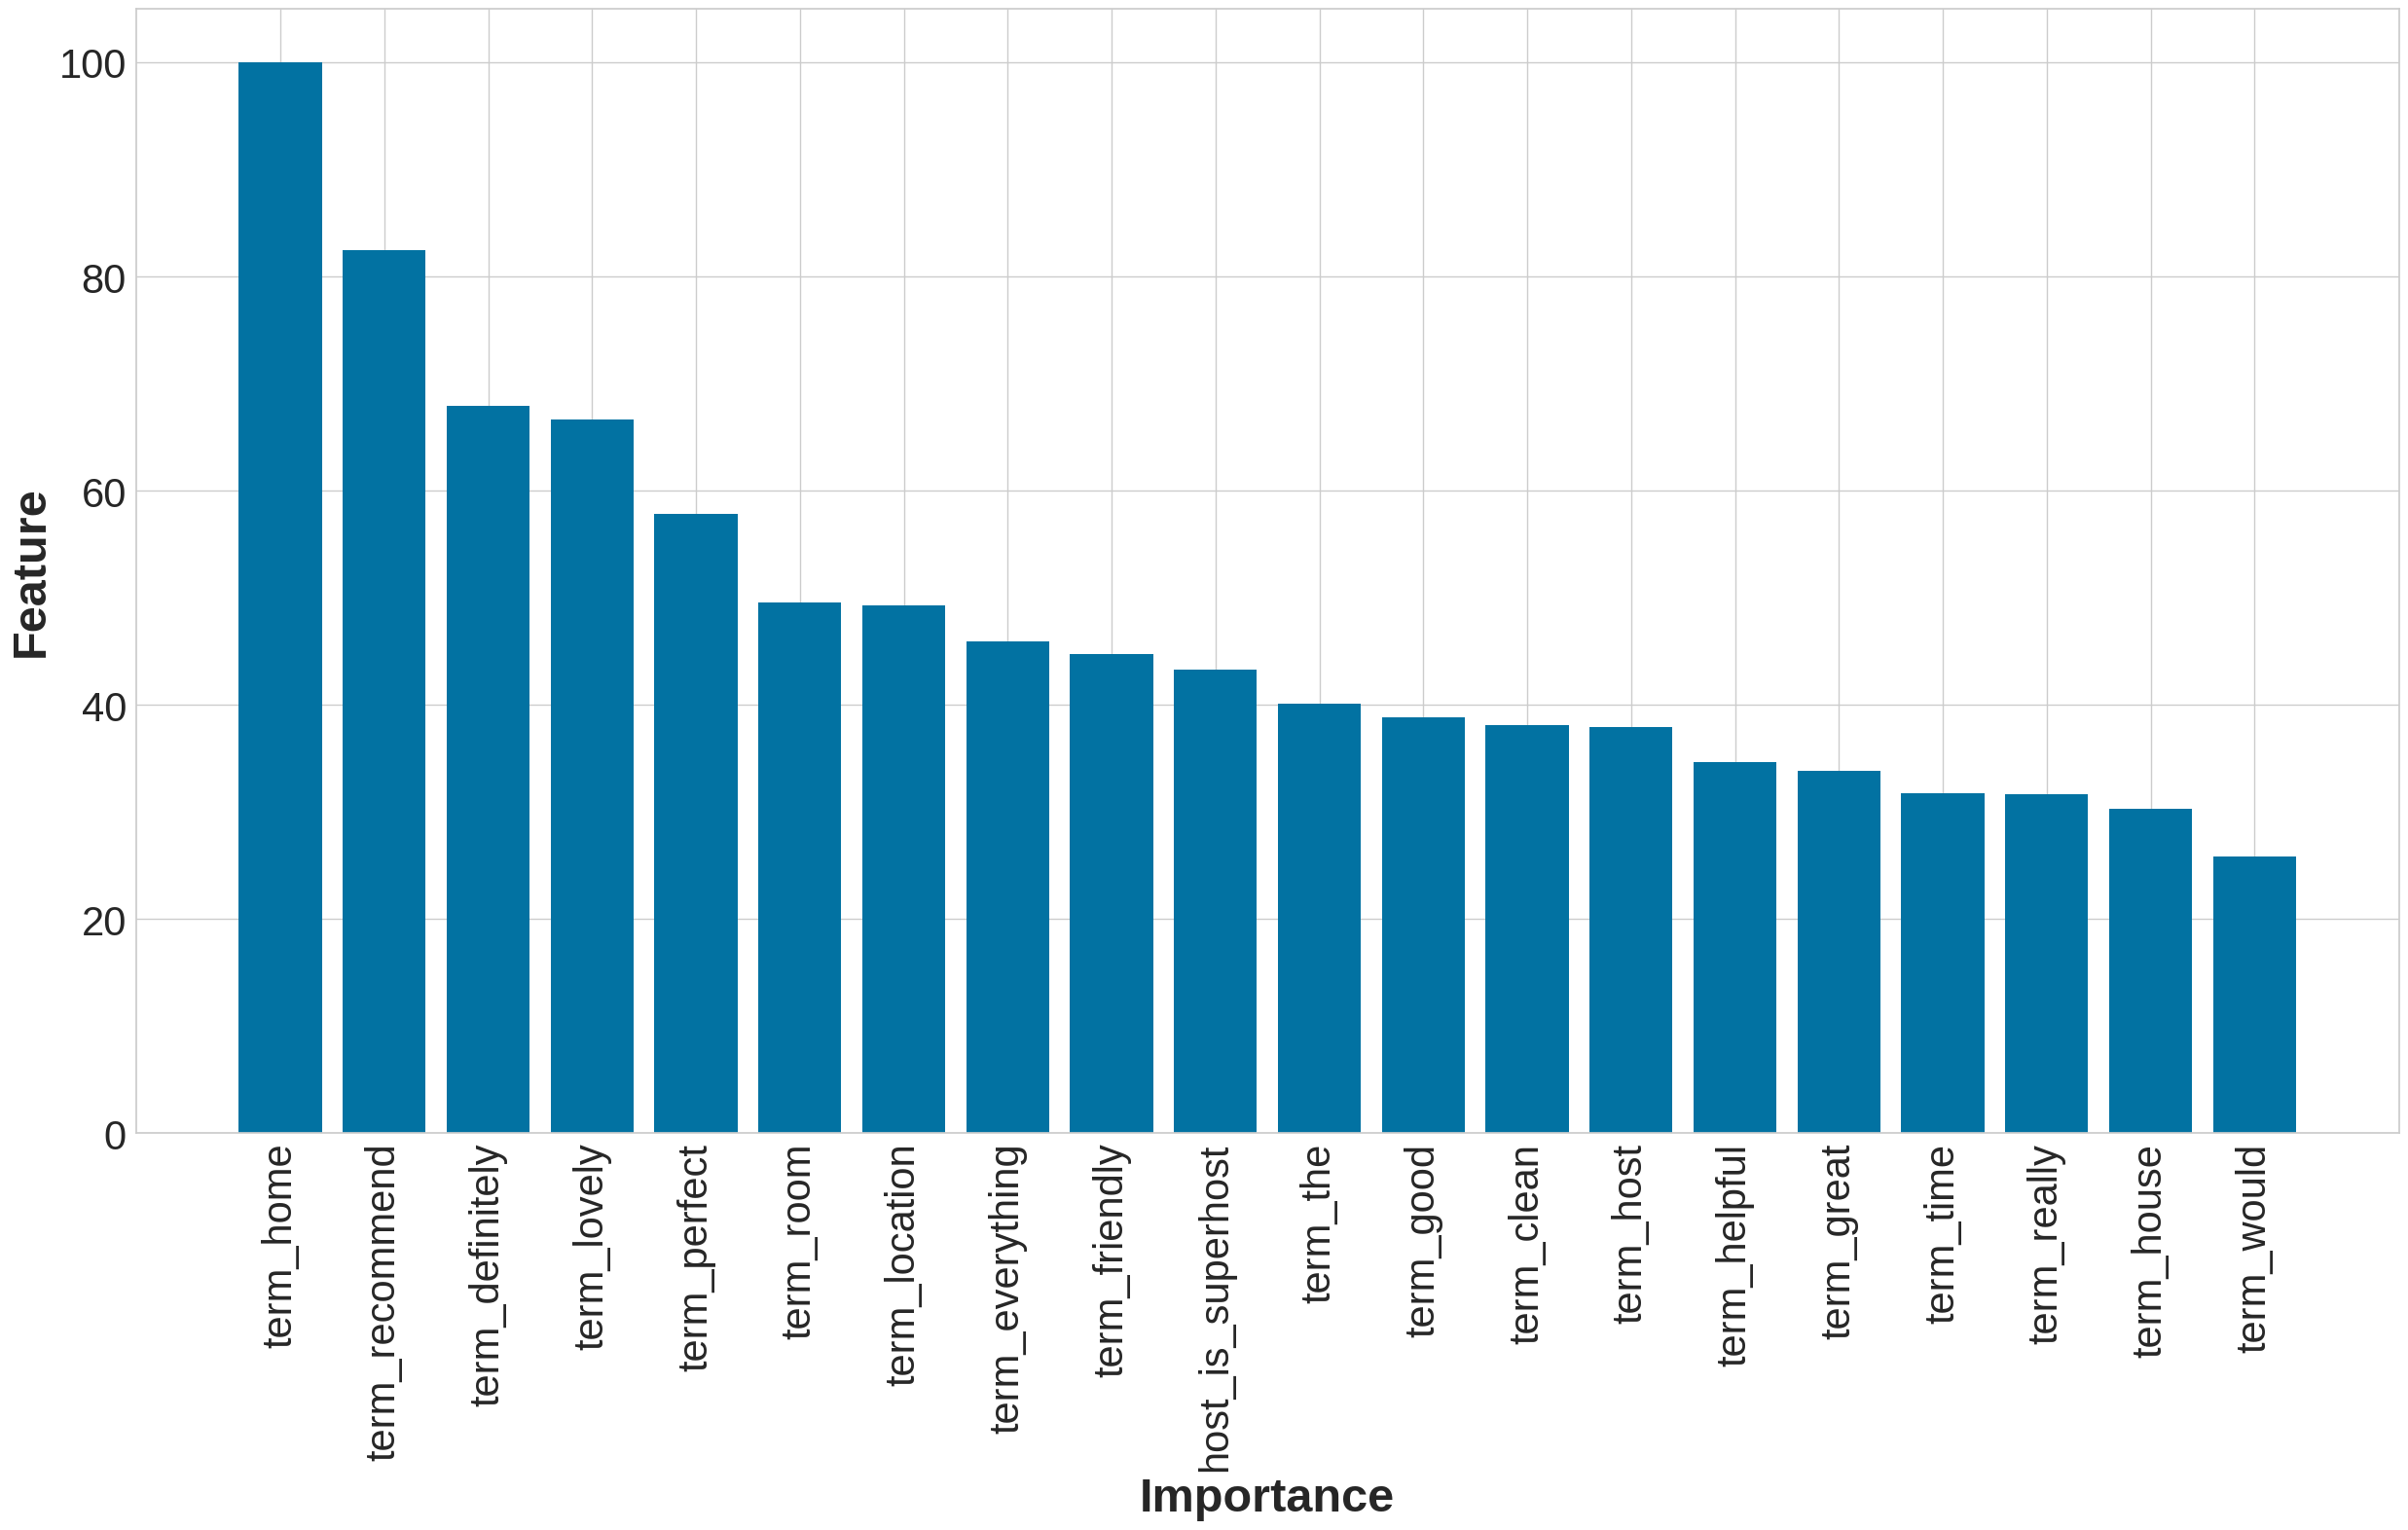

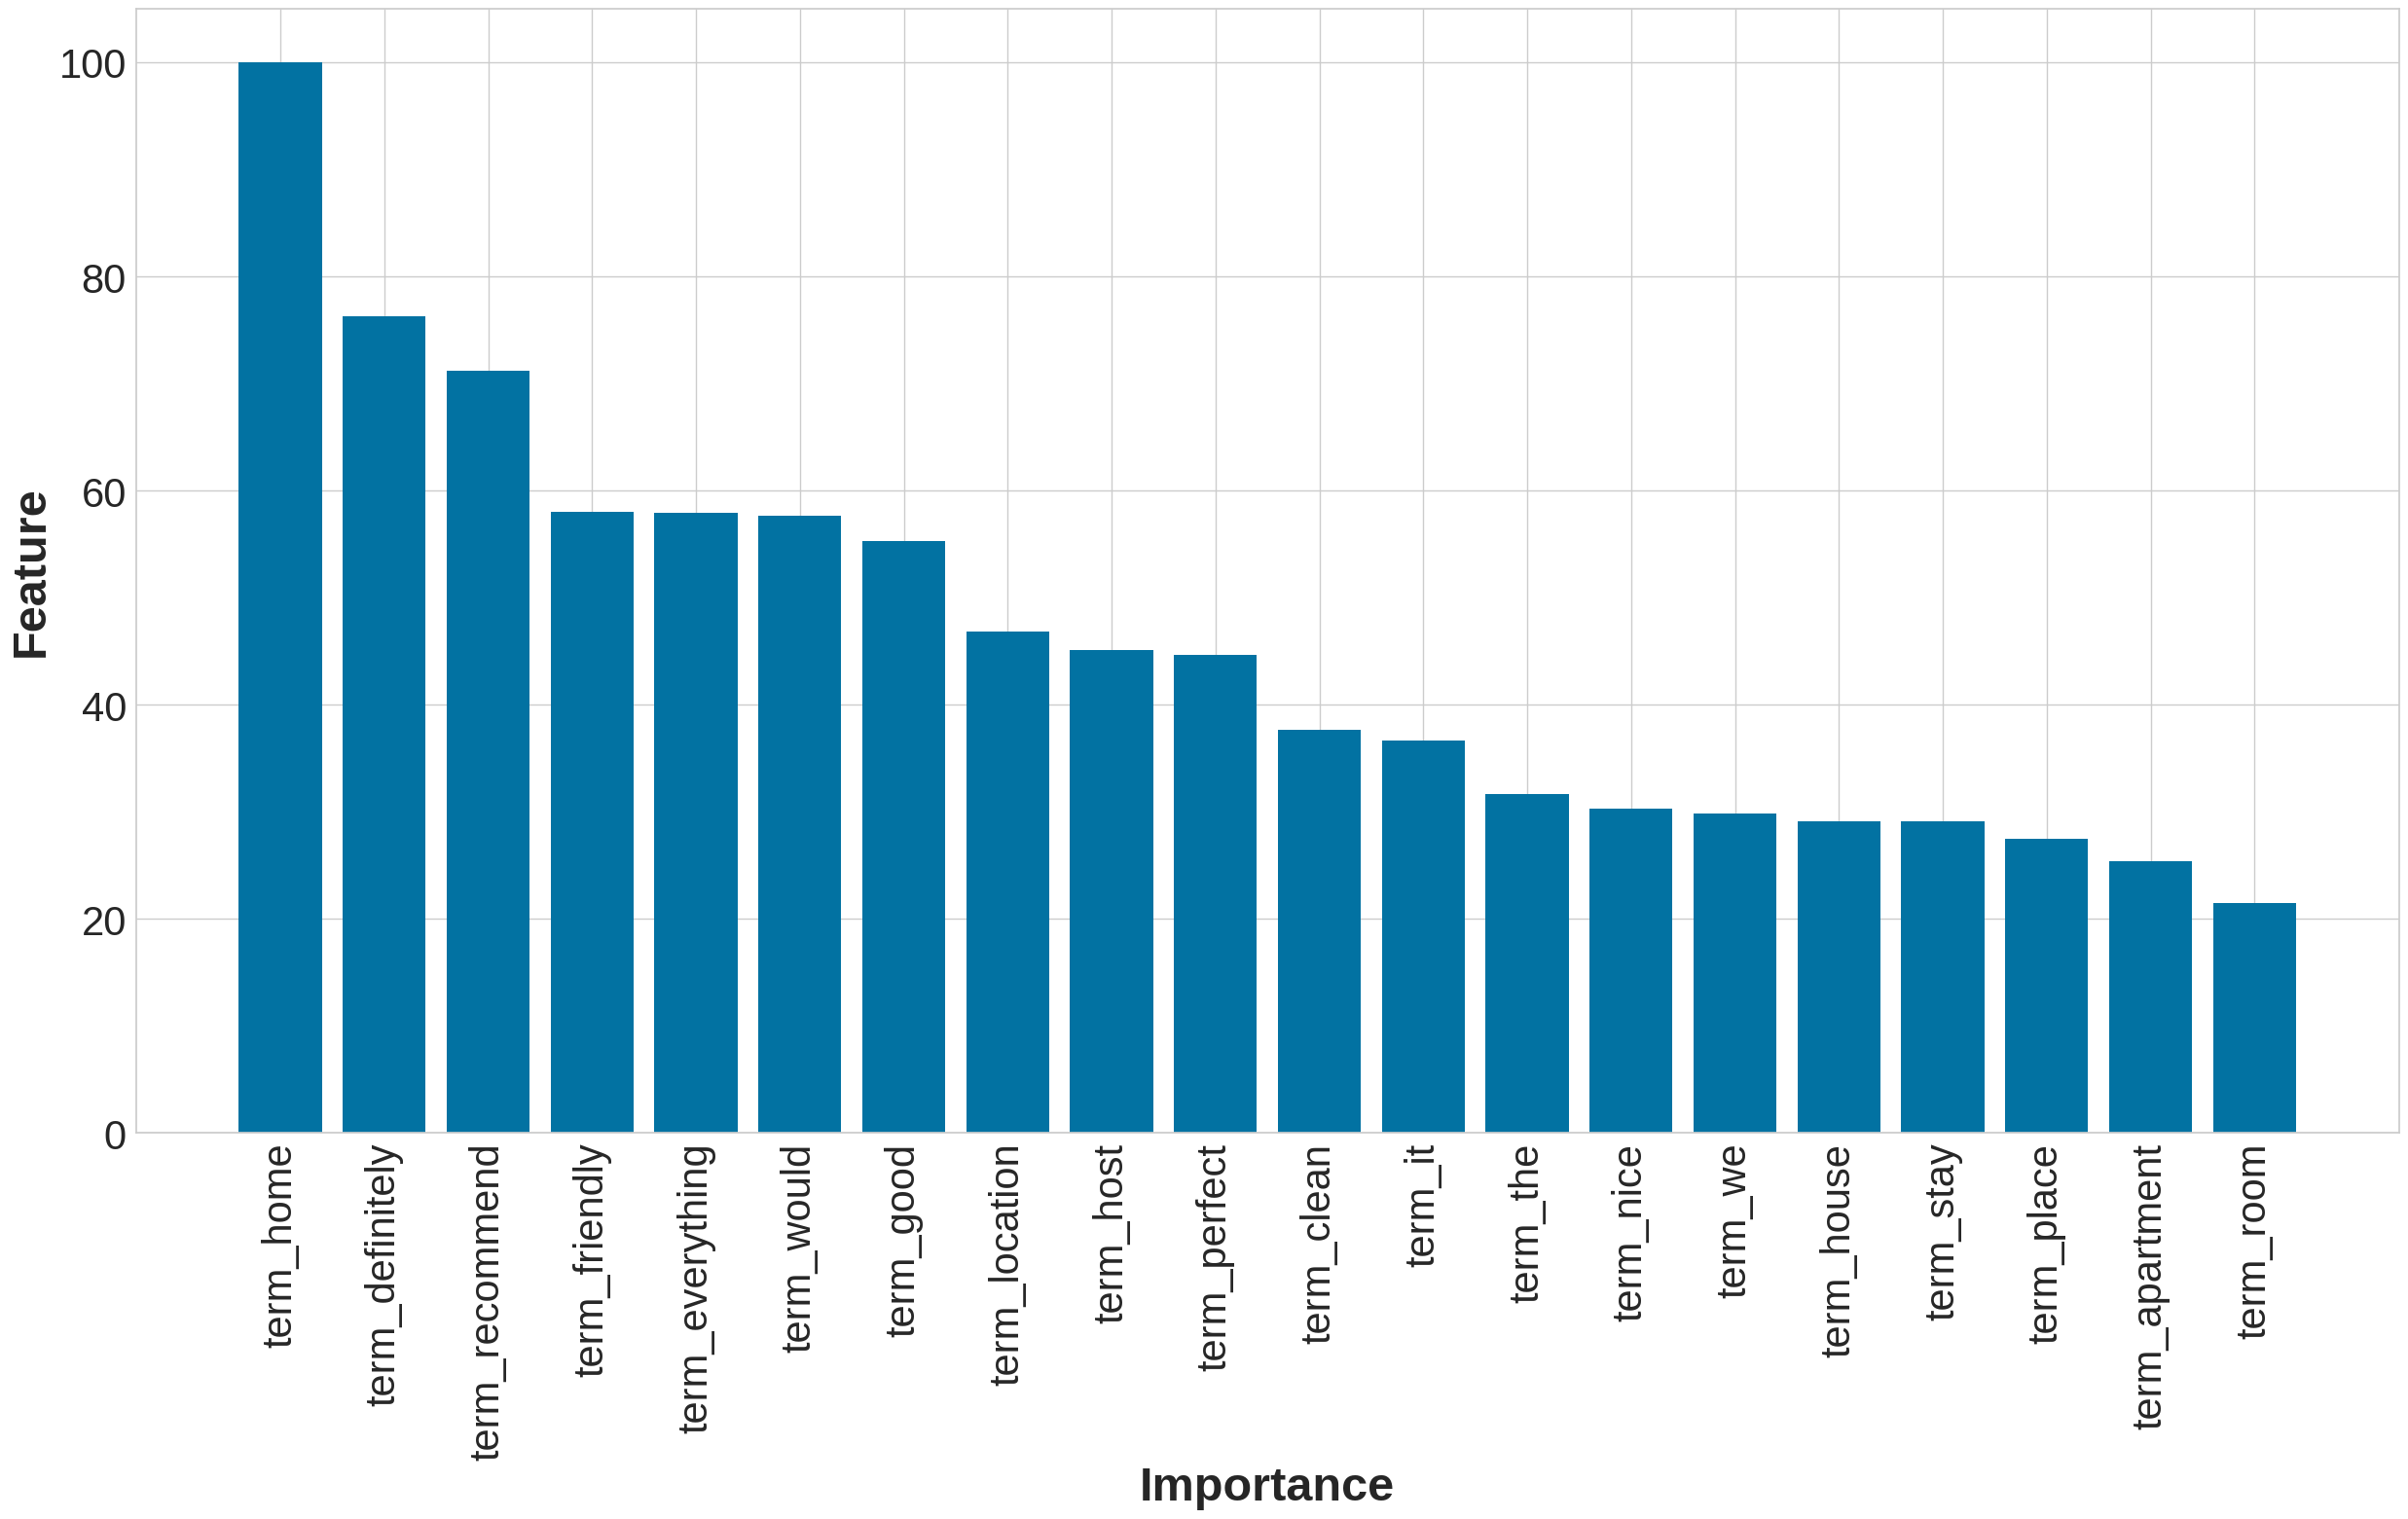

In [77]:
cols = X.columns
cols = np.asarray(cols)

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[1])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[2])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

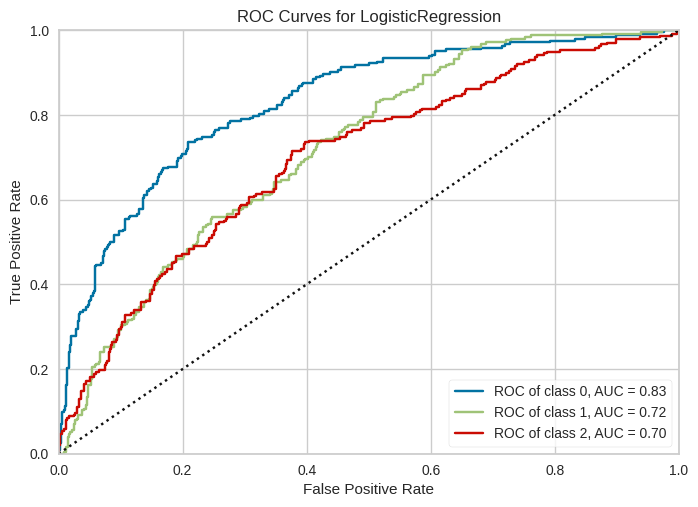

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [78]:
visualizer = ROCAUC(logit, classes=["0", "1", "2"], macro=False, micro=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

 Logistic Regression
 For Degree =  2
 For C =  0.001
 Confusion Matrix - 
 [[148  25  28]
 [ 41  99  48]
 [ 36  53 109]]
 Train accuracy score:  0.7103918228279387
 Test accuracy score:  0.606473594548552
 F1 Score =  0.75
 Classification Report
               precision    recall  f1-score   support

           0       0.66      0.74      0.69       201
           1       0.56      0.53      0.54       188
           2       0.59      0.55      0.57       198

    accuracy                           0.61       587
   macro avg       0.60      0.60      0.60       587
weighted avg       0.60      0.61      0.60       587



 Logistic Regression
 For Degree =  2
 For C =  0.1
 Confusion Matrix - 
 [[148  24  29]
 [ 41  99  48]
 [ 35  58 105]]
 Train accuracy score:  0.7120954003407155
 Test accuracy score:  0.5996592844974447
 F1 Score =  0.752851711026616
 Classification Report
               precision    recall  f1-score   support

           0       0.66      0.74      0.70       201


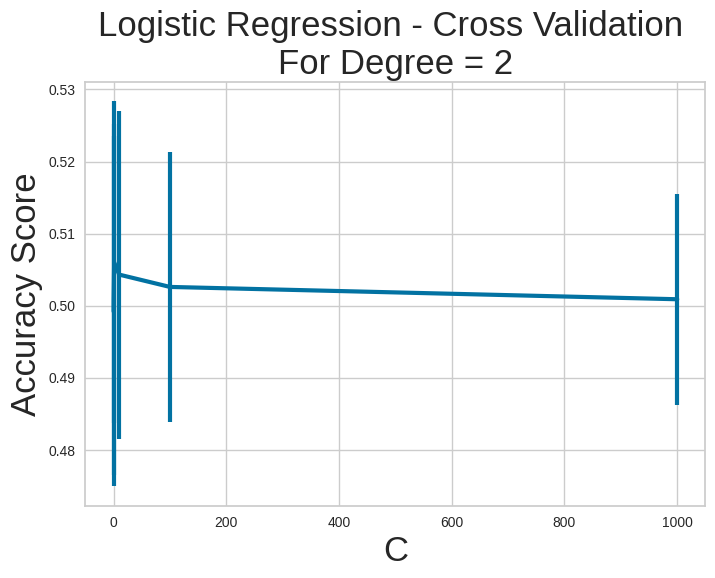

In [79]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
degree_range = [2]

for i in degree_range:
    trans = PolynomialFeatures(degree = i)
    x_poly = trans.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size = 0.2, random_state=(1))
    mean_error = []
    std_error = []
    for c in c_range:
        log_reg = LogisticRegression(C = c, random_state=0, solver='newton-cg',multi_class='multinomial')
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)

        cnf_mtx = metrics.confusion_matrix(y_test, y_pred)
        f1_score = (2*cnf_mtx[1][1])/((2*cnf_mtx[1][1]) + cnf_mtx[0][1] + cnf_mtx[1][0])

        scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')
        mean_error.append(np.array(scores).mean())
        std_error.append(np.array(scores).std())


        print(" Logistic Regression")
        print(" For Degree = ", i)
        print(" For C = ", c)
        print(" Confusion Matrix - \n", cnf_mtx)
        print(' Train accuracy score: ', log_reg.score(x_train, y_train))
        print(' Test accuracy score: ', log_reg.score(x_test, y_test))
        print(" F1 Score = ", f1_score)
        print(" Classification Report\n", classification_report(y_test, y_pred))
        print("\n")

    plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
    plt.xlabel('C', fontsize=25)
    plt.ylabel('Accuracy Score', fontsize=25)
    title_cv = f"Logistic Regression - Cross Validation \nFor Degree = {i}"
    plt.title(title_cv, fontsize=25)
    plt.show()

NN =  1
Train accuracy score: 1.0
Test accuracy score: 0.46507666098807493
NN =  3
Train accuracy score: 0.7035775127768313
Test accuracy score: 0.4804088586030664
NN =  5
Train accuracy score: 0.6473594548551959
Test accuracy score: 0.47189097103918226
NN =  7
Train accuracy score: 0.6222316865417377
Test accuracy score: 0.47018739352640543
NN =  9
Train accuracy score: 0.5971039182282794
Test accuracy score: 0.4616695059625213
NN =  11
Train accuracy score: 0.588160136286201
Test accuracy score: 0.4752981260647359
NN =  13
Train accuracy score: 0.5749574105621805
Test accuracy score: 0.49744463373083475
NN =  15
Train accuracy score: 0.5672913117546848
Test accuracy score: 0.4787052810902896
NN =  17
Train accuracy score: 0.5621805792163543
Test accuracy score: 0.4991482112436116
NN =  19
Train accuracy score: 0.5557921635434412
Test accuracy score: 0.48211243611584326


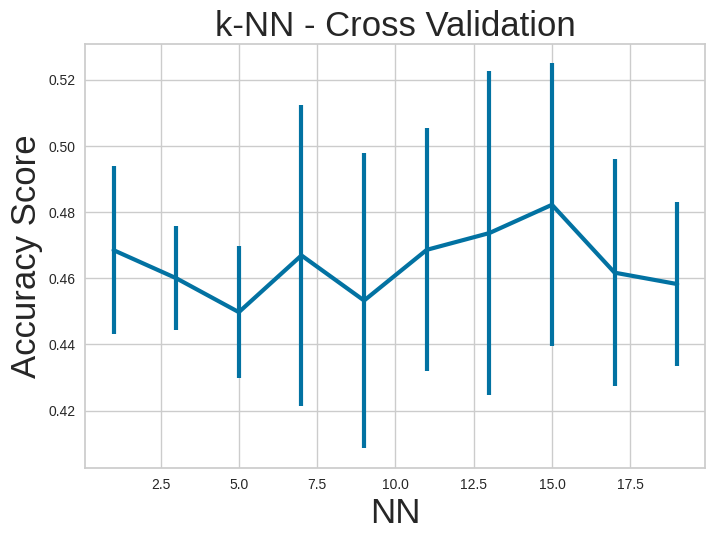

In [80]:
nn_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size = 0.2, random_state=(1))
merr = []
serr = []

for nn in nn_range:
    knn_model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    knn_model.fit(x_train_nn, y_train_nn)
    y_pred_nn = knn_model.predict(x_test_nn)
    print("NN = ", nn)
    print('Train accuracy score:',knn_model.score(x_train_nn, y_train_nn))
    print('Test accuracy score:',knn_model.score(x_test_nn, y_test_nn))

    scores_knn = cross_val_score(knn_model, x_test_nn, y_test_nn, cv=5, scoring='accuracy')
    merr.append(np.array(scores_knn).mean())
    serr.append(np.array(scores_knn).std())

plt.errorbar(nn_range, merr, yerr = serr, linewidth=3)
plt.xlabel('NN', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = f"k-NN - Cross Validation"
plt.title(title_cv, fontsize=25)
plt.show()


In [81]:
visualizer = ROCAUC(knn_model, classes=["0", "1", "2"], macro=False, micro=False)

visualizer.fit(x_train_nn, y_train_nn)
visualizer.score(x_test_nn, y_test_nn)
visualizer.show()

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [82]:
X = listings[
                ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'bedrooms', 'beds','neighbourhood_cleansed',
                 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                 'host_identity_verified', 'room_type',
                 'accommodates','price', 'minimum_nights', 'maximum_nights',
                 'bath-products','electric-system',
                 'food-services','house-furniture','house-rules',
                 'kitchen-appliances','parking','recreation','safety',
                 'host_email','host_work_email'] + list(reviews.columns[2:])
]

y = listings[['review_scores_value']]
y = (y/y.max())*100

y = y.assign(
    rating_bin_ep = pd.qcut(
        y['review_scores_value'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)


In [83]:
y.groupby('rating_bin_ep').min()
y.groupby('rating_bin_ep').max()

review_scores_value
rating_bin_ep                     
0                             91.2
1                             95.8
2                            100.0

In [84]:
y = y['rating_bin_ep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

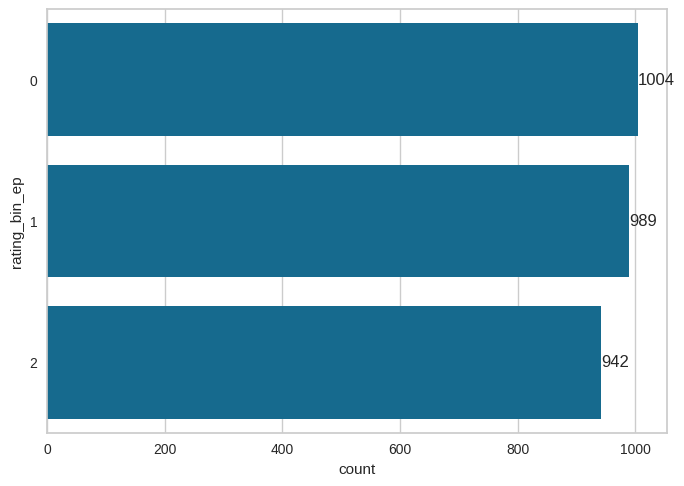

In [85]:
cnt_plt = sns.countplot(y)
cnt_plt.bar_label(cnt_plt.containers[0])
plt.show()

In [86]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
mean_error = []
std_error = []
for c in sorted(c_range):
    logit = LogisticRegression(C=c, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    print("C = ",c)
    print('Train accuracy score:',logit.score(X_train, y_train))
    print('Test accuracy score:',logit.score(X_test, y_test))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    scores = cross_val_score(logit, X_test, y_test, cv=5, scoring='accuracy')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
plt.xlabel('C', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = "Logistic Regression - Cross Validation \nFor Degree = 1"
plt.title(title_cv, fontsize=25)
plt.show()

C =  0.001
Train accuracy score: 0.5134029986369832
Test accuracy score: 0.5068119891008175
Mean Squared Error:  0.8896457765667575
C =  0.1
Train accuracy score: 0.5770104497955475
Test accuracy score: 0.5490463215258855
Mean Squared Error:  0.773841961852861
C =  1
Train accuracy score: 0.6051794638800545
Test accuracy score: 0.5626702997275205
Mean Squared Error:  0.7520435967302452
C =  10
Train accuracy score: 0.6088141753748296
Test accuracy score: 0.5613079019073569
Mean Squared Error:  0.7574931880108992
C =  100
Train accuracy score: 0.6097228532485234
Test accuracy score: 0.55858310626703
Mean Squared Error:  0.7643051771117166
C =  1000
Train accuracy score: 0.611540208995911
Test accuracy score: 0.5613079019073569
Mean Squared Error:  0.7574931880108992


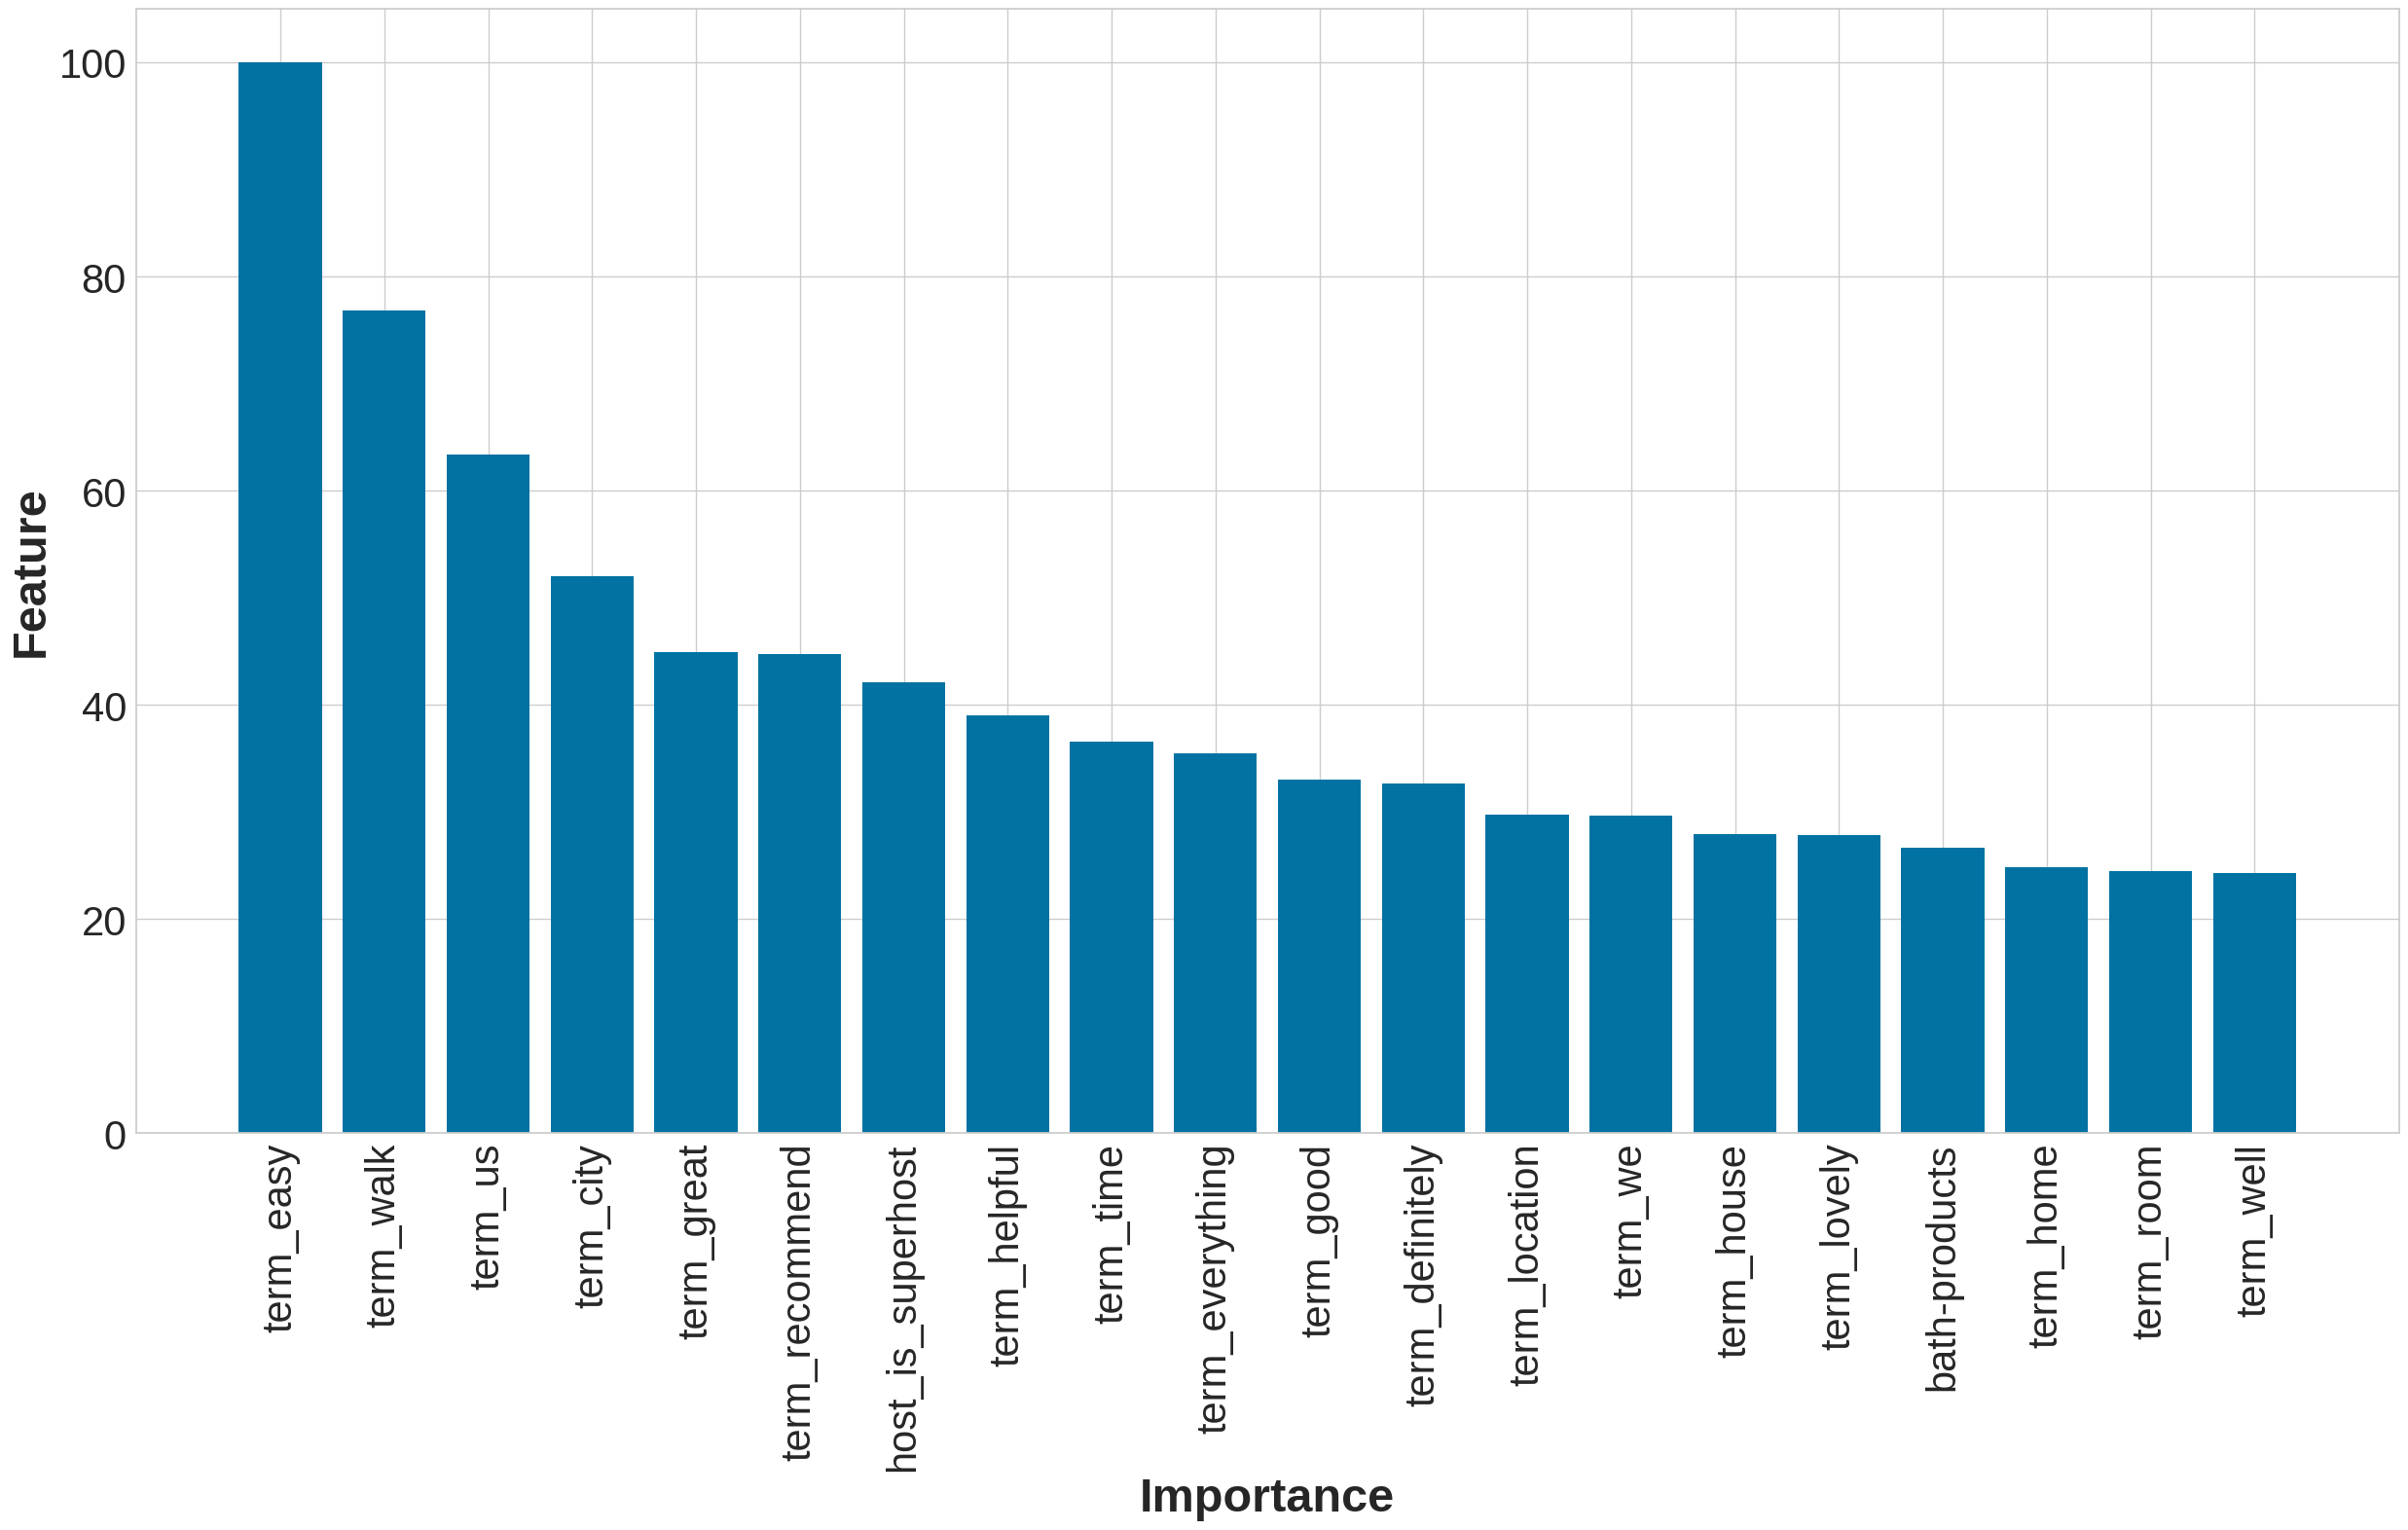

In [87]:
cols = X.columns
cols = np.asarray(cols)

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[1])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

plt.figure(figsize=(30,15))
feature_importance = abs(logit.coef_[2])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top_features = pd.DataFrame({'feature_imp': feature_importance,
                             'features': cols}, columns=['feature_imp', 'features'])
top_features = top_features.sort_values(by='feature_imp', ascending=False).head(20)
plt.bar(top_features.features, top_features.feature_imp)
plt.xlabel('Importance', fontsize=35, fontweight='bold')
plt.ylabel('Feature', fontsize=35, fontweight='bold')
plt.xticks(fontsize=30, rotation = 90)
plt.yticks(fontsize=30)
plt.show()

In [88]:
visualizer = ROCAUC(logit, classes=["0", "1", "2"], macro=False, micro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

 Logistic Regression
 For Degree =  2
 For C =  0.001
 Confusion Matrix - 
 [[140  41  31]
 [ 41 102  53]
 [ 40  44  95]]
 Train accuracy score:  0.6788756388415673
 Test accuracy score:  0.5741056218057922
 F1 Score =  0.7132867132867133
 Classification Report
               precision    recall  f1-score   support

           0       0.63      0.66      0.65       212
           1       0.55      0.52      0.53       196
           2       0.53      0.53      0.53       179

    accuracy                           0.57       587
   macro avg       0.57      0.57      0.57       587
weighted avg       0.57      0.57      0.57       587



 Logistic Regression
 For Degree =  2
 For C =  0.1
 Confusion Matrix - 
 [[139  40  33]
 [ 41 102  53]
 [ 41  43  95]]
 Train accuracy score:  0.6788756388415673
 Test accuracy score:  0.5724020442930153
 F1 Score =  0.7157894736842105
 Classification Report
               precision    recall  f1-score   support

           0       0.63      0.66     

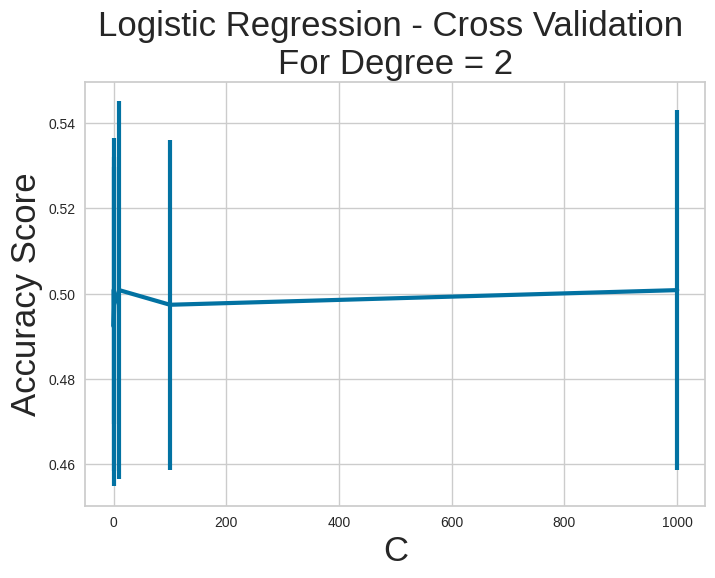

In [89]:
c_range = [0.001, 0.1, 1, 10, 100, 1000]
degree_range = [2]

for i in degree_range:
    trans = PolynomialFeatures(degree = i)
    x_poly = trans.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size = 0.2, random_state=(1))
    mean_error = []
    std_error = []
    for c in c_range:
        log_reg = LogisticRegression(C = c, random_state=0, solver='newton-cg',multi_class='multinomial')
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)

        cnf_mtx = metrics.confusion_matrix(y_test, y_pred)
        f1_score = (2*cnf_mtx[1][1])/((2*cnf_mtx[1][1]) + cnf_mtx[0][1] + cnf_mtx[1][0])

        scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')
        mean_error.append(np.array(scores).mean())
        std_error.append(np.array(scores).std())


        print(" Logistic Regression")
        print(" For Degree = ", i)
        print(" For C = ", c)
        print(" Confusion Matrix - \n", cnf_mtx)
        print(' Train accuracy score: ', log_reg.score(x_train, y_train))
        print(' Test accuracy score: ', log_reg.score(x_test, y_test))
        print(" F1 Score = ", f1_score)
        print(" Classification Report\n", classification_report(y_test, y_pred))
        print("\n")

    plt.errorbar(c_range, mean_error, yerr = std_error, linewidth=3)
    plt.xlabel('C', fontsize=25)
    plt.ylabel('Accuracy Score', fontsize=25)
    title_cv = f"Logistic Regression - Cross Validation \nFor Degree = {i}"
    plt.title(title_cv, fontsize=25)
    plt.show()

In [90]:
nn_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size = 0.2, random_state=(1))
merr = []
serr = []

for nn in nn_range:
    knn_model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    knn_model.fit(x_train_nn, y_train_nn)
    y_pred_nn = knn_model.predict(x_test_nn)
    print("NN = ", nn)
    print('Train accuracy score:',knn_model.score(x_train_nn, y_train_nn))
    print('Test accuracy score:',knn_model.score(x_test_nn, y_test_nn))

    scores_knn = cross_val_score(knn_model, x_test_nn, y_test_nn, cv=5, scoring='accuracy')
    merr.append(np.array(scores_knn).mean())
    serr.append(np.array(scores_knn).std())

plt.errorbar(nn_range, merr, yerr = serr, linewidth=3)
plt.xlabel('NN', fontsize=25)
plt.ylabel('Accuracy Score', fontsize=25)
title_cv = f"k-NN - Cross Validation"
plt.title(title_cv, fontsize=25)
plt.show()

NN =  1
Train accuracy score: 1.0
Test accuracy score: 0.454855195911414
NN =  3
Train accuracy score: 0.6869676320272572
Test accuracy score: 0.454855195911414
NN =  5
Train accuracy score: 0.6277683134582623
Test accuracy score: 0.44293015332197616
NN =  7
Train accuracy score: 0.5907155025553663
Test accuracy score: 0.43781942078364566
NN =  9
Train accuracy score: 0.5813458262350937
Test accuracy score: 0.43270868824531517
NN =  11
Train accuracy score: 0.563458262350937
Test accuracy score: 0.43611584327086883
NN =  13
Train accuracy score: 0.5489778534923339
Test accuracy score: 0.46337308347529815
NN =  15
Train accuracy score: 0.5413117546848382
Test accuracy score: 0.4565587734241908
NN =  17
Train accuracy score: 0.5421635434412265
Test accuracy score: 0.46507666098807493
NN =  19
Train accuracy score: 0.5344974446337308
Test accuracy score: 0.44804088586030666


In [91]:
visualizer = ROCAUC(knn_model, classes=["0", "1", "2"], macro=False, micro=False)
visualizer.fit(x_train_nn, y_train_nn)
visualizer.score(x_test_nn, y_test_nn)
visualizer.show()


<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>